# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
from pandas import DataFrame
from matplotlib.pyplot import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import socket
myhost = socket.gethostname()

if myhost != "i24.lan":
    import sagemaker

%matplotlib inline

# UNCONSTRAINED DISPLAY
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))
np.set_printoptions(linewidth=400)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
InteractiveShell.ast_node_interactivity = "all"
FIG_WIDTH = 18
FIG_HEIGHT = 8

## Part 0: Get to Know the Data
- **Retrieve Data**
- **Handle Missing Row Data**
- **Handle Missing Column Data**
- **Encode Non-Numerical Features**
- **Impute Missing Data**
- **Handle Outliers**
- **Standardize - Normalize Data**


There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

<br/>

## Retrieve Data

In [2]:
# RETRIEVE DATA
if myhost == "i24.lan":
    # --- Local copies ---
    genpop = pd.read_csv("Udacity_AZDIAS_052018.csv", index_col=[0])
    kunden = pd.read_csv("Udacity_CUSTOMERS_052018.csv", index_col=[0])
    mailed = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv", index_col=[0])
    totest = pd.read_csv("Udacity_MAILOUT_052018_TEST.csv", index_col=[0])
else:
    # --- AWS SageMaker S3 copies ---
    genpop = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_AZDIAS_052018.csv"), index_col=[0])
    kunden = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_CUSTOMERS_052018.csv"), index_col=[0])
    mailed = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_MAILOUT_052018_TRAIN.csv"), index_col=[0])    
    totest = pd.read_csv('s3://{}/{}'.format(sagemaker.Session().default_bucket(), "arvato/Udacity_MAILOUT_052018_TEST.csv"), index_col=[0])    
    
# Get an overview of the feature types
genpop.info()
print("--------------------------------------")
kunden.info()
print("--------------------------------------")
mailed.info()
print("--------------------------------------")
totest.info()

/Users/hec/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 541.0+ MB
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.6+ MB
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.9+ MB


<br/>

## Handle Missing Row Data
Ideally we'd like to have clean relevant data with nothing missing. In reality, however, data collection methodologies are plagued with defects that result in incomplete, erroneus, or even irrelevant  entries. We'll try and make the best use of the data given to us, and extract information without contaminating it with our processing steps.

- **Drop Rows:** The code cell below produces a histogram of the percentage of data missing down the rows of the general population and customer datasets. It also graphs this against percentage of rows with that much or more data missing, a kind of deterioration in row data quality. Surprisingly, the histograms appear bimodal for both datasets, and the deterioration exhibits a significant jump at around 68% of missing row data for both, translating to about 10% of rows in the general population being barren, and correspondingly about 20% from the customer dataset. This seems to indicate that at least two separate data collection efforts have been used and mixed. This may be the result of separate survey questionaires, different data collection agencies, or some other similar reason. This presents us with two problems; first, letting go of 20% of the customer rows would waste a large portion of the information. Second, if indeed a different data gathering approach had been used, perhaps a more recent, or one focused on a refined subset of more relevant survey questions (features), then this 20% would be the most meaningful piece of the entire dataset. As far as the general population, 10% hollow rows do not pose that much of a problem, as it is the customer data that this project is focused on.

For the sake of expediency, we'll drop the mostly empty rows from the datasets, i.e., 10% of general population rows and 20% of customer rows missing 60% or more of their entries. This, in my opinion, is preferable to conducting an analysis on what appears to be mixed datasets that perhaps have incompatible distributions across the features.

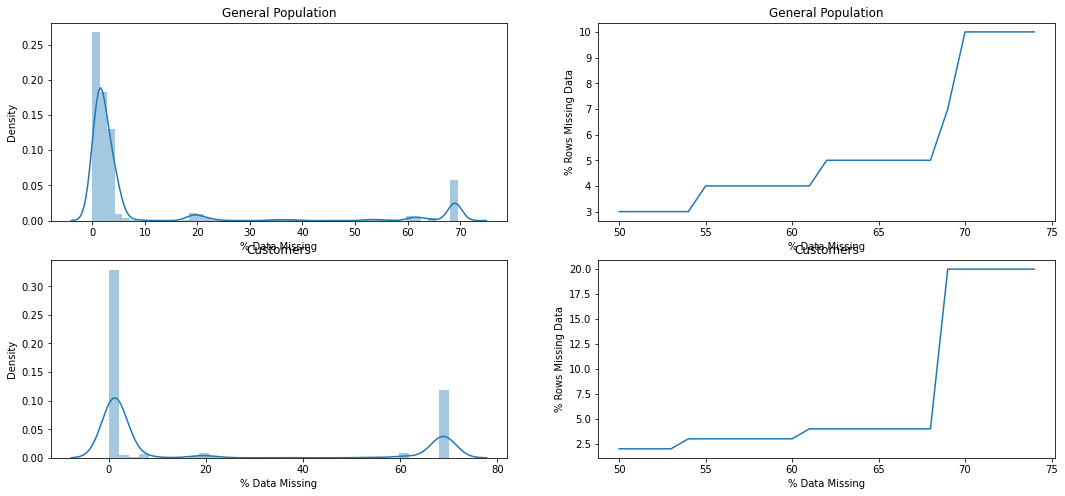

General Population % data missing: 10%
Customer % data missing: 20%


In [3]:
warnings.filterwarnings('ignore')
def empty_rows(df):
    '''Build a dictionary of the percent of rows missing data as a function of percent data missed.
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets
    Returns: x, y lists ready to plot
    '''
    row_pcent = {}
    for r in range(50,75):
        temp_df = df.dropna(axis=0, thresh=int(((100-r)/100)*df.shape[1] + 1))
        row_pcent[r] = round(100*temp_df.isnull().sum().sum()/temp_df.size)
    lists = sorted(row_pcent.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    return x, y

gh = genpop.isnull().sum(axis=1).apply(lambda x:100*round(x/genpop.shape[1],2))
kh = kunden.isnull().sum(axis=1).apply(lambda x:100*round(x/kunden.shape[1],2))
gx, gy = empty_rows(genpop)
kx, ky = empty_rows(kunden)

# Show histograms and cumulative deterioration in row %-age data missing
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
ax1 = f.add_subplot(221)
_ = ax1.set_title("General Population")
_ = ax1.set_xlabel('% Data Missing')
_ = sns.distplot(gh)
ax2 = f.add_subplot(222)
_ = ax2.set_title('General Population')
_ = plt.plot(gx, gy)
_ = plt.xlabel("% Data Missing")
_ = plt.ylabel("% Rows Missing Data")

ax3 = f.add_subplot(223)
_ = ax3.set_title("Customers")
_ = ax3.set_xlabel('% Data Missing')
_ = sns.distplot(kh)
ax4 = f.add_subplot(224)
_ = ax4.set_title("Customers")
_ = plt.plot(kx, ky)
_ = plt.xlabel("% Data Missing")
_ = plt.ylabel("% Rows Missing Data")
_ = plt.show()
print("General Population % data missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("Customer % data missing: {:2}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

In [4]:
# Eliminate rows with more than 60% of their entries missing.
genpop = genpop.dropna(axis=0, thresh=int(.6*genpop.shape[1] + 1))
kunden = kunden.dropna(axis=0, thresh=int(.6*kunden.shape[1] + 1))
print("General Population % data missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("Customer % data missing: {:2}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

General Population % data missing:  3%
Customer % data missing:  2%


<br/>

## Handle Missing Column Data
- **Drop Columns:** Dropping columns loses not only the information in the non-empty rows, but also the potential relation of those values with neighboring features. Dropping features is something best done later when we perform Principal Component Analysis; there the features are traded-off against retained variance, and hence, such choices are statistically justifiable. We'll restric dropping of features only to those that are clearly irrelevant such as **_`LNR`_**, or those features that are missing so much data as to render them useless for analysis. Our function **`dropoff(df, cutoff=.25)`** will eliminate columns missing data in excess of a `cutoff` value at `25%`. This arbitrary level is based on inspecting the percentages of column missing data in our datasets. The code cell below shows these percentages; notice the large jump in missing feature data starting at 25% for both datasets; also notice that very few columns exceed this cutoff level, making the 25% a benign choice for data integrity.
- **Irrelevant Columns:** In `EINGEFUEGT_AM`, we have a date-time feature whose description is missing from the ancillary spreadsheet, but going by the name, it seems to indicate the very instant that this individual row was added to the dataset. This is a good candidate to drop, as such information pertaining to when exactly the data was collected has little to tell us. We'll also take this opportunity to drop the irrelevant ID column `LNR`, as it adds no information to the analysis.
- **Extraneous Columns:** The customer dataset contains three excess columns `CUSTOMER_GROUP`, `ONLINE_PURCHASE`, and `PRODUCT_GROUP`, which need to be dropped as they are particular to the customer dataset, but not to the general population.

In [5]:
# Check column-wise percentages of missing data.
print("----- General Population - Missing Data High Offenders ------")
genpop.isnull().mean().sort_values(ascending=False).head(10)
print("---------- Customers - Missing Data High Offenders ----------")
kunden.isnull().mean().sort_values(ascending=False).head(10)

----- General Population - Missing Data High Offenders ------


ALTER_KIND4                   0.998524
ALTER_KIND3                   0.992421
ALTER_KIND2                   0.963897
ALTER_KIND1                   0.900998
EXTSEL992                     0.708533
KK_KUNDENTYP                  0.626127
ALTERSKATEGORIE_FEIN          0.230452
D19_KONSUMTYP                 0.224728
D19_LOTTO                     0.224728
D19_BANKEN_ONLINE_QUOTE_12    0.224728
dtype: float64

---------- Customers - Missing Data High Offenders ----------


ALTER_KIND4       0.998346
ALTER_KIND3       0.991220
ALTER_KIND2       0.964994
ALTER_KIND1       0.919227
KK_KUNDENTYP      0.450589
EXTSEL992         0.264613
HH_DELTA_FLAG     0.049259
W_KEIT_KIND_HH    0.049259
KBA05_ZUL3        0.037100
KBA05_HERST5      0.037100
dtype: float64

In [6]:
def dropoff(df, cutoff=.25): # Missing >= 25% of data is acceptable
    '''Get a simplistic column drop list based on a cutoff amount of missing data
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets
             cutoff (float): Maximum percentage of missing data considered acceptable
    Returns: None
    '''
    prozent = df.isnull().mean()
    dropcol = list()
    for i in range(len(prozent)):
        if prozent[i] >= cutoff:
            dropcol.append(prozent.index.values[i])
    return dropcol

In [7]:
# Drop columns with excess (>25%) missing data
print("----- General Population ------")
drop_genpop = dropoff(genpop)
genpop.drop(drop_genpop, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_genpop))
print("Percent of data still missing: {:>3}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("---------- Customers ----------")
drop_kunden = dropoff(kunden)
kunden.drop(drop_kunden, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_kunden))
print("Percent of data still missing: {:>3}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

----- General Population ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Percent of data still missing:   2%
---------- Customers ----------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
Percent of data still missing:   1%


In [8]:
# Drop columns with no analytical value
genpop.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)
kunden.drop(['LNR', 'EINGEFUEGT_AM', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

<br/>

## Encode Non-Numerical Features

In [9]:
# Establish categorical columns to encode
print("----- General Population - Types & Obj cols. ------")
genpop.dtypes.value_counts()
genpop.describe(include=['object'])
print("---------- Customers - Types & Obj cols. ----------")
kunden.dtypes.value_counts()
kunden.describe(include=['object'])

----- General Population - Types & Obj cols. ------


float64    261
int64       92
object       5
dtype: int64

CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE OST_WEST_KZ
count          787812          787812          787812                   613982      791957
unique             45              19              43                       35           2
top                6B               8              51            D19_UNBEKANNT           W
freq            56423           77816           77428                   189817      624482

---------- Customers - Types & Obj cols. ----------


float64    261
int64       92
object       5
dtype: int64

CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE OST_WEST_KZ
count          140631          140631          140631                   139832      140889
unique             45              19              43                       35           2
top                2D               2              14            D19_UNBEKANNT           W
freq            11182           17528           14663                    31015      129625

We have five non-numerical features in the general population and customers datasets that need encoding, and possibly processing. Guidance from the EXCEL spreadsheet reveals the nature of these columns; they are a mixture of nominal and ordinal categories. We'll encode the categorical labels as numbers, so the models can work with them.<br/>
Let's look at these features one at a time, first the nominal, and then the ordinal:
- **`CAMEO_DEU_2015 - Nominal`:** The ancillary EXCEL spreadsheet shows 44 clearly nominal ('Cottage Chick", 'Coffee Rider', 'Socking Away', and the like) categories with an extra "XX" slot as a catch-all default bin for unknowns.
- **`D19_LETZTER_KAUF_BRANCHE - Nominal`:** The name, _LETZTER_KAUF_BRANCHE_ appears to indicate the kind of article that was bought last, ranging in diversity from shoes, to books, to cosmetics, etc. This column contains other column names for its entries. The fact that any data point in this column corresponds to, or is related to an entry in another feature makes it suspect for multicollinearity and its effects on modeling.
- **`OST_WEST_KZ - Nominal (Binary)`:** A simple binary category for West and East German individuals.
- **`CAMEO_DEUG_2015 - Ordinal`:** A catch-all default bin "X" is present in this data; additionally, we have what appears to be phantom duplicate slots; there are rows in slot "1", as well as "1.0", similarly for "2" and "2.0", "3", and "3.0", and so on up to "9", and "9.0". Half of the slots are of string type, and the other half numerical. These entries need to be collated to a numerical category that disambiguates them. It is also worth mentioning that this feature is explained in the  spreadsheet as representing rough wealth status descending from "1" indicating "upper class", down to 9 for "urban working class"; hence, this feature's slots, except for the "X", have intrinsic meaning (order). Thus, the encoding will be limited to replacing "X" with a new slot "10", rather than re-encoding the entire column and thereby losing the original data ordinal information of the non-X bins. We should keep this decision in mind when we perform the PCA and clustering steps, because any connection with the "10" slot of `CAMEO_DEUG_2015` is not indicative of wealth status, but rather of an unknown quantity.
- **`CAMEO_INTL_2015 - Ordinal`:** A catch-all default bin "XX" needs renaming as the last integer in the resulting numerical feature; additionally, we need to disambiguate phantom double categories by collating.

In the code cell below, we implement two functions **`encode_nominal(df, col)`**, and **`encode_ordinal(df, col, catchall)`** with the code necessary to carry out the above mentoned encoding steps.

In [10]:
def encode_nominal(df, col):
    '''Convert labels to integers in the entries of a given column from a given dataframe.
    A simple encoding ensuring that the missing data is preserved for later imputation.
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets
             col (String): Name of a nominal categorical feature to encode
    Returns: None
    '''
    print('\033[93m' + "[{:<30}](Unencoded) ".format(col), end=": ")
    print(df[col].unique())
    df[col] = df[col].astype("category")
    mapping = dict(enumerate(df[col].cat.categories))
    df[col] = df[col].cat.codes
    df.loc[(df[col] == -1 ), col] = np.nan
    print('\033[92m' + "{:<3}(  Encoded) ".format(" "), end=": ")
    print(df[col].unique())
    print('\033[94m' + "Mapping ==>> {}".format(mapping))

def encode_ordinal(df, col, catchall):
    '''Disambiguate phantom duplicate categories and replace catch-all with next bigger
    integer in the feature to preserve the order information.
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets
             col (String): Name of a nominal categorical feature to encode
             catchall (String): Default bin for unknwon, not the same as NaN
    Returns: None
    '''
    print('\033[93m' + "[{:<30}](Unencoded) ".format(col), end=": ")
    print(df[col].unique())

    df[col] = df[col].fillna(-1) # Hide NaNs as siloed int
    for i in range(1,10):
        df.loc[(df[col] == str(i) ), col] = int(i)
        df.loc[(df[col] == i ), col] = int(i)
    df.loc[(df[col] == catchall), col] = int(10) # Encode catch-all bin as next in pecking order
    df[col] = df[col].astype("int")
    df.loc[(df[col] == -1 ), col] = np.nan
    print('\033[92m' + "{:<32}(  Encoded) ".format(" "), end=": ")
    print(df[col].unique())

In [11]:
# Perform the actual encoding for both datasets, ensuring that codes for both correspond
print("----- General Population - Encoding of non-numerical features ------")
encode_nominal(genpop, 'CAMEO_DEU_2015')
encode_nominal(genpop, 'D19_LETZTER_KAUF_BRANCHE')
encode_nominal(genpop, 'OST_WEST_KZ')
encode_ordinal(genpop, 'CAMEO_DEUG_2015', "X")
encode_ordinal(genpop, 'CAMEO_INTL_2015', "XX")
print("---------- Customers - Encoding of non-numerical features ----------")
encode_nominal(kunden, 'CAMEO_DEU_2015')
encode_nominal(kunden, 'D19_LETZTER_KAUF_BRANCHE')
encode_nominal(kunden, 'OST_WEST_KZ')
encode_ordinal(kunden, 'CAMEO_DEUG_2015', "X")
encode_ordinal(kunden, 'CAMEO_INTL_2015', "XX")

----- General Population - Encoding of non-numerical features ------
[CAMEO_DEU_2015                ](Unencoded) : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C' 'XX']
   (  Encoded) : [35. 15.  5. 25. 37. 13.  8.  0.  4. 42. 20. 36. 30. 21. 43. 40.  1. 12. nan 17. 14. 11. 18. 31. 39. 27. 28.  7. 32. 41. 33. 22.  3. 38. 26. 24. 19. 16.  9.  6. 34. 10. 29. 23.  2. 44.]
Mapping ==>> {0: '1A', 1: '1B', 2: '1C', 3: '1D', 4: '1E', 5: '2A', 6: '2B', 7: '2C', 8: '2D', 9: '3A', 10: '3B', 11: '3C', 12: '3D', 13: '4A', 14: '4B', 15: '4C', 16: '4D', 17: '4E', 18: '5A', 19: '5B', 20: '5C', 21: '5D', 22: '5E', 23: '5F', 24: '6A', 25: '6B', 26: '6C', 27: '6D', 28: '6E', 29: '6F', 30: '7A', 31: '7B', 32: '7C', 33: '7D', 34: '7E', 35: '8A', 36: '8B', 37: '8C', 38: '8D', 39: '9A', 40: '9B', 41: '9C', 42: '9D', 43: '9E', 44: 'XX

<br/>

## Impute Missing Values
There is plenty of literature on the subject of imputation, as well as tools available. One method known as **_`Uni-variate Imputation`_** consists of replacing missing values of a feature, using the non-missing values of the feature, without taking into account the relations that may exist across features. Such imputation may introduce biases if too much data is imputed and to the extent the features are concentrated in different regions down the rows. We'll restrict ourselves to this type of imputation, ensuring that the amount of imputed data is low, or at least that the imputation does not affect the distribution of data in the feature, i.e., the central tendency - concentration - and the dispersion.

The **_`SimpleImputer`_** from `sklearn.impute` can be used for uni-variate imputation. The `strategy` parameter in the `Simple Imputer` can be configured to perform imputation using the `mean`, `median`, `most_frequent` or a `constant` value. We will use a uni-variate algorithm of our own implementation, designed to improve on the idea of using _"the most frequent value"_. The technique of imputing categorical features with the most frequent value - the largest bin with the most hits, the "mode", is tantamount to hiding dirt under the biggest carpet available, where it will least get noticed. The approach is sensible to the extent that missing entries represents a small percentage of the overall feature, say 5% or so (not much dirt to hide). But as the amount of missing data rises, this method begins to exagerate the concentration of values into the modal bin. Our improvement over mode imputation is a technique that utilizes the data in all the slots of the feature with their corresponding frequencies to guide the imputation of the missing entries. This is akin to hiding dirt under all available carpets, more dirt under the biggest carpet, and correspondingly less dirt under smaller sized carpets. Our code for this technique is seen in the function **`impute(df, min_bins=3, max_bins=50, max_miss=15)`** below. This function examines each feature, and imputes based on whether or not the data is categorical, as well as the percentage of missing data not exceeding some arbitrary threshold, say 15%. For features missing data between 15% and 25%, we'll perform the same technique, but only after a visual inspection of the impact it would have, as judged optically on a case by case basis. 

The function **`see_impute(df)`**, allows us to visualize _before_ and _after_ pictures showing the effect of the technique. The _'before'_ picture shows the missing data as an arbitrary category of our creation, a fake slot with value *`-1`*, shown as a red bar side-by-side with the proper data. Next to it, the _'after'_ picture depicts the "would-be" effect of imputing with the technique. This may not be the ideal solution to the missing data problem. But in the absence of information as to how this data was collected, i.e., not knowing the nature of the `missingness` in the data, whether it is _`Missing Completely At Random (MCAR), Missing At Random (MAR),`_ or _`Missing Not At Random (MNAR)`_, our solution will have to do. As long as we are dealing with large enough datasets that capture the true distribution of the data, this methodolgy is useful. But we have to remember that we are potentially contaminating the data by the subtle perturbation to inter-feature collinearity resulting from uni-variate imputation, as well as imputing too much data in some features.

In [12]:
def impute_feature(col):
    '''Carry out the imputation technique on one caegorical feature.
    Args:    col ((N,) shaped structure): Any feature from General Population, Customers, or Mailout datasets
    Returns: None
    '''
    bin_totals = col.value_counts()
    bin_values = bin_totals.index
    frequencies = [x for x in bin_totals.values/bin_totals.values.sum()]
    col.fillna(col.isnull()*np.random.choice(bin_values, len(col), p=frequencies), inplace=True)

def impute(df, min_bins=3, max_bins=50, max_miss=15):
    '''Carry out the automated imputation of categorical features in a dataframe.
       This function is merely a sanity filter to the impute_feature(col) routine above.
       The EXCEL spreadsheet 'DIAS Attributes - Values 2017.xls' shows categorical features
       having typically 10 or less slots, with some exceptions, e.g., 'LP_LEBENSPHASE_FEIN'
       which has 40. We use 50 as a threshold to decide if a feature is categorical.
       Numerical features in a dataset nearing a million rows are bound to have significantly
       more than 100 differing entries. We also set an arbitrary limit (15%) as the maximum
       fraction of missing data that we are willing to trust this automated methodology to impute.
       Beyond this level, we intend to handle columns manually, i.e., with visualization.
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets
             min_bins(integer, default 2): Minimum number of slots in the feature to use for imputing
             max_bins(integer, default 50): Beyond this number of bins we must be dealing with numerical data
             max_miss(float, default 15): Max %-age of missing data to impute with this methodology
    Returns: None
    '''
    for feat in df:
        bin_totals = df[feat].value_counts()
        bins_count = bin_totals.count()
        if bins_count >= min_bins and bins_count < max_bins: # Deal only with non-binary categorical features
            isnan_count = df[feat].isnull().sum()  # missing entries to impute
            if isnan_count:   # Deal only with imputable features
                bin_values = bin_totals.index
                frequencies = [x for x in bin_totals.values/bin_totals.values.sum()]
                isnan_pcent = round(100*isnan_count/len(df[feat]))
                if isnan_pcent > max_miss or bin_values.astype(float).any == np.nan: # Skip if missing too much (or if NaN is biggest slot!)
                    print('\033[91m' + "{:<28} Found {:>2} slots, NOT IMPUTING {:>2}%".format(feat, bins_count, isnan_pcent))
                else:
                    impute_feature(df[feat])
                    print('\033[92m' + "{:<28} Found {:>2} slots, imputing {:>2}% with {} and p={}"\
                        .format(feat, bins_count, isnan_pcent, bin_values.tolist(), [round(foo,2) for foo in frequencies]))


def see_impute(df):
    '''Show columns of a dataframe (with NaNs as bin value -10) next to the results of imputation
    Args:    df (DataFrame): A subset of either General Population, Customers, or Mailout datasets
    Returns: None
    '''
    NAN_VALUE = -1
    for feat in df:
        withnan = copy.deepcopy(df[feat])
        wcolors = ['gray' for x in withnan.value_counts(dropna=False).sort_index().values]
        wcolors[0] = 'red'
        withnan.fillna(value=NAN_VALUE, inplace=True)
        imputed = copy.deepcopy(df[feat])
        imputed.fillna(imputed.isnull()*np.random.choice(imputed.value_counts().index, len(imputed), \
                p=[x for x in imputed.value_counts().values/imputed.value_counts().values.sum()]), inplace=True)
        icolors = ['black' for x in imputed.value_counts().values]
        f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
        ax1 = f.add_subplot(121)
        ax1.set_title(feat + " ---- BEFORE IMPUTATION")
        plt.bar(withnan.value_counts().sort_index().index, withnan.value_counts().sort_index().values, color=wcolors)
        ax2 = f.add_subplot(122, sharex=ax1, sharey=ax1)
        ax2.set_title(feat + " ---- AFTER IMPUTATION")
        plt.bar(imputed.value_counts().index, imputed.value_counts().values, color=icolors)
        plt.show()

In [13]:
impute(genpop)

ALTERSKATEGORIE_FEIN         Found 26 slots, NOT IMPUTING 23%
ANZ_HH_TITEL                 Found 21 slots, imputing  0% with [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 7.0, 9.0, 13.0, 12.0, 11.0, 14.0, 10.0, 17.0, 20.0, 15.0, 18.0, 16.0, 23.0] and p=[0.97, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ARBEIT                       Found  6 slots, imputing  1% with [4.0, 3.0, 2.0, 1.0, 5.0, 9.0] and p=[0.39, 0.32, 0.17, 0.07, 0.04, 0.0]
BALLRAUM                     Found  7 slots, imputing  0% with [6.0, 1.0, 2.0, 7.0, 3.0, 4.0, 5.0] and p=[0.32, 0.19, 0.13, 0.12, 0.09, 0.08, 0.07]
CAMEO_DEU_2015               Found 45 slots, imputing  1% with [25.0, 35.0, 15.0, 8.0, 11.0, 30.0, 12.0, 36.0, 13.0, 37.0, 42.0, 40.0, 41.0, 31.0, 39.0, 7.0, 38.0, 28.0, 6.0, 21.0, 26.0, 5.0, 18.0, 3.0, 0.0, 19.0, 9.0, 20.0, 32.0, 14.0, 16.0, 10.0, 24.0, 43.0, 27.0, 29.0, 33.0, 17.0, 4.0, 34.0, 2.0, 23.0, 1.0, 22.0, 44.0] and p=[0.07, 0.07, 0.06, 0.04, 0.04,

KBA05_KRSOBER                Found  4 slots, imputing  4% with [2.0, 1.0, 3.0, 9.0] and p=[0.61, 0.2, 0.17, 0.02]
KBA05_KRSVAN                 Found  4 slots, imputing  4% with [2.0, 1.0, 3.0, 9.0] and p=[0.65, 0.17, 0.17, 0.02]
KBA05_KRSZUL                 Found  4 slots, imputing  4% with [2.0, 1.0, 3.0, 9.0] and p=[0.5, 0.28, 0.2, 0.02]
KBA05_KW1                    Found  6 slots, imputing  4% with [3.0, 4.0, 2.0, 1.0, 5.0, 9.0] and p=[0.36, 0.21, 0.21, 0.1, 0.09, 0.02]
KBA05_KW2                    Found  6 slots, imputing  4% with [3.0, 2.0, 4.0, 5.0, 1.0, 9.0] and p=[0.4, 0.2, 0.2, 0.09, 0.09, 0.02]
KBA05_KW3                    Found  6 slots, imputing  4% with [1.0, 0.0, 2.0, 3.0, 4.0, 9.0] and p=[0.31, 0.27, 0.21, 0.11, 0.08, 0.02]
KBA05_MAXAH                  Found  6 slots, imputing  4% with [3.0, 5.0, 2.0, 4.0, 1.0, 9.0] and p=[0.28, 0.26, 0.25, 0.13, 0.07, 0.02]
KBA05_MAXBJ                  Found  5 slots, imputing  4% with [1.0, 4.0, 2.0, 3.0, 9.0] and p=[0.34, 0.25, 0.24, 

KBA13_CCM_2000               Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.46, 0.22, 0.2, 0.07, 0.04]
KBA13_CCM_2500               Found  6 slots, imputing  1% with [3.0, 2.0, 1.0, 0.0, 4.0, 5.0] and p=[0.36, 0.18, 0.13, 0.12, 0.11, 0.09]
KBA13_CCM_2501               Found  6 slots, imputing  1% with [3.0, 1.0, 2.0, 0.0, 4.0, 5.0] and p=[0.38, 0.16, 0.14, 0.12, 0.12, 0.1]
KBA13_CCM_3000               Found  6 slots, imputing  1% with [3.0, 1.0, 2.0, 4.0, 5.0, 0.0] and p=[0.39, 0.19, 0.13, 0.12, 0.1, 0.07]
KBA13_CCM_3001               Found  5 slots, imputing  1% with [1.0, 4.0, 3.0, 5.0, 2.0] and p=[0.43, 0.27, 0.19, 0.11, 0.0]
KBA13_FAB_ASIEN              Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.22, 0.19, 0.08, 0.08]
KBA13_FAB_SONSTIGE           Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.44, 0.21, 0.2, 0.08, 0.07]
KBA13_FIAT                   Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] a

KBA13_SEG_GROSSRAUMVANS      Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.22, 0.19, 0.09, 0.06]
KBA13_SEG_KLEINST            Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.21, 0.2, 0.08, 0.08]
KBA13_SEG_KLEINWAGEN         Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.21, 0.19, 0.09, 0.07]
KBA13_SEG_KOMPAKTKLASSE      Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.44, 0.22, 0.18, 0.08, 0.08]
KBA13_SEG_MINIVANS           Found  5 slots, imputing  1% with [3.0, 2.0, 4.0, 5.0, 1.0] and p=[0.44, 0.21, 0.2, 0.08, 0.07]
KBA13_SEG_MINIWAGEN          Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.22, 0.19, 0.1, 0.06]
KBA13_SEG_MITTELKLASSE       Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.21, 0.2, 0.09, 0.07]
KBA13_SEG_OBEREMITTELKLASSE  Found  5 slots, imputing  1% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.44, 0.23, 0.17, 0.1, 0.0

VK_DISTANZ                   Found 13 slots, imputing  0% with [10.0, 8.0, 9.0, 7.0, 6.0, 11.0, 3.0, 12.0, 1.0, 5.0, 4.0, 13.0, 2.0] and p=[0.12, 0.11, 0.11, 0.1, 0.1, 0.1, 0.09, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
VK_ZG11                      Found 11 slots, imputing  0% with [10.0, 5.0, 7.0, 6.0, 4.0, 8.0, 9.0, 3.0, 2.0, 1.0, 11.0] and p=[0.12, 0.12, 0.11, 0.11, 0.11, 0.1, 0.1, 0.09, 0.07, 0.06, 0.01]
W_KEIT_KIND_HH               Found  7 slots, imputing  4% with [6.0, 4.0, 3.0, 2.0, 1.0, 5.0, 0.0] and p=[0.37, 0.17, 0.13, 0.11, 0.11, 0.08, 0.03]


In [14]:
impute(kunden)

ALTERSKATEGORIE_FEIN         Found 25 slots, imputing  4% with [10.0, 9.0, 11.0, 12.0, 8.0, 13.0, 0.0, 14.0, 15.0, 7.0, 16.0, 17.0, 6.0, 18.0, 19.0, 20.0, 5.0, 21.0, 24.0, 25.0, 22.0, 4.0, 23.0, 2.0, 3.0] and p=[0.14, 0.14, 0.1, 0.09, 0.08, 0.08, 0.08, 0.08, 0.06, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ANZ_HH_TITEL                 Found 20 slots, imputing  2% with [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 13.0, 7.0, 5.0, 8.0, 9.0, 17.0, 11.0, 14.0, 20.0, 10.0, 23.0, 18.0, 15.0, 12.0] and p=[0.96, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ARBEIT                       Found  6 slots, imputing  0% with [3.0, 4.0, 2.0, 1.0, 5.0, 9.0] and p=[0.36, 0.27, 0.24, 0.12, 0.02, 0.0]
BALLRAUM                     Found  7 slots, imputing  0% with [6.0, 1.0, 2.0, 7.0, 3.0, 4.0, 5.0] and p=[0.34, 0.15, 0.14, 0.13, 0.09, 0.08, 0.07]
CAMEO_DEU_2015               Found 45 slots, imputing  0% with [8.0, 25.0, 15.0, 1

KBA05_KRSAQUOT               Found  6 slots, imputing  4% with [3.0, 4.0, 5.0, 2.0, 1.0, 9.0] and p=[0.38, 0.28, 0.17, 0.12, 0.05, 0.01]
KBA05_KRSHERST1              Found  6 slots, imputing  4% with [3.0, 4.0, 2.0, 5.0, 1.0, 9.0] and p=[0.4, 0.26, 0.2, 0.08, 0.05, 0.01]
KBA05_KRSHERST2              Found  6 slots, imputing  4% with [3.0, 4.0, 2.0, 5.0, 1.0, 9.0] and p=[0.41, 0.23, 0.19, 0.09, 0.07, 0.01]
KBA05_KRSHERST3              Found  6 slots, imputing  4% with [3.0, 2.0, 4.0, 1.0, 5.0, 9.0] and p=[0.4, 0.24, 0.18, 0.1, 0.08, 0.01]
KBA05_KRSKLEIN               Found  4 slots, imputing  4% with [2.0, 1.0, 3.0, 9.0] and p=[0.63, 0.2, 0.16, 0.01]
KBA05_KRSOBER                Found  4 slots, imputing  4% with [2.0, 3.0, 1.0, 9.0] and p=[0.63, 0.21, 0.15, 0.01]
KBA05_KRSVAN                 Found  4 slots, imputing  4% with [2.0, 3.0, 1.0, 9.0] and p=[0.66, 0.17, 0.16, 0.01]
KBA05_KRSZUL                 Found  4 slots, imputing  4% with [2.0, 3.0, 1.0, 9.0] and p=[0.56, 0.24, 0.19, 0.0

KBA13_CCM_3000               Found  6 slots, imputing  0% with [3.0, 2.0, 4.0, 5.0, 1.0, 0.0] and p=[0.4, 0.14, 0.14, 0.14, 0.13, 0.06]
KBA13_CCM_3001               Found  5 slots, imputing  0% with [1.0, 4.0, 3.0, 5.0, 2.0] and p=[0.35, 0.3, 0.21, 0.14, 0.0]
KBA13_FAB_ASIEN              Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.45, 0.27, 0.14, 0.1, 0.04]
KBA13_FAB_SONSTIGE           Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.47, 0.25, 0.15, 0.09, 0.04]
KBA13_FIAT                   Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.45, 0.25, 0.16, 0.11, 0.03]
KBA13_FORD                   Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.41, 0.24, 0.16, 0.11, 0.08]
KBA13_GBZ                    Found  5 slots, imputing  0% with [3.0, 4.0, 5.0, 2.0, 1.0] and p=[0.36, 0.28, 0.25, 0.08, 0.02]
KBA13_HALTER_20              Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.46, 0.28, 0.1

KBA13_VORB_0                 Found  5 slots, imputing  0% with [3.0, 4.0, 5.0, 2.0, 1.0] and p=[0.43, 0.27, 0.14, 0.13, 0.02]
KBA13_VORB_1                 Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.47, 0.22, 0.2, 0.06, 0.05]
KBA13_VORB_1_2               Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.46, 0.23, 0.18, 0.09, 0.04]
KBA13_VORB_2                 Found  5 slots, imputing  0% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.47, 0.26, 0.16, 0.07, 0.04]
KBA13_VORB_3                 Found  6 slots, imputing  0% with [3.0, 2.0, 0.0, 1.0, 4.0, 5.0] and p=[0.31, 0.28, 0.23, 0.09, 0.07, 0.04]
KBA13_VW                     Found  5 slots, imputing  0% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.46, 0.2, 0.2, 0.07, 0.07]
KKK                          Found  5 slots, imputing  3% with [3.0, 2.0, 1.0, 4.0, 0.0] and p=[0.3, 0.29, 0.21, 0.16, 0.04]
KONSUMNAEHE                  Found  7 slots, imputing  0% with [3.0, 5.0, 4.0, 1.0, 2.0, 6.0, 7.0] and p=[0.24,

In [15]:
print("Percent of General Population data still missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))
print("Percent of Customer data still missing: {:2}%".format(round(100*kunden.isnull().sum().sum()/kunden.size)))

Percent of General Population data still missing:  1%
Percent of Customer data still missing:  0%


- **`NOT IMPUTED:`**
Features with too much missing data, percentage-wise, are highlighted in red in the output of **`impute(df)`** above; these are categorical features missing more than 15%. By now, most categorical features in the general population data have been imputed, and what remains to impute in the dataset (~1%), numerical and categorical, can be visualized together.

The code cell below enable us to visually inspect the effect of our technique on the general population, without actually performing the imputation, for features missing more than 15%.

ALTERSKATEGORIE_FEIN  D19_KONSUMTYP  D19_LETZTER_KAUF_BRANCHE  D19_BANKEN_ONLINE_QUOTE_12  D19_VERSAND_ONLINE_QUOTE_12  D19_SOZIALES  D19_VERSI_ONLINE_QUOTE_12  D19_LOTTO  D19_TELKO_ONLINE_QUOTE_12  D19_GESAMT_ONLINE_QUOTE_12  HH_DELTA_FLAG  KBA13_ANZAHL_PKW  KONSUMZELLE
1                  21.0            NaN                       NaN                         NaN                          NaN           NaN                        NaN        NaN                        NaN                         NaN            0.0             963.0          1.0
2                  17.0            9.0                      30.0                         0.0                          0.0           0.0                        0.0        0.0                        0.0                         0.0            0.0             712.0          0.0
3                  13.0            9.0                      30.0                         0.0                          0.0           0.0                        0.0        0.0                        0.0                         0.0            NaN             596.0          0.0
4                  14.0            1.0                      24.0                        10.0                         10.0           0.0                        0.0        0.0                        0.0                        10.0            0.0             435.0          0.0
5                  10.0            4.0                      11.0                         0.0                          0.0           4.0                        0.0        0.0                        0.0                        10.0            0.0            1300.0          0.0

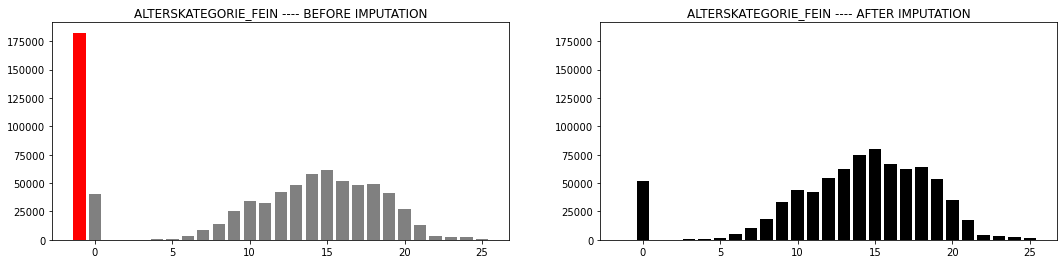

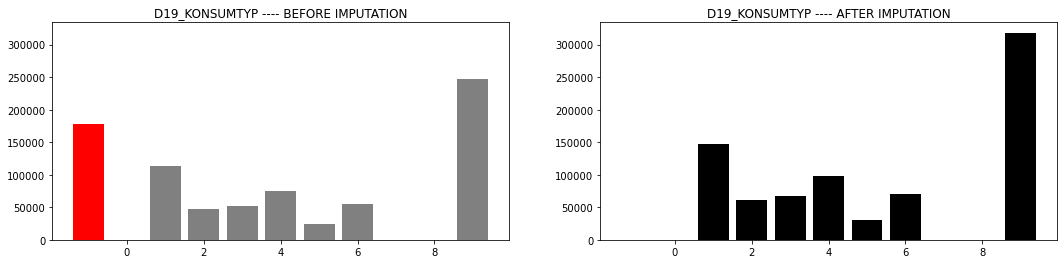

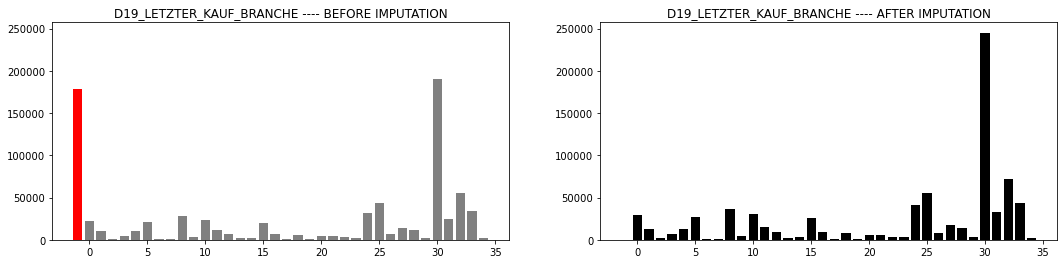

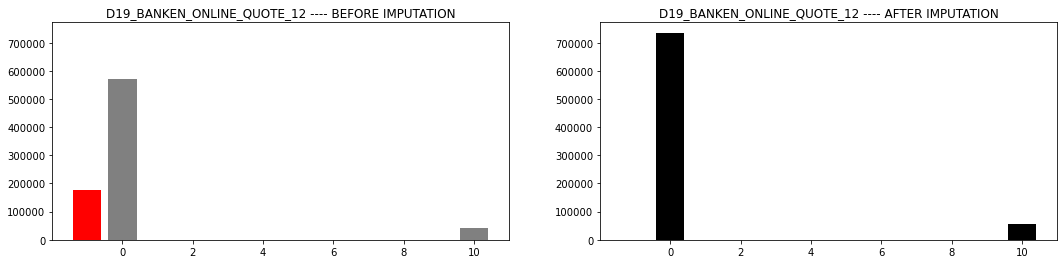

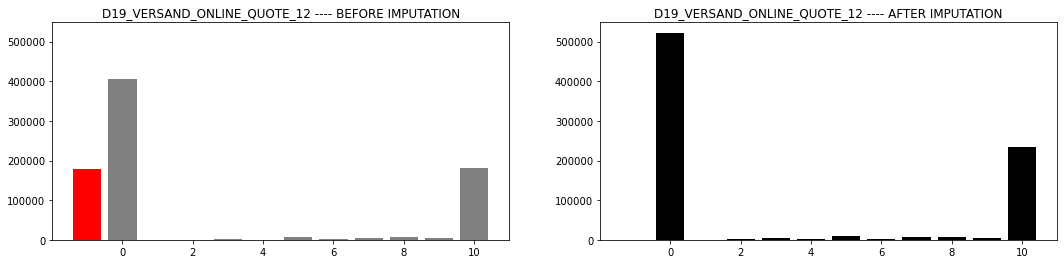

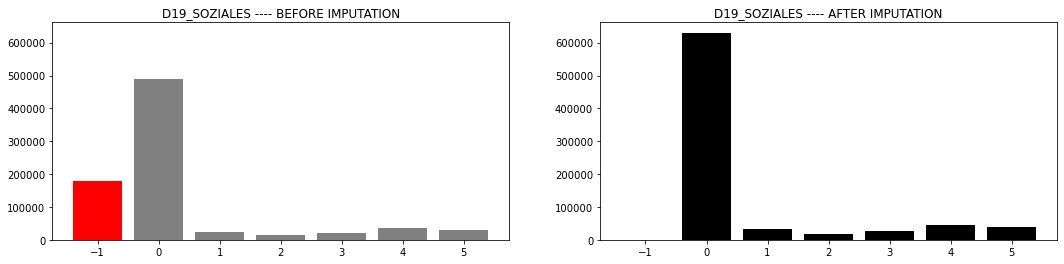

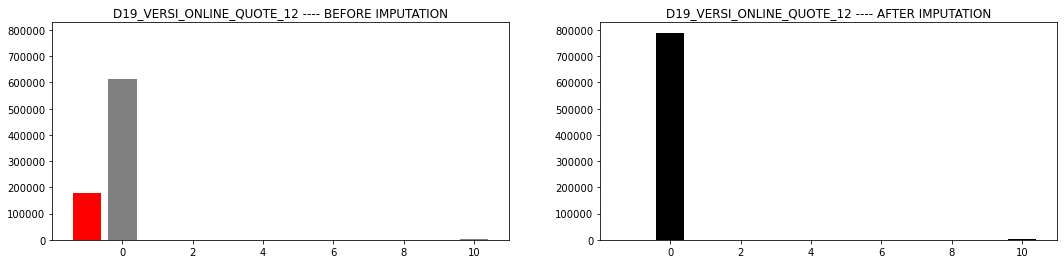

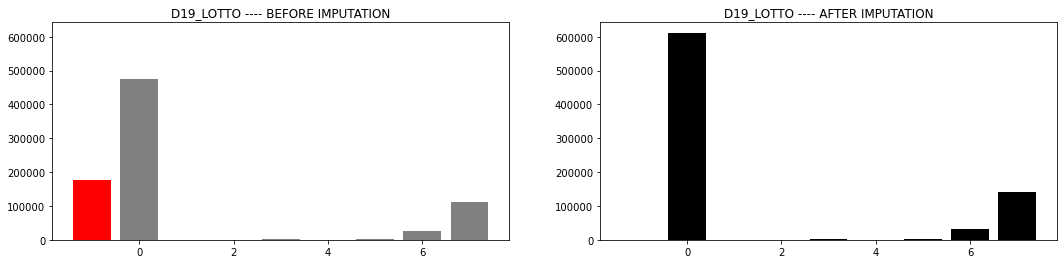

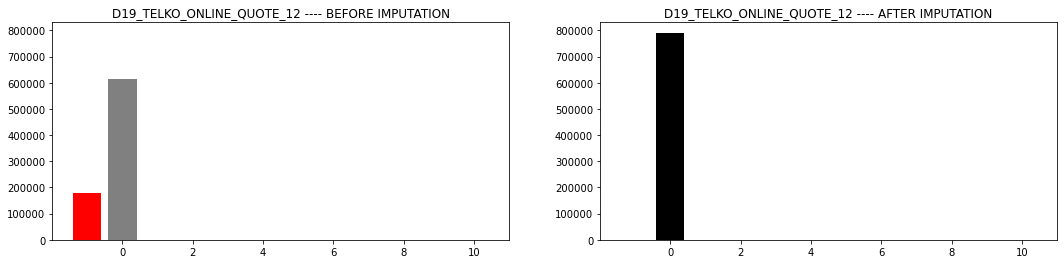

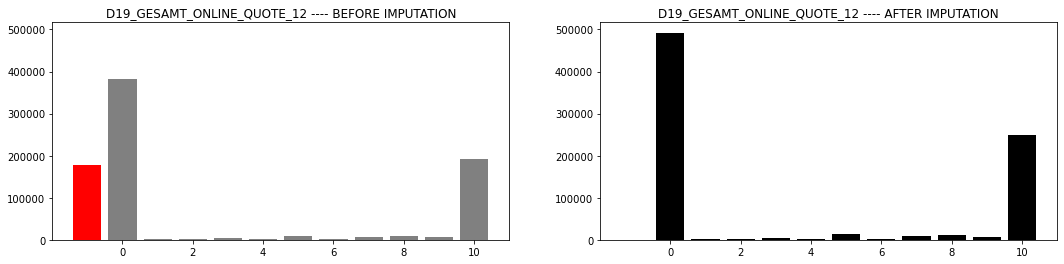

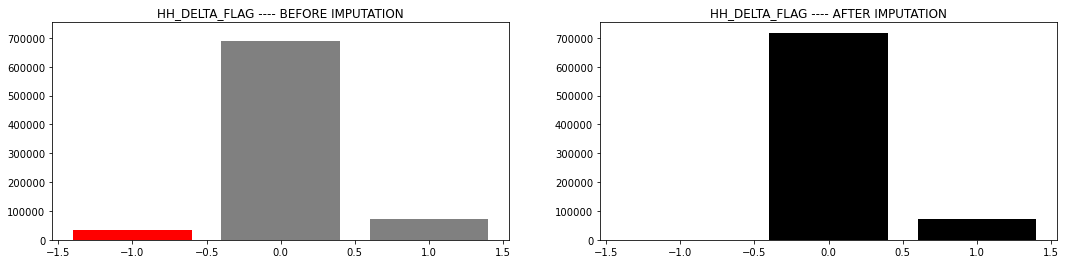

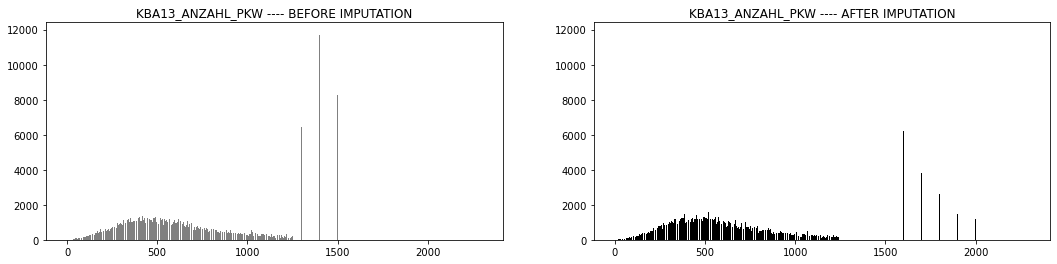

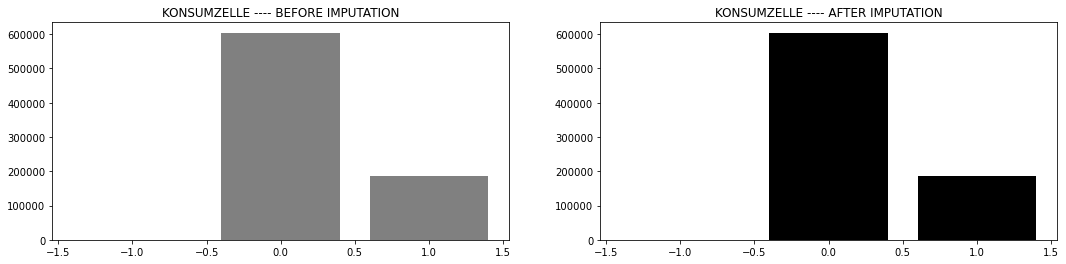

In [16]:
# Examine the rest of the missing data (General Poulation), and the impact our imputing technique would have
genpop_missing = genpop[genpop.isnull().mean().sort_values(ascending=False)[genpop.isnull().mean().sort_values(ascending=False) > 0].index[:]]
genpop_missing.head()
see_impute(genpop_missing)

HH_DELTA_FLAG  KBA13_ANZAHL_PKW
0            0.0            1201.0
2            0.0             433.0
3            NaN             755.0
4            1.0             513.0
5            0.0            1167.0

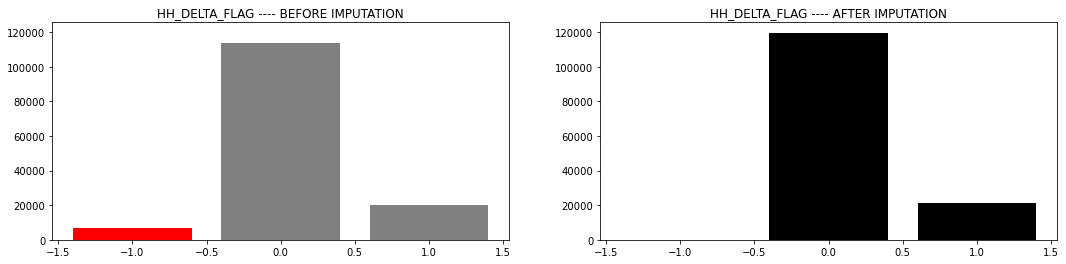

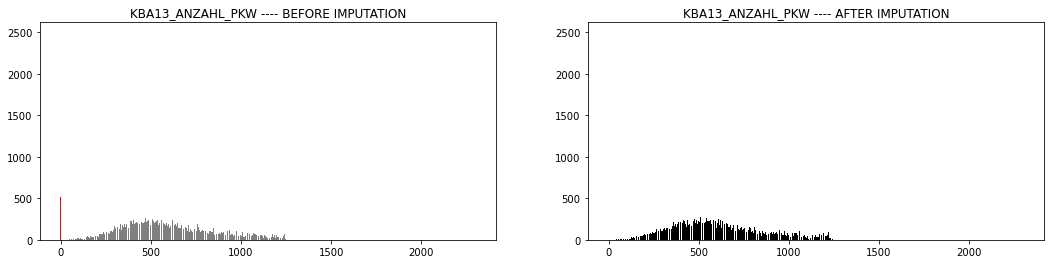

In [17]:
# Examine the rest of the missing data (Customer), and the impact our imputing technique would have
kunden_missing = kunden[kunden.isnull().mean().sort_values(ascending=False)[kunden.isnull().mean().sort_values(ascending=False) > 0].index[:]]
kunden_missing.head()
see_impute(kunden_missing)

With the exception of **`D19_VERSI_ONLINE_QUOTE_12, D19_TELKO_ONLINE_QUOTE_12`** in the general population dataset, and **`KBA13_ANZAHL_PKW`** in both datasets, all other columns appear amenable to our imputation technique. The amount of missing data, between 15% and 25% is significant, to be sure, but the data distribution appears, at least optically, to be unaffected by the methodology. We'll impute them with our algorithm.

In [18]:
# Impute the rest of the categorical features (both sets) whose distribution is not perturbed
for col in genpop[['ALTERSKATEGORIE_FEIN', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
                   'D19_SOZIALES', 'D19_LOTTO', 'D19_GESAMT_ONLINE_QUOTE_12', 'HH_DELTA_FLAG', 'KONSUMZELLE']]:
    impute_feature(genpop[col])
impute_feature(kunden['HH_DELTA_FLAG'])

- **`Drop Columns:`** Handle the two categorical features with missing data, namely `D19_VERSI_ONLINE_QUOTE_12`, and `D19_TELKO_ONLINE_QUOTE_12`. The code cell below shows the justification for dropping them.
    - `D19_VERSI_ONLINE_QUOTE_12:` 9 bins with one taking up 77% of all data, and `NaNs` the remaining 23%; this is a meaningless feature, a column to drop.
    - `D19_TELKO_ONLINE_QUOTE_12:` 5 bins, one taking 77%, and 23% `NaNs`, drop!

In [19]:
print("Number of bins: {}".format(genpop['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
genpop['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).head(2)
print("-----------------------------------------------")
print("Number of bins: {}".format(genpop['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
genpop['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).head(2)

Number of bins: 9


0.0    0.773259
NaN    0.224728
Name: D19_VERSI_ONLINE_QUOTE_12, dtype: float64

-----------------------------------------------
Number of bins: 5


0.0    0.774303
NaN    0.224728
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: float64

In [20]:
# DROP One-Bin-takes-all categorical features D19_VERSI_ONLINE_QUOTE_12, and D19_TELKO_ONLINE_QUOTE_12
genpop.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)
kunden.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)

<br/>

The cell code below reveals the one feature that remains with missing data.
- **`KBA13_ANZAHL_PKW`:** The EXCEL spreadsheet describes it as German for **_"Number of cars in the Zip Code"_**, a numerical feature with over 1,200 different values concentrated in a range of integers that permits them to be considered categorical, albeit with many bins, at least for a thought experiment. It would be beneficial to visualize the effect of imputing with our technique vs. using mean imputation, in spite of the fact that the feature is numerical, and our technique applicable only to categorical features. Our function **`mean_or_not(col, xrange)`** does this.

In [21]:
def mean_or_not(col, xrange):
    '''Show the data, the result of mean imputation, and the results of our imputation on some integer
       numerical features of interest, particulary KBA13_ANZAHL_PKW.
    Args: col ((N,) shaped structure): Any numerical feature from General Population, Customers, or Mailout datasets
          slots (Integer): Number of bins to use for the histogram.
    Returns: None
    '''
    NAN_VALUE = -1
    withnan = copy.deepcopy(col)
    withnan.fillna(value=NAN_VALUE, inplace=True)        
    meaned = copy.deepcopy(col)
    meaned.fillna(col.mean(), inplace=True)    
    imputed = copy.deepcopy(col)
    imputed.fillna(imputed.isnull()*np.random.choice(imputed.value_counts().index, len(imputed), \
            p=[x for x in imputed.value_counts().values/imputed.value_counts().values.sum()]), inplace=True)
        
    f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
    ax3 = f.add_subplot(133)
    _ = sns.distplot(imputed, hist=False, kde_kws={'clip': xrange})
    _ = ax3.set_title("IMPUTED")
    ax1 = f.add_subplot(131, sharex=ax3, sharey=ax3)
    _ = sns.distplot(withnan, hist=False, kde_kws={'clip': xrange})
    _ = ax1.set_title("RAW DATA")
    ax2 = f.add_subplot(132, sharex=ax3, sharey=ax3)
    _ = sns.distplot(meaned, hist=False, kde_kws={'clip': xrange})
    _ = ax2.set_title("MEANED")
    _ = plt.show()

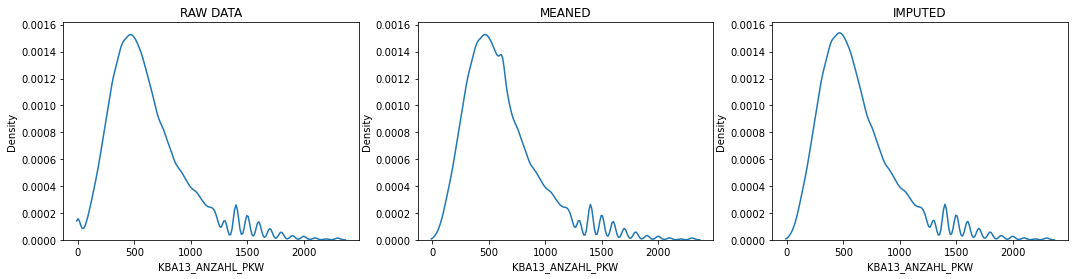

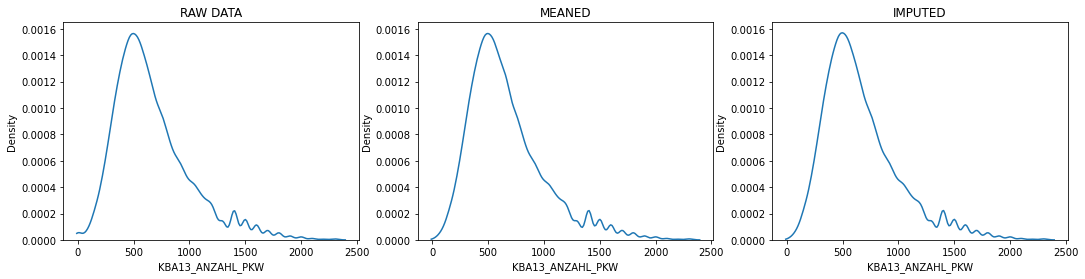

In [22]:
mean_or_not(genpop['KBA13_ANZAHL_PKW'], xrange=(-10,2500))
mean_or_not(kunden['KBA13_ANZAHL_PKW'], xrange=(-10,2500))

In the case of the general population, imputing `KBA13_ANZAHL_PKW` with the mean sticks a lump that appears as an outlier. On the customer dataset, the amount of data missing is too small to be visible. We'll proceed with our imputing technique on both for the sake of consistency.

In [23]:
impute_feature(genpop['KBA13_ANZAHL_PKW'])
impute_feature(kunden['KBA13_ANZAHL_PKW'])

In [24]:
# Establish that no data is missing in the dataset
genpop.columns[genpop.isnull().any()]
kunden.columns[kunden.isnull().any()]
print('\033[1m' + "Percent of data still missing: {:2}%".format(round(100*genpop.isnull().sum().sum()/genpop.size)))

Index([], dtype='object')

Index([], dtype='object')

Percent of data still missing:  0%


<br/>

## Handle Outliers
We can now inspect the numerical feature data for potential outliers. The code cell below lists the numerical features of each dataset in order to visualize their histograms and peruse for potential outliers.

In [25]:
def numericals(df):
    '''List numerical features to check for possible outliers 
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets
    Returns: None
    '''
    MAX_CATEGORIES = 50 # Arbitrary cutoff to decide if a feature has numerical characteristics (too many slots)
    for feat in df:
        bin_counts = df[feat].value_counts().count()
        if bin_counts > MAX_CATEGORIES:
            print("{:<30} [{:>4}]".format(feat, bin_counts))

In [26]:
print(" ---- General Population - Numerical Features ----")
numericals(genpop)
print(" ---- Customers - Numerical Features ----")
numericals(kunden)

 ---- General Population - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 292]
ANZ_STATISTISCHE_HAUSHALTE     [ 268]
GEBURTSJAHR                    [ 117]
KBA13_ANZAHL_PKW               [1261]
 ---- Customers - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 216]
ANZ_STATISTISCHE_HAUSHALTE     [ 214]
GEBURTSJAHR                    [ 113]
KBA13_ANZAHL_PKW               [1250]


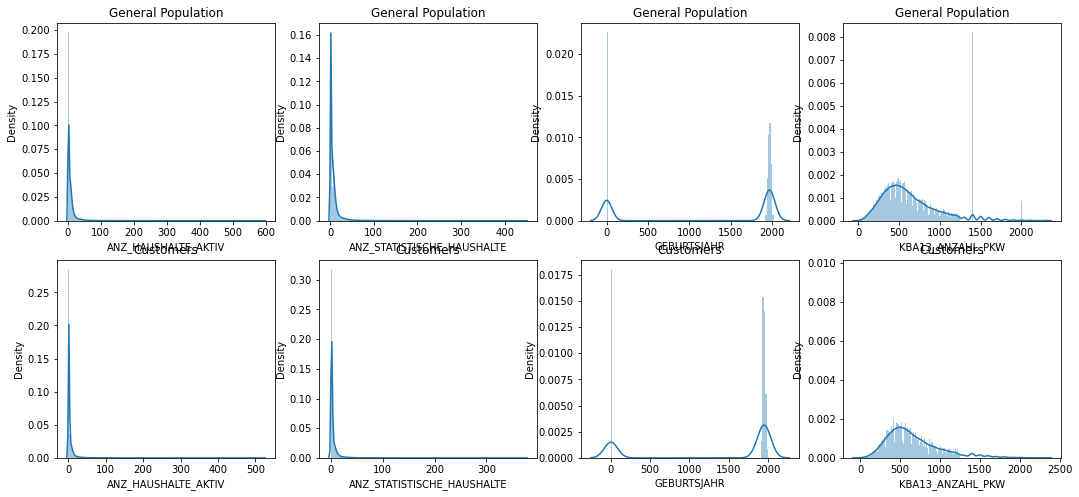

In [27]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
ax1 = f.add_subplot(241)
_ = ax1.set_title("General Population")
_ = sns.distplot(genpop['ANZ_HAUSHALTE_AKTIV'], bins=292)
ax2 = f.add_subplot(242)
_ = ax2.set_title("General Population")
_ = sns.distplot(genpop['ANZ_STATISTISCHE_HAUSHALTE'], bins=268)
ax3 = f.add_subplot(243)
_ = ax3.set_title("General Population")
_ = sns.distplot(genpop['GEBURTSJAHR'], bins=117)
ax4 = f.add_subplot(244)
_ = ax4.set_title("General Population")
_ = sns.distplot(genpop['KBA13_ANZAHL_PKW'], bins=1261)
ax5 = f.add_subplot(245)
_ = ax5.set_title("Customers")
_ = sns.distplot(kunden['ANZ_HAUSHALTE_AKTIV'], bins=216)
ax6 = f.add_subplot(246)
_ = ax6.set_title("Customers")
_ = sns.distplot(kunden['ANZ_STATISTISCHE_HAUSHALTE'], bins=214)
ax7 = f.add_subplot(247)
_ = ax7.set_title("Customers")
_ = sns.distplot(kunden['GEBURTSJAHR'], bins=113)
ax8 = f.add_subplot(248)
_ = ax8.set_title("Customers")
_ = sns.distplot(kunden['KBA13_ANZAHL_PKW'], bins=1250)
_ = plt.show()

The feature **_`GEBURTSJAHR`_**, German for _Year Of Birth_, is clearly not bimodal, and much less with individuals being born in the year **_0_**. This appears to be a case where rather than leaving the entry blank, **_missing_**, the data collector instead, decided to assign it to the **_unknown_** slot. The temptation is there to impute these _unknowns_ as we did with missing data. There are two problems with such an approach; on the one hand, we must treat unknowns consistently, meaning that if we treat the unknowns of **_`GEBURTSJAHR`_** as imputable, we must also do so for the unknowns of the other features, at least for other numerical features. On the other hand, if the data was not collected because an individual was unwilling to respond to a survey question, then imputing will introduce the bias of treating a certain part of the population - those unwilling to reveal their age, as being representative of the entire dataset. We need to have a closer inspection of this feature, and draw conclusions as to what course to set regarding similar unknowns in the dataset.

The overwhelming majority of features are categorical, and contain a slot that catches `unknown` quantities. The data collection is inconsistent with the unknowns, sometimes assigning them to the _0_ slot, and sometimes to the highest numbered slot. There is a temptation to unify unknowns and missing data together for imputation. We avoided this mixing based on the assumption that assigning a data point to the unknown slots was a conscious decission, i.e., data was available, but someone decided that none of the other slots was appropriate, as opposed to the unavailability of any data for that point, i.e., missing.

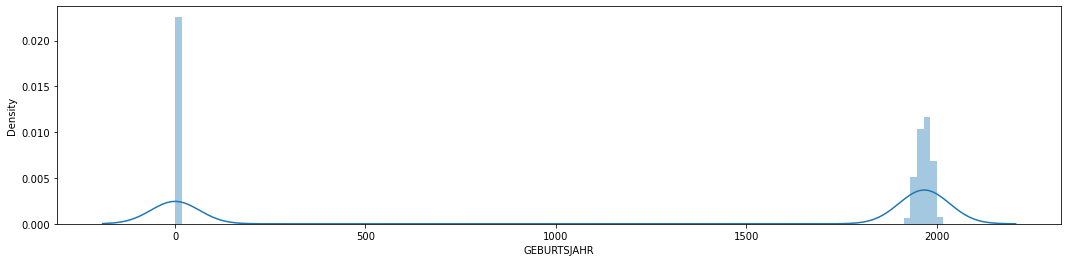

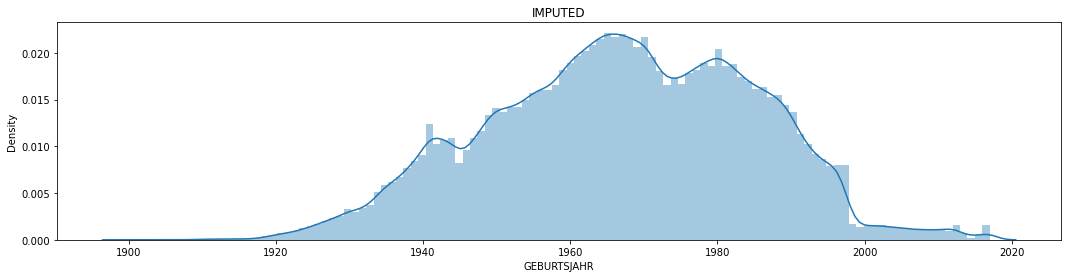

In [28]:
bins = genpop['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
genpop.loc[(genpop['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
impute_feature(genpop['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()

Upon closer inspection, the course to follow here is evident; imputing is the lesser of the two evils. We must remember the potential contamination of the data by extrapolating a sector of the population, possibly unwilling to reveal their age, as representing the entire population. We may get away with doing this one exceptional imputation case, being that it is indeed the only numerical feature exhibiting this problem.

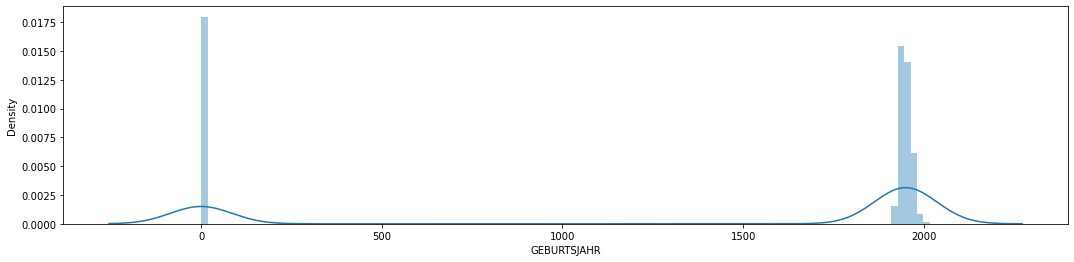

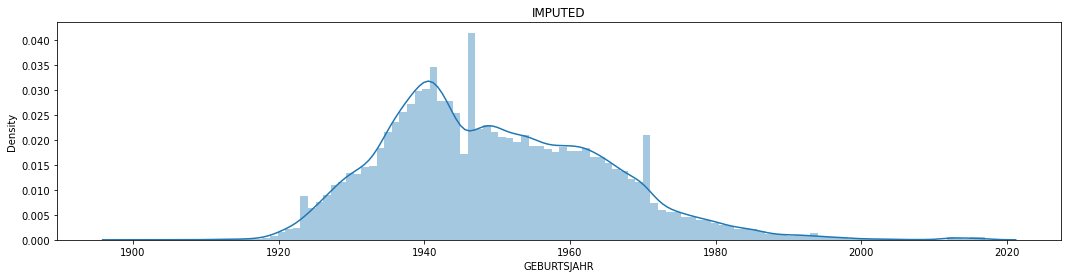

In [29]:
bins = kunden['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
kunden.loc[(kunden['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
impute_feature(kunden['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()

<br/>The feature **_`KBA13_ANZAHL_PKW`_**, has some outliers trailing the distribution. Entries below 1250 have granularity in units, but those beyond 1250 become coarse, with granularity in the hundreds, causing the entries to become outliers. Ideally we'd be spreading the spike values only around the right tail of the feature, using unit granularity as the rest of the feature data. We'll take the simpler approach of assigning these outliers to the other values in the feature by means of our imputation technique. 

In [30]:
genpop['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)

2300.0      615
2200.0      311
2100.0      662
2000.0     1211
1900.0     1462
1800.0     2640
1700.0     3831
1600.0     6181
1500.0     8382
1400.0    11812
1300.0     6484
1250.0      232
1249.0      144
1247.0       76
1246.0      175
Name: KBA13_ANZAHL_PKW, dtype: int64

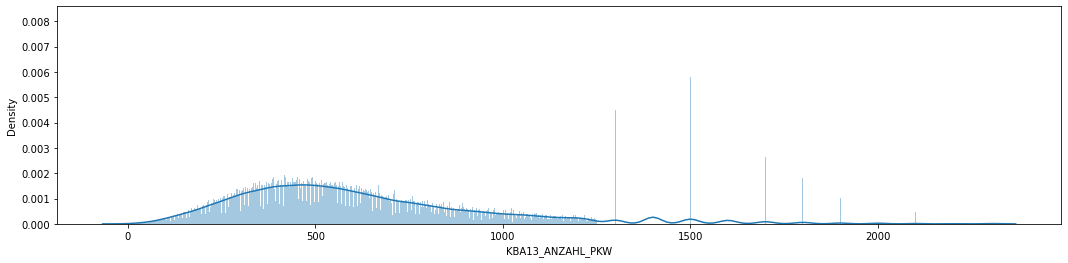

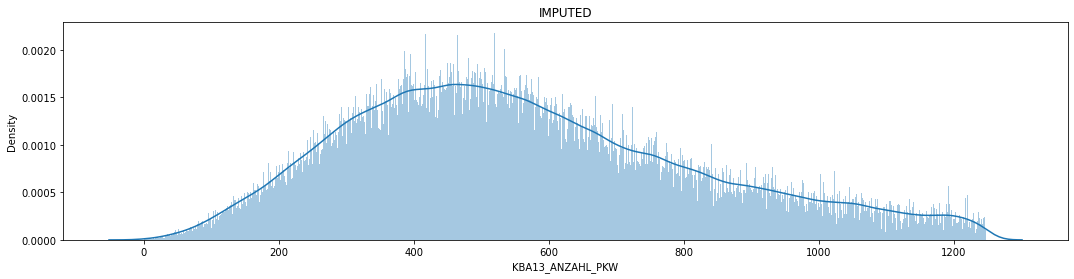

In [31]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['KBA13_ANZAHL_PKW'], bins=1261)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
genpop.loc[(genpop['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
impute_feature(genpop['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(genpop['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()

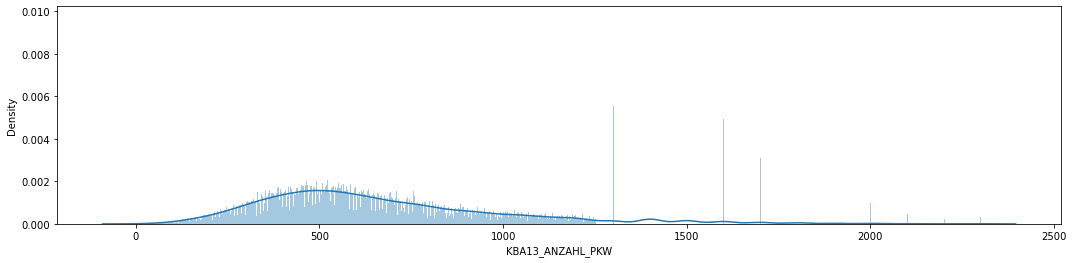

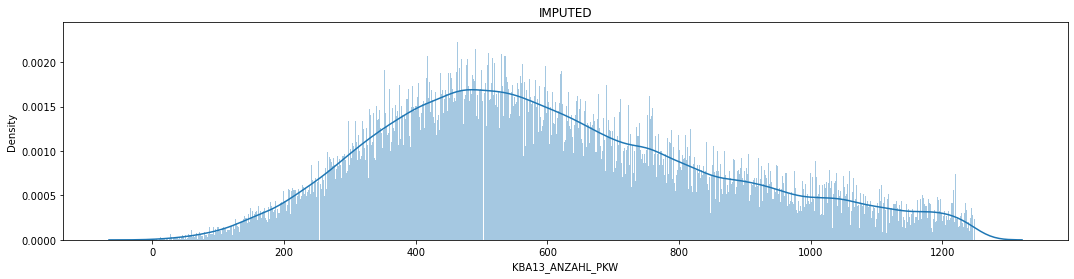

In [32]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['KBA13_ANZAHL_PKW'], bins=1261)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
kunden.loc[(kunden['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
impute_feature(kunden['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(kunden['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()

<br/><br/>

## Standardize - Normalize Data

One last processing step on the data is to standardize features by removing the mean and scaling to unit variance.
This process is necessary for the models we'll use later.

In [33]:
# Standardize, and keep numpy array as well as dataframe.
scaler = StandardScaler()
scaler = scaler.fit(genpop)
scaled_genpop = scaler.transform(genpop)
gp = DataFrame(scaled_genpop)

<br/><br/>
## Part 1: Customer Segmentation Report
- **Compare Datasets**
- **Principal Component Analysis**
- **K-Means Clustering**
- **Binary Classifier**

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<br/><br/>
## Compare Datasets
We'd like to gain some insight as to how the distribution of each individual feature is different across the two datasets. The code cells below show a function, **`compare_distros(feature)`** to compare distributions, and also a visualization of all features at once. We'll inspect the features from a big-picture, as well as a detailed perspective in order to build a list of those columns that appear to capture the bulk of what makes someone a customer.

In [34]:
warnings.filterwarnings('default')
interesting = []
def compare_distros(feature, relevant=False):
    '''Compare histograms a given feature from the General Population, as well as
       the Customer datasets. Do this both for the absolute data, and then the 
       standardized form.
    Args:    feature (String): name of the feature in question
    Returns: None
    '''
    global interesting
    if relevant:
        if feature not in interesting:
            interesting.append(feature)
        print(interesting)
        print("Added " + feature)
    else:
        print(interesting)

    f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    _ = ax1.set_title(feature + " Absolute")
    _ = plt.hist(genpop[feature], label='Gen Pop')
    _ = plt.hist(kunden[feature], label='Customer')
    _ = plt.legend(loc='upper right')

/Users/hec/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


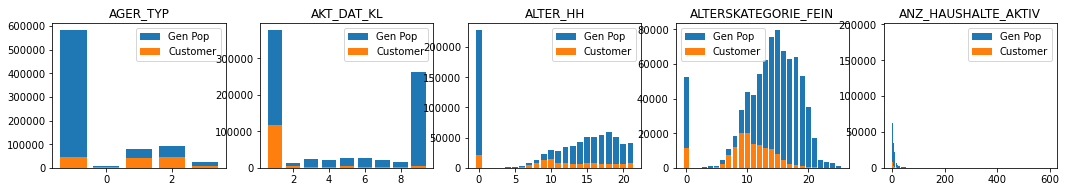

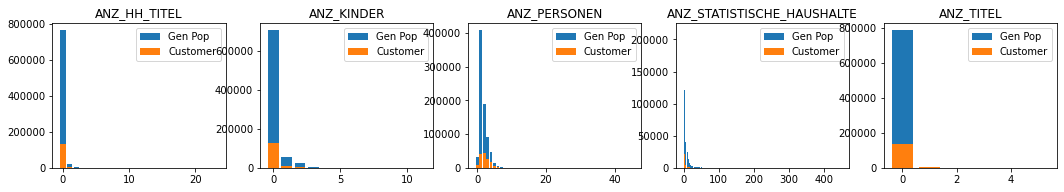

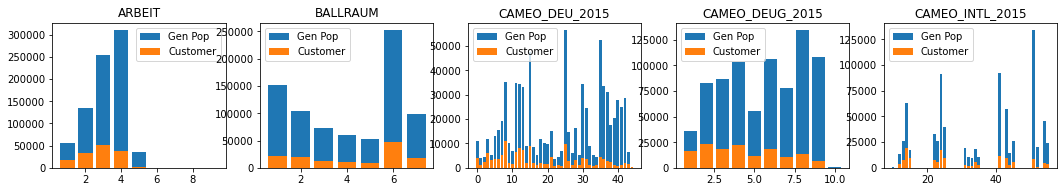

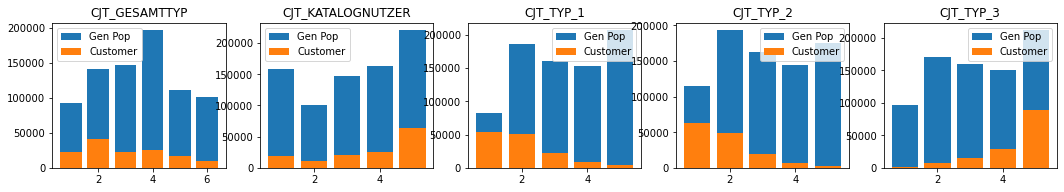

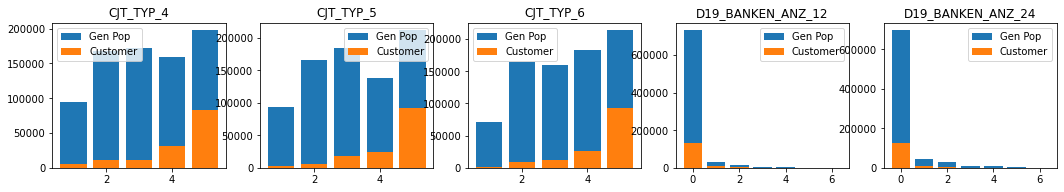

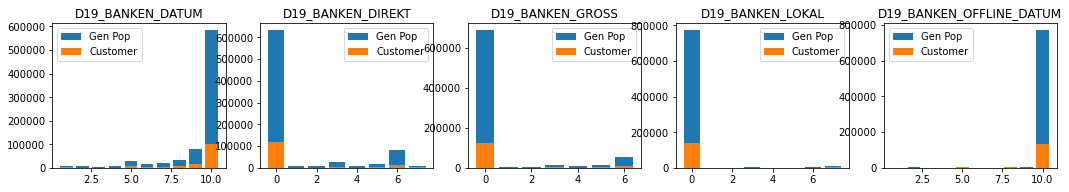

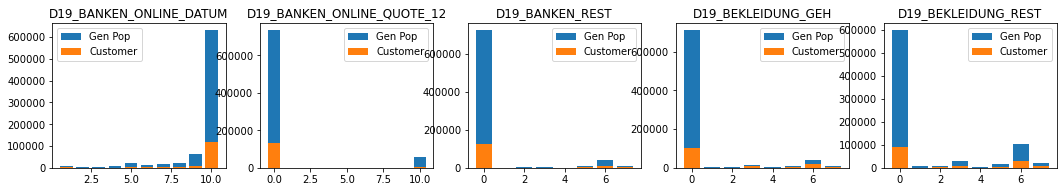

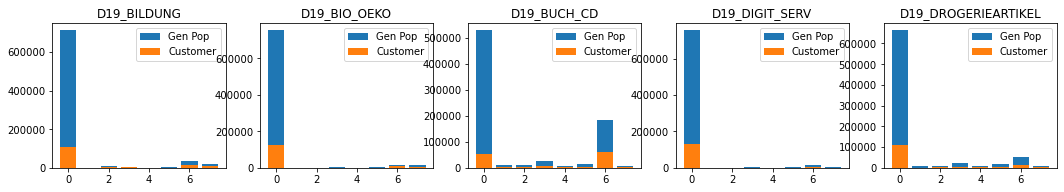

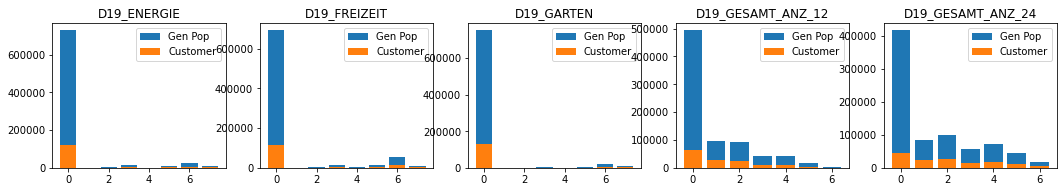

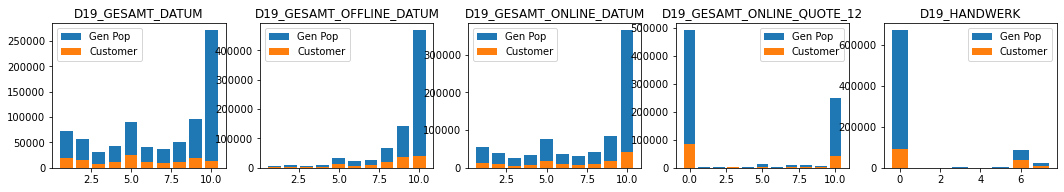

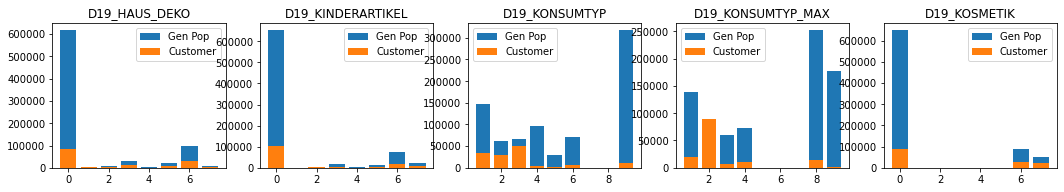

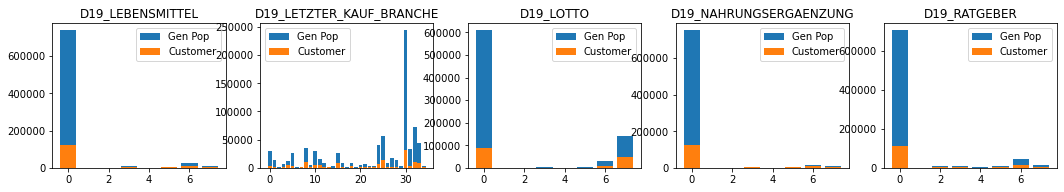

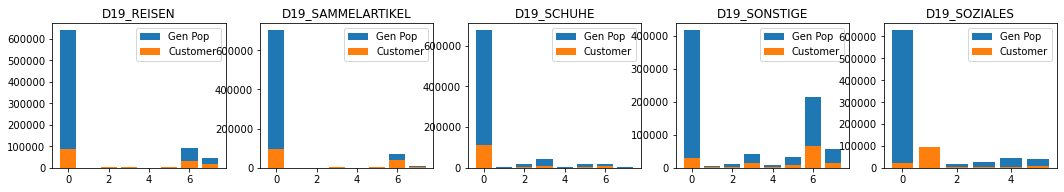

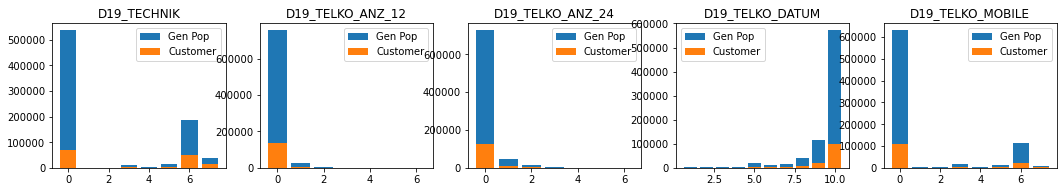

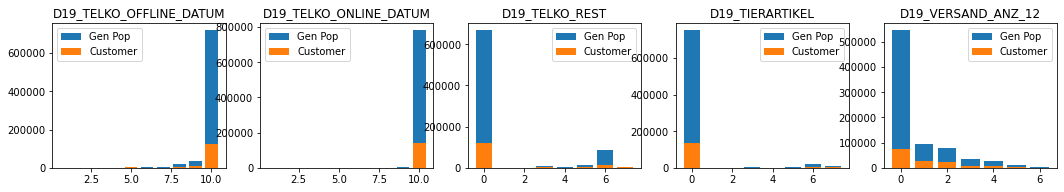

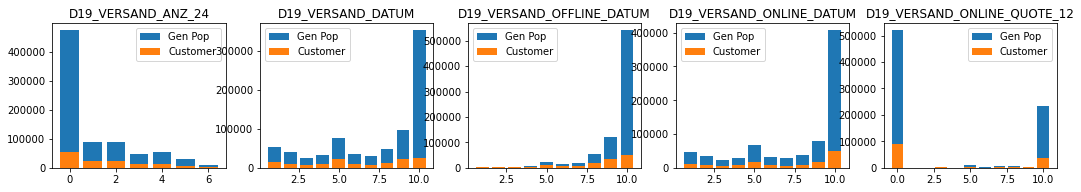

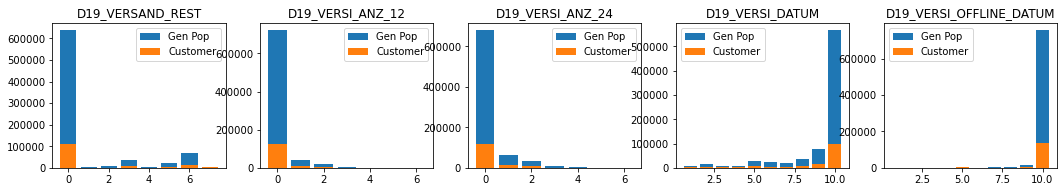

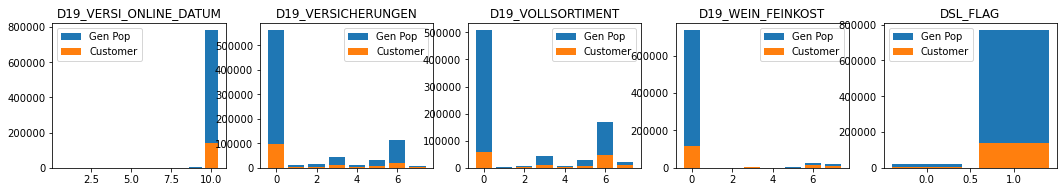

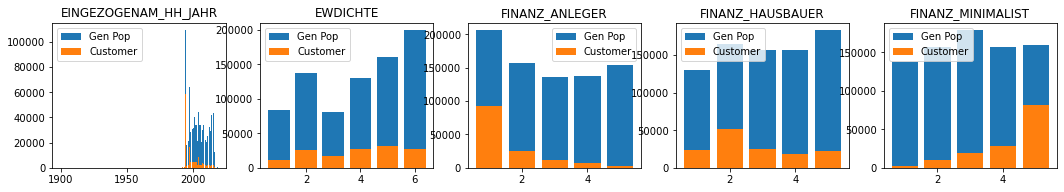

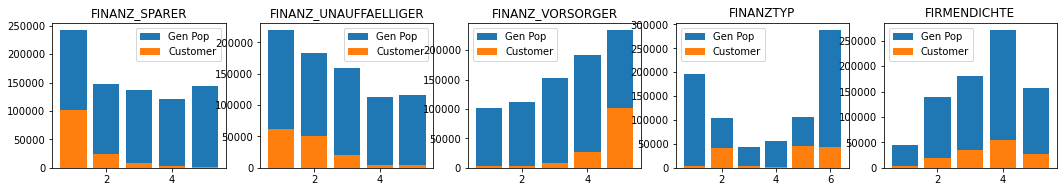

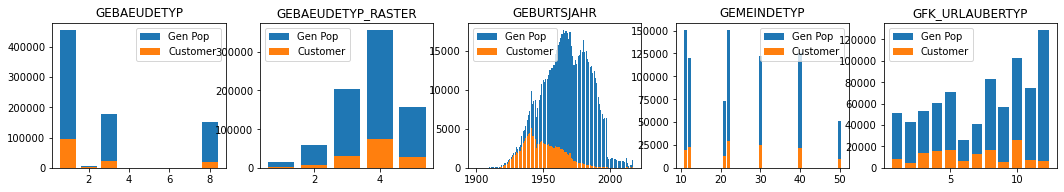

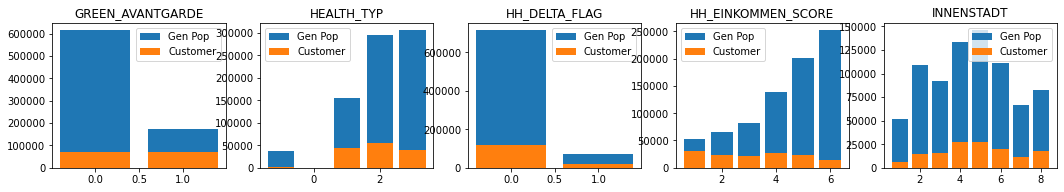

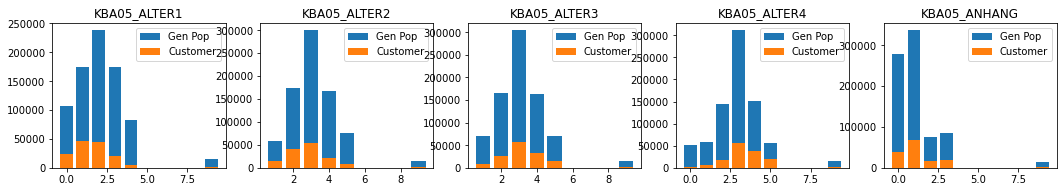

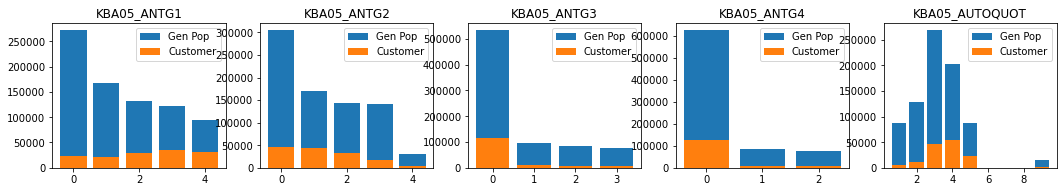

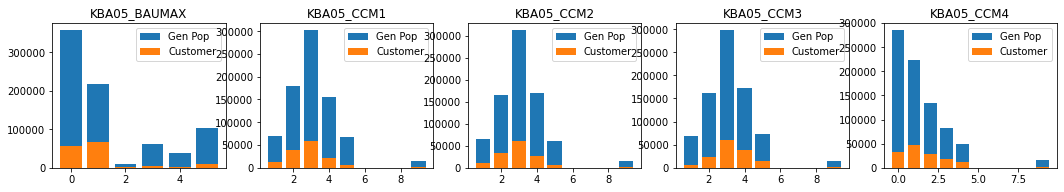

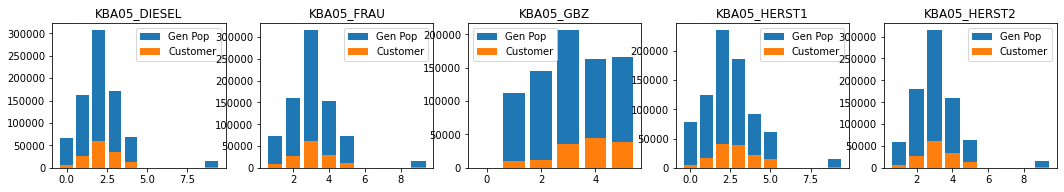

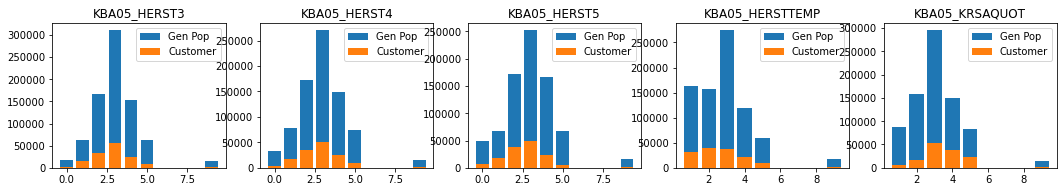

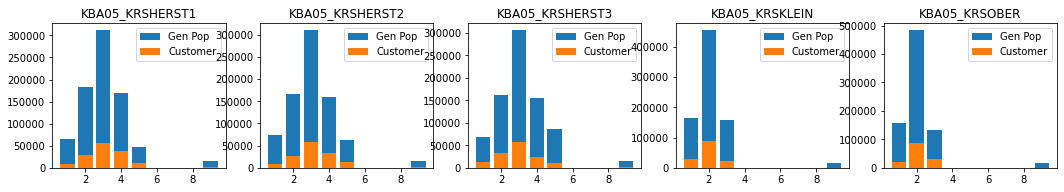

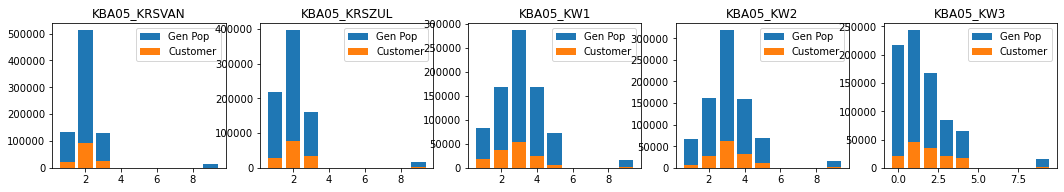

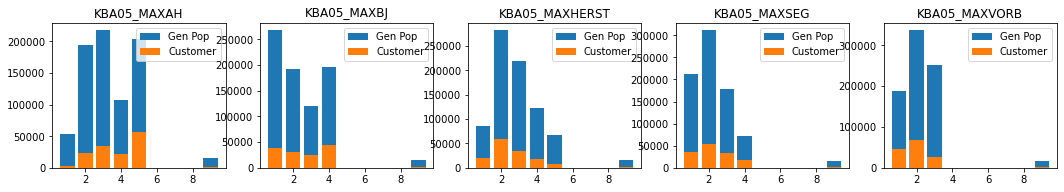

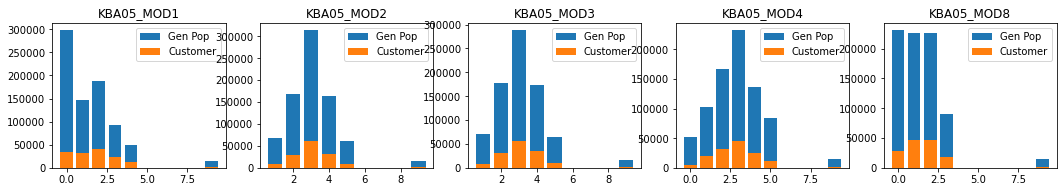

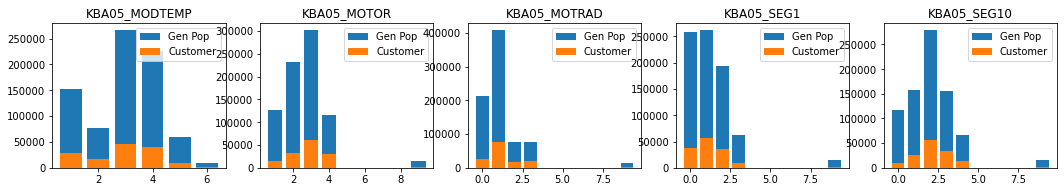

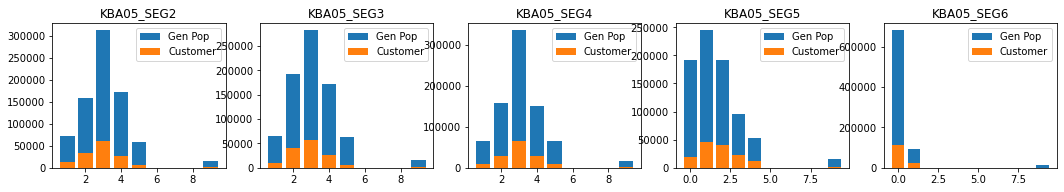

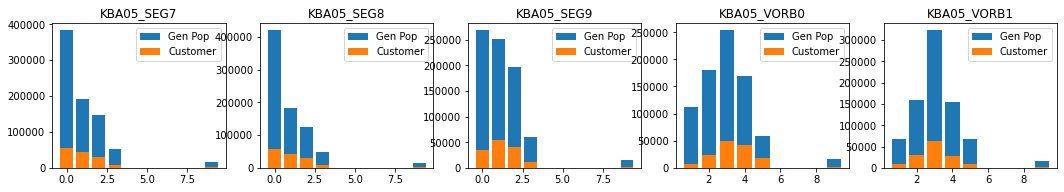

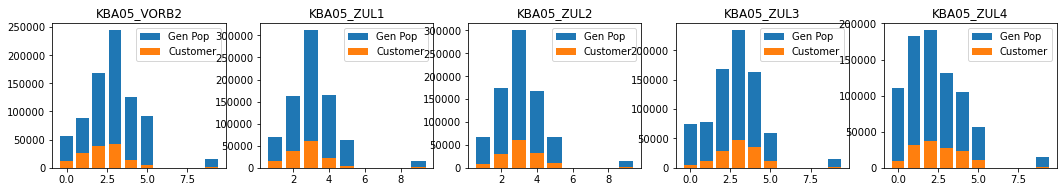

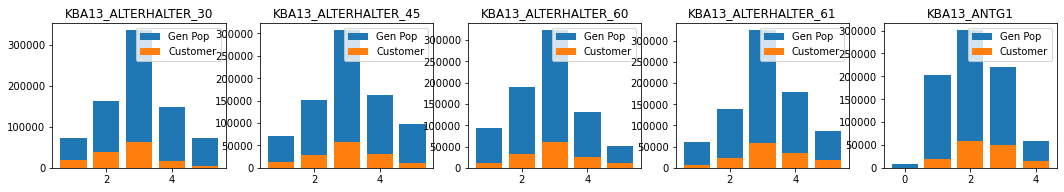

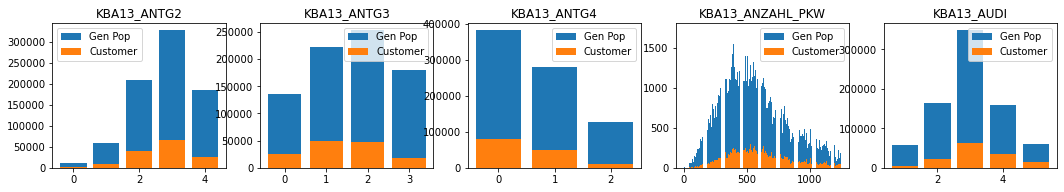

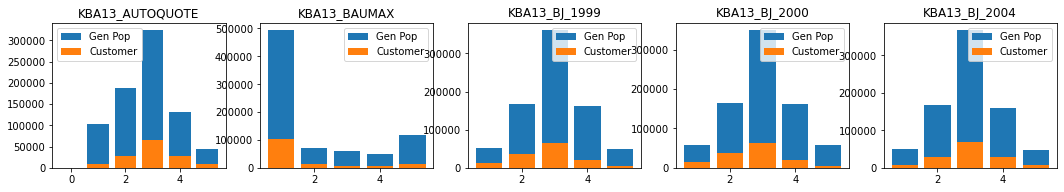

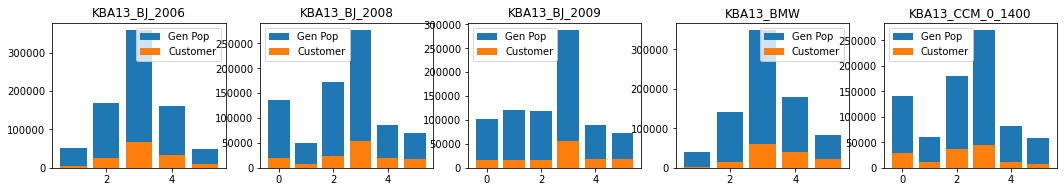

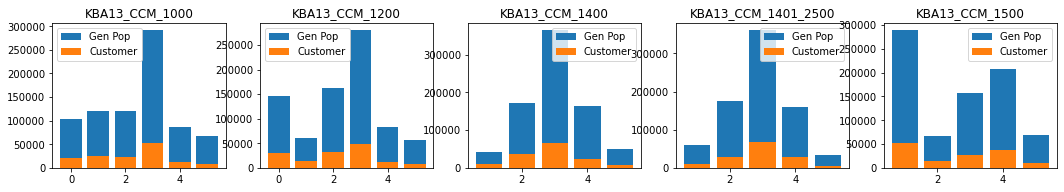

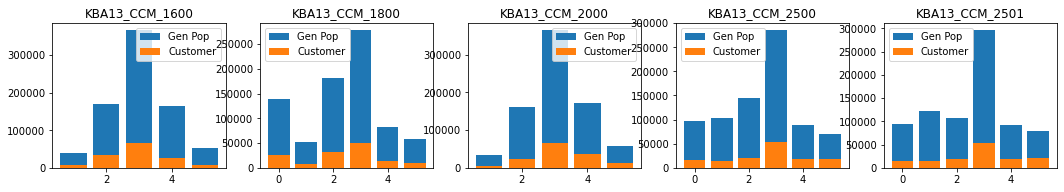

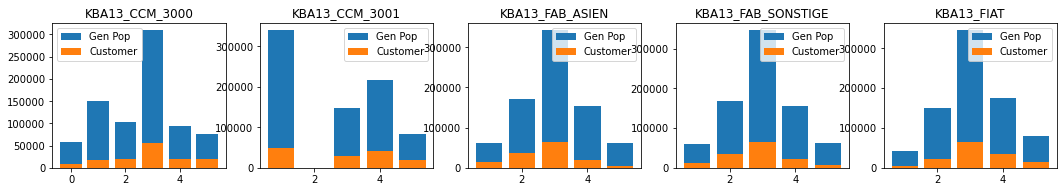

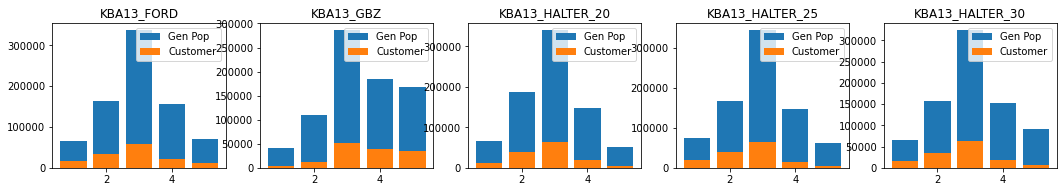

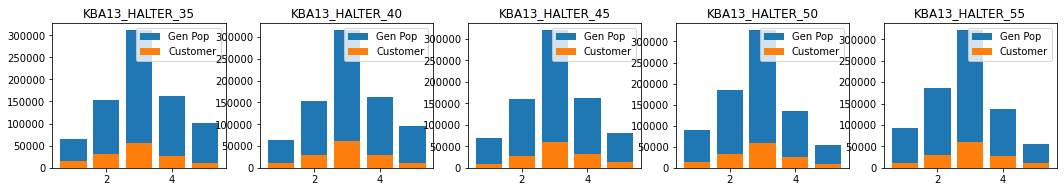

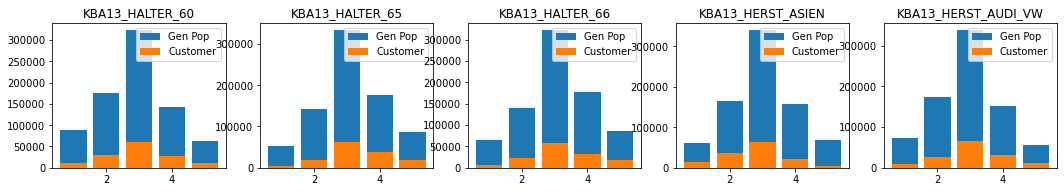

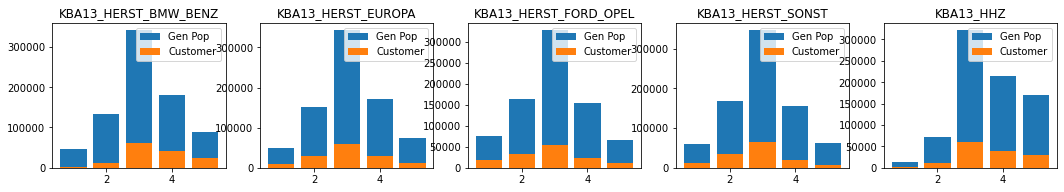

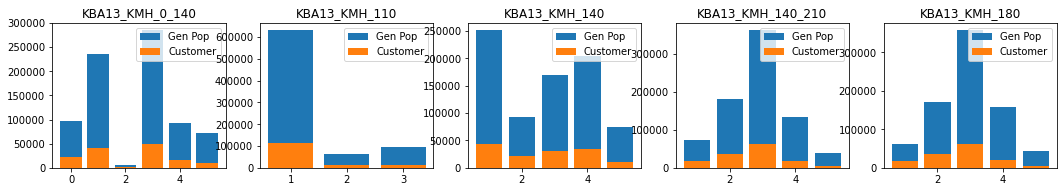

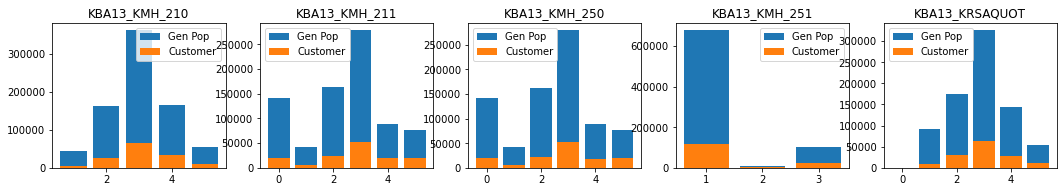

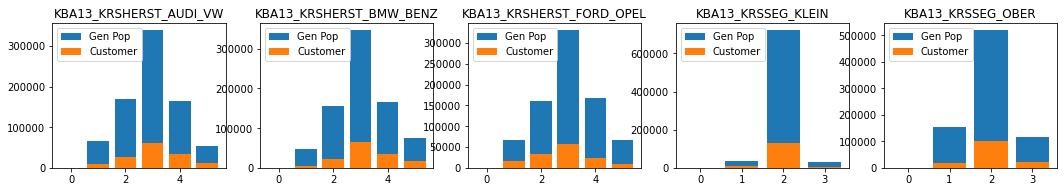

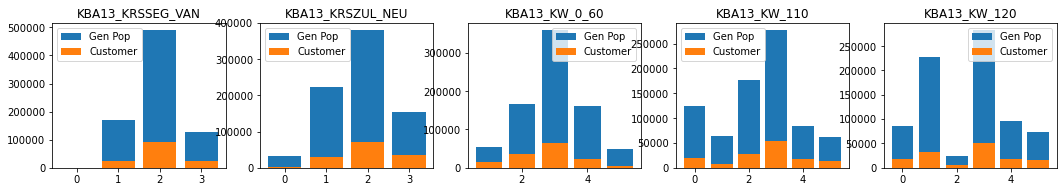

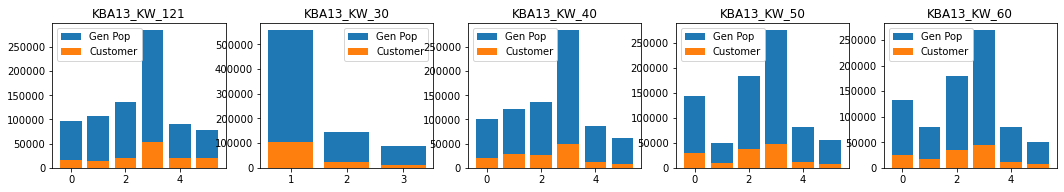

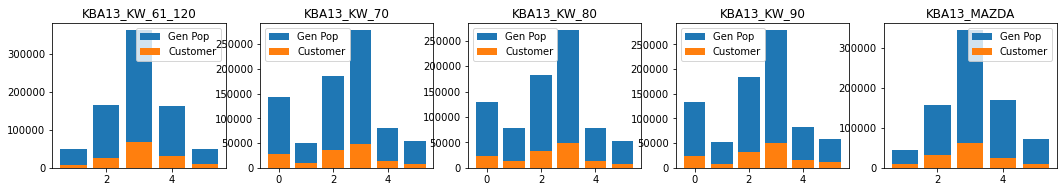

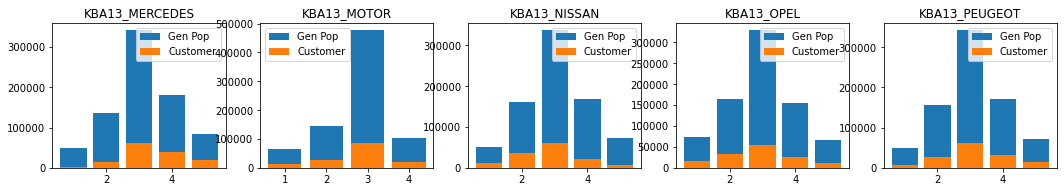

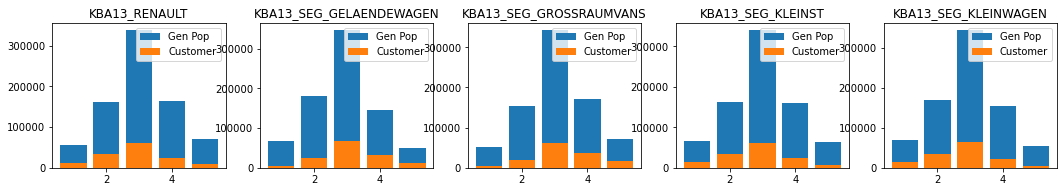

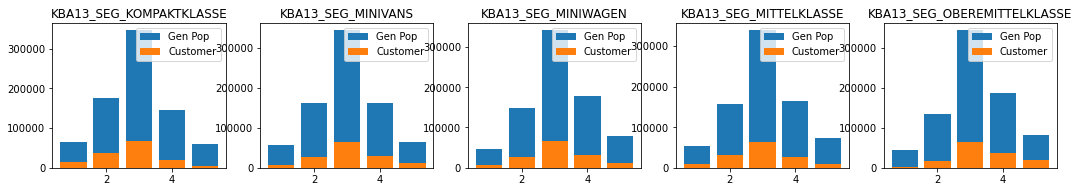

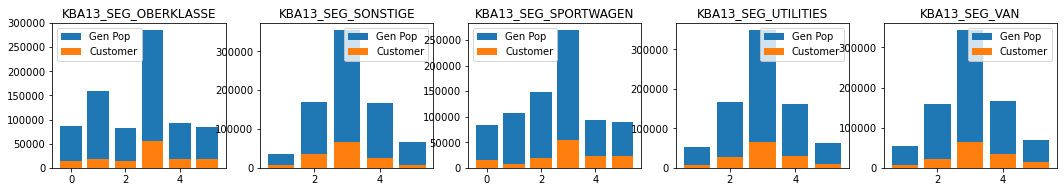

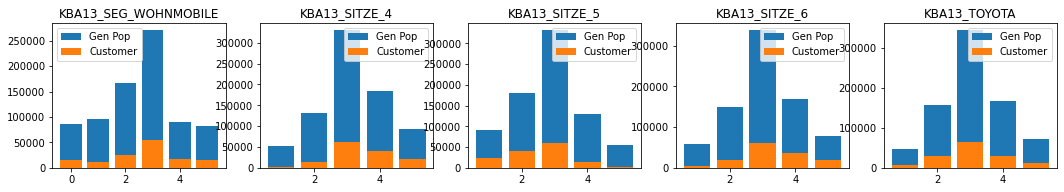

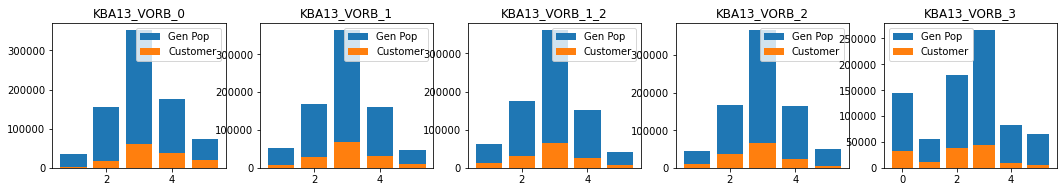

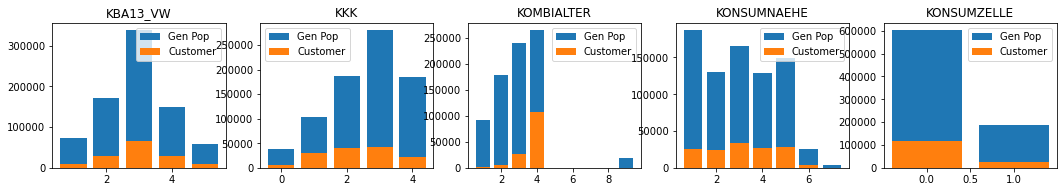

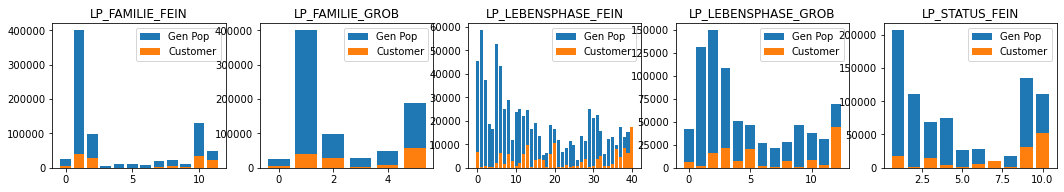

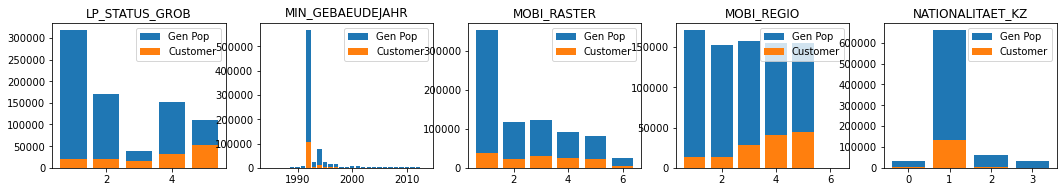

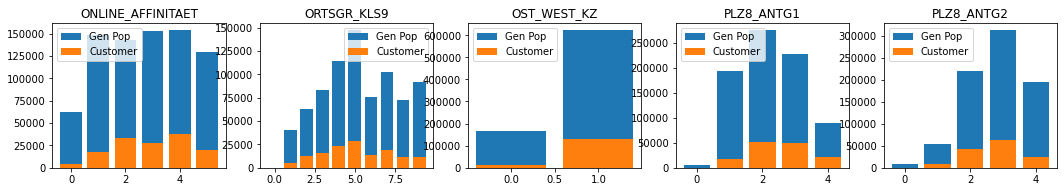

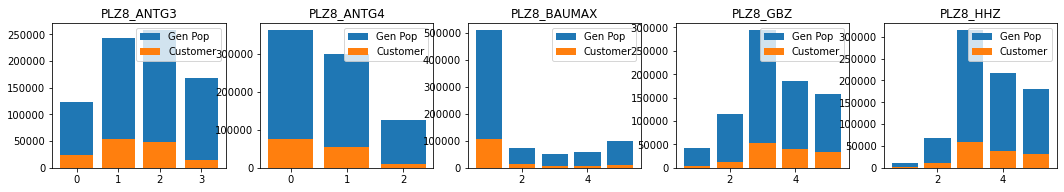

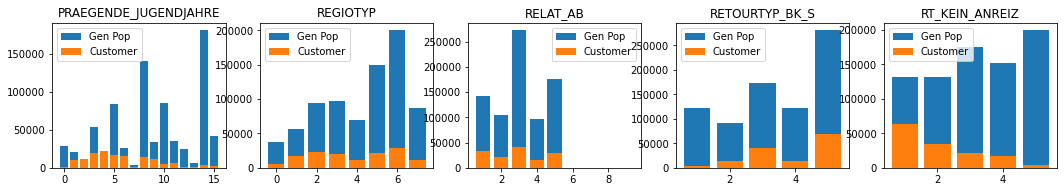

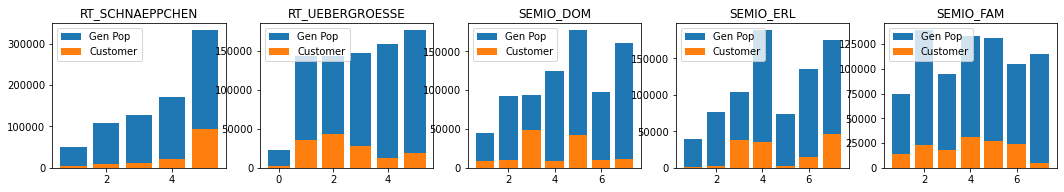

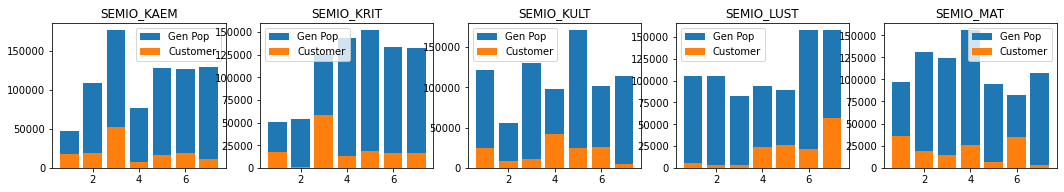

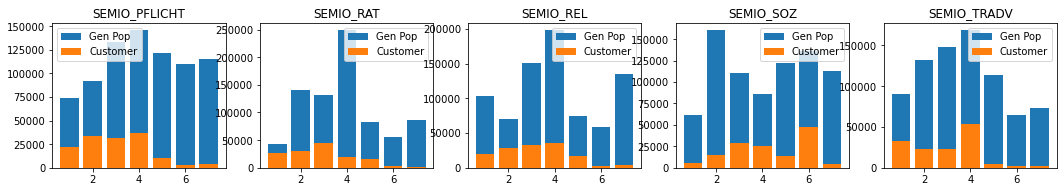

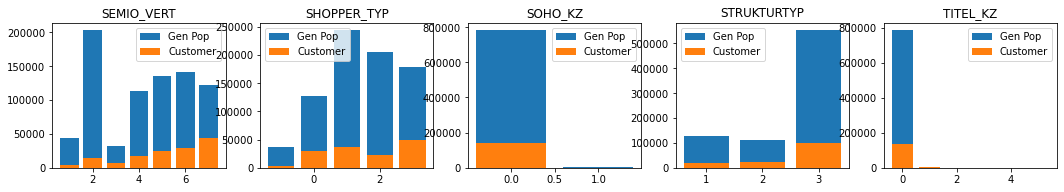

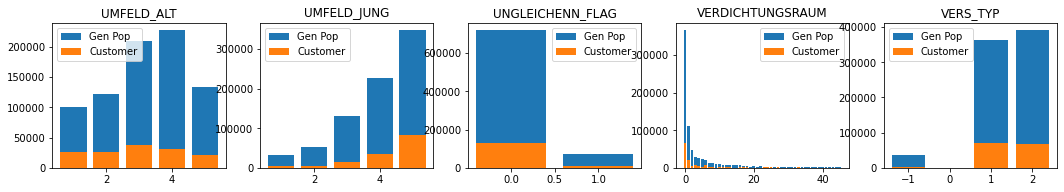

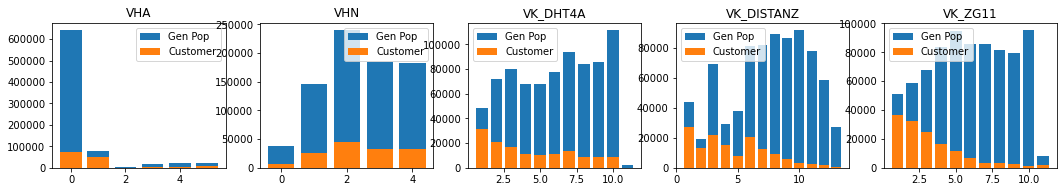

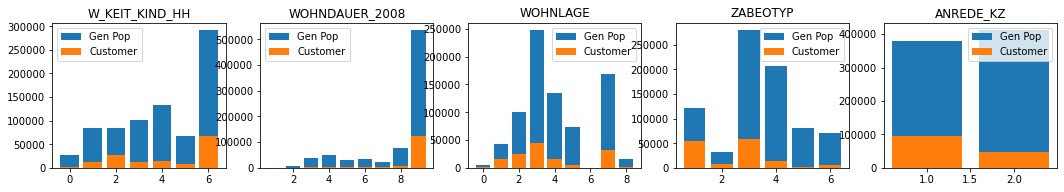

IndexError: list index out of range

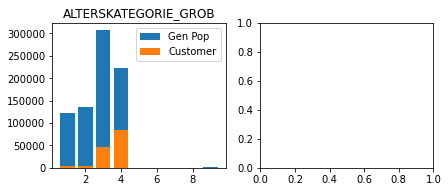

In [35]:
# Observe all features of the General Population vs Customer datasets, all at once.
# Then pinpoint any marked differences using compare_distros() interactively int the code cell below.
genpop_list = list(genpop.columns)
for col in range(0, genpop.shape[1], 5):
    f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/3))
    ax1 = f.add_subplot(151)
    _ = ax1.set_title(genpop_list[col])
    _ = plt.bar(genpop[genpop_list[col]].value_counts().sort_index().index, genpop[genpop_list[col]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col]].value_counts().sort_index().index, kunden[genpop_list[col]].value_counts().sort_index().values, label='Customer')
    _ = ax1.legend()

    #_ = sns.distplot(genpop[genpop_list[col]])
    ax2 = f.add_subplot(152)
    _ = ax2.set_title(genpop_list[col+1])
    _ = plt.bar(genpop[genpop_list[col+1]].value_counts().sort_index().index, genpop[genpop_list[col+1]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col+1]].value_counts().sort_index().index, kunden[genpop_list[col+1]].value_counts().sort_index().values, label='Customer')
    _ = ax2.legend()

    ax3 = f.add_subplot(153)
    _ = ax3.set_title(genpop_list[col+2])
    _ = plt.bar(genpop[genpop_list[col+2]].value_counts().sort_index().index, genpop[genpop_list[col+2]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col+2]].value_counts().sort_index().index, kunden[genpop_list[col+2]].value_counts().sort_index().values, label='Customer')
    _ = ax3.legend()
    
    ax4 = f.add_subplot(154)
    _ = ax4.set_title(genpop_list[col+3])
    _ = plt.bar(genpop[genpop_list[col+3]].value_counts().sort_index().index, genpop[genpop_list[col+3]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col+3]].value_counts().sort_index().index, kunden[genpop_list[col+3]].value_counts().sort_index().values, label='Customer')
    _ = ax4.legend()
    
    ax5 = f.add_subplot(155)
    _ = ax5.set_title(genpop_list[col+4])
    _ = plt.bar(genpop[genpop_list[col+4]].value_counts().sort_index().index, genpop[genpop_list[col+4]].value_counts().sort_index().values, label='Gen Pop')
    _ = plt.bar(kunden[genpop_list[col+4]].value_counts().sort_index().index, kunden[genpop_list[col+4]].value_counts().sort_index().values, label='Customer')
    _ = ax5.legend()

    _ = plt.show()

In [36]:
# Play around with the column names to visualize the similarities, and differences.
_ = interact(compare_distros, feature=widgets.Dropdown(options=list(genpop.columns), description='Feature'), relevant=widgets.Checkbox(description='Add to List'))

interactive(children=(Dropdown(description='Feature', options=('AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKA…

The main differences after visualizing feature distributions occur for the following columns:`['ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_KONSUMTYP_MAX', 'D19_SOZIALES', 'EINGEZOGENAM_HH_JAHR', 'EWDICHTE', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZTYP', 'GEBURTSJAHR', 'GEMEINDETYP', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_AUTOQUOT', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MOBI_RASTER', 'MOBI_REGIO', 'PRAEGENDE_JUGENDJAHRE', 'RT_KEIN_ANREIZ', 'RT_UEBERGROESSE', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_SOZ', 'SEMIO_VERT', 'SHOPPER_TYP', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ']`

What follows is a brief description of how the customer distribution of each of the features of interest distinguishes itself from the general population:
- **ALTER_HH, GEBURTSJAHR:** Whereas the general population is crowded by post-war individuals ( values 10 or higher in **ALTER_HH** ), the customers' distribution appears more uniform and slightly modal around value 10, indicating people born between 1925 and 1960 approximately. The same pattern is revealed by the **GEBURTSJAHR** (birth year).
- **ALTERSKATEGORIE_FEIN:** Customers appear more tightly packed around value 10.
- **CAMEO_DEU_2015:** Customers distributed uniformly while the general population has more representation by "Powershopping Families", "Coffee Riders", and "Multi-cultural".
- **CAMEO_DEUG_2015 & CAMEO_INTL_2015:** Customer distributions are more uniform across categories.
- **CJT_GESAMTTYP, CJT_TYP_1, and CJT_TYP_2:** Decreasing amount of customers in the higher values.
- **CJT_TYP_3, CJT_TYP_4, CJT_TYP_5, and CJT_TYP_6 :** Increasing amount of customers in the higher values.
- **D19_KONSUMTYP_MAX:** Most customers are of **_Versatile_** consumption type.
- **D19_SOZIALES:** Customers mostly of category value "1".
- **EINGEZOGENAM_HH_JAHR:** Most customers 'Eingezogen' i.e., moved in mostly in the 1990's, and decreasingly so with time.
- **EWDICHTE, GEMEINDETYP, HEALTH_TYP, HH_EINKOMMEN_SCORE:** Uniform across population densities, type of communities, health typology, income score.
- **FINANZ_ANLEGER, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZTYP:** Very highly involved in saving and investing.
- **INNENSTADT:** Customers live mostly between 10 and 30 Km away from the city centre.
- **KBA05_AUTOQUOT:** Customers have slightly higher share of cars per household.
- **LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB:** Customers come from varied income backgrounds, but are mostly advanced age individuals.
- **LP_STATUS_FEIN, LP_STATUS_GROB:** Other things being equal, customers tend to be classified as top earners.
- **MOBI_RASTER, MOBI_REGIO:** Customers mobility is uniform or low inclined.
- **PRAEGENDE_JUGENDJAHRE:** Customers come mostly from the 50's and 60's dominating youth movements. 
- **RT_KEIN_ANREIZ, RT_UEBERGROESSE:** Customers trends on these two features are opposite of general population.
- **SEMIO_DOM, SEMIO_KRIT, SEMIO_SOZ, and SEMIO_VERT:** Customer personality affinity distributions markedly different from general population.
- **SHOPPER_TYP:** Uniformly distributed.
- **VK_DHT4A, VK_DISTANZ, and VK_ZG11:** Customer distributions markedly different from general population.
- **ANREDE_KZ:** Slightly higher proportion of males to females in the customers makeup.
<br/><br/>
<font color='blue'>The overall characterization of the differences in features' distributions of the customer and general population datasets shows customers to be older (1950's onward), sedentary, of versatile consumption type, heavily into saving or investing money, suburban, with multiple cars in household, mostly top earners of advanced age, and with a slightly heavier male presence. </font>

<br/><br/>
## Principal Component Analysis

We'd like to reduce the dimensionality of our data, while retaining the principal components, i.e., the weighted linear combinations of features that are linearly independent and account for the largest variability in the data. Briefly, we want the features with the most variance in the dataset! 

We’ll use sklearn's IncrementalPCA class for linear dimensionality reduction using `Singular Value Decomposition`. We'll first fit an IncrementalPCA object with the totality of the features to familiarize ourselves with the pattern in retained variance. We'll then examine the fraction of variance explained by each principal component, and plot the cumulative values using the function  **`show_pca(coeffs, given_PCA, feats=10)`** in the code cell below. This function allows us to visualize the feature weights of any of the PCA components to try and understand their meaning in terms of the original data features. The auxiliary function **`pca_features(given_PCA, feats=5)`** returns the same information as numbers.

In [37]:
def pca_features(given_PCA, feats=5):
    '''For a given PCA component, out of N_COMPONENTS=355, return the main features and weights.
    Args:    given_PCA(integer, range 0 to N_COMPONENTS=355): The PCA component to analyze
             feats(integer, default 5): Number of features to return, from largest to smallest
                                             in an absolute value sense.
    Returns: (DataFrame): List of Features and Weights with most impact on the given_PCA
    '''
    cols = genpop.columns.values
    ipca_df = DataFrame(ipca_explore.components_).iloc[given_PCA]
    komponent = DataFrame(list(zip(cols, ipca_df)), columns=['Original Data Feature', 'Weights'])
    komponent['Absolute']=komponent['Weights'].apply(lambda x: np.abs(x))
    return komponent.sort_values('Absolute', ascending=False).head(feats)
    
def show_pca(coeffs, given_PCA, feats=10):
    '''For a given PCA component, out of N_COMPONENTS=355, show its makeup in terms of feature weights,
    as well as the cumulative variance retained by all PCA components up to and including this one.
    The feature weights (positive or negative), are sorted by absolute value and displayed interactively.
    A second plot showing the cumulative variance retained vs. number of components is shown alongside.
    Args:    coeffs(DataFrame): Feature coefficients for each PCA component. 
             given_PCA(integer, range 0 to N_COMPONENTS=355): The PCA component to analyze
             feats(integer, default 10): Number of features to display, from largest to smallest
                                             in an absolute value sense.
    Returns: None
    '''
    
    show_features = pca_features(given_PCA, feats)
    f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
    ax1 = f.add_subplot(121)
    ax1 = plt.suptitle("Change Component & Number of Features with the sliders")
    ax1 = sns.barplot(data=show_features, x="Weights", y="Original Data Feature", palette="Blues_d")
    ax1.set_title("PCA Component {} Makeup @ {}% Cumulative Variance".\
                 format(given_PCA, round(100 * coeffs.explained_variance_ratio_.cumsum()[given_PCA]     ) ))
    ax2 = f.add_subplot(122)
    _ = plt.title("Cumulative Variance - 90% with ~175 PCA Components")
    _ = plt.ylabel('Retained variance')
    _ = plt.xlabel('PCA Components')
    _ = plt.plot(np.cumsum(coeffs.explained_variance_ratio_))

In [38]:
# Apply PCA to the General Population data.
N_COMPONENTS=355 # Features - 1
ipca_explore = IncrementalPCA(n_components=N_COMPONENTS, batch_size=N_COMPONENTS)

_ = ipca_explore.fit_transform(scaled_genpop)

_ = interact(show_pca, coeffs=fixed(ipca_explore),
             given_PCA=widgets.IntSlider(min=0, max=N_COMPONENTS-1, step=1, value=10),
             feats=widgets.IntSlider(min=5, max=50, step=1, value=10))

/Users/hec/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/Users/hec/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


interactive(children=(IntSlider(value=10, description='given_PCA', max=354), IntSlider(value=10, description='…

The PCA analysis reveals that we can retain 90% of the variance in the data, if we keep 175 'Component Space Features'. Hence, we can reduce dimensionality by about 50% at the cost of discarding about 10% of the uncorrelated information in the data, a reasonable trade-off.

The interactive sliders on the graph above can be used to produce a detailed view of the feature weights associated with a given PCA component. The weights, whether positive, negative, large, or small, can be used to interpret their meaning in feature space. Here is a breakdown of the top three PCA Components:

**`PCA_0`** Results from `pca_features(0, 5)`

| Feature         | Weight      | Interpretation |
|-----------------|-------------|:---------------|
| MOBI_REGIO      | <span style='color:green'>+13.2% </span> | very low mobility |
| KBA13_ANTG1     | <span style='color:green'>+12.9% </span> | high share of some type of ANTG1?? cars within the zip code |
| PLZ8_ANTG1      | <span style='color:green'>+12.8% </span> | very high share of 1-2 family houses in zip Code |
| KBA13_ANTG3     | <span style='color:red'>  -12.8% </span> | low share of some type of ANTG3?? cars in the zip code  |
| PLZ8_ANTG3      | <span style='color:red'>  -12.8% </span> | low share of 6-10 family houses in zip code |

**`PCA_1`**  Results from `pca_features(1, 5)`

| Feature         | Weight      | Interpretation |
|-----------------|-------------|:---------------|
| KBA05_SEG6      | <span style='color:green'>+17.9% </span> | some share of upper class cars (BMW 7er etc.) in the microcell |
| KBA05_KRSOBER   | <span style='color:green'>+16.4% </span> | above average share of upper class cars (referred to the county average) |
| KBA05_KRSVAN    | <span style='color:green'>+16.1% </span> | above average share of vans (referred to the county average) |
| KBA05_KRSZUL    | <span style='color:green'>+16.0% </span> | above average share of newbuilt cars (referred to the county average) |
| KBA05_ANHANG    | <span style='color:green'>+15.4% </span> | very many share of trailers in the microcell |

**`PCA_2`**  Results from `pca_features(2, 5)`

| Feature         | Weight      | Interpretation |
|-----------------|-------------|:---------------|
| CJT_TYP_2               | <span style='color:green'>+15.9% </span> | customer journey typology 2 ?? |
| PRAEGENDE_JUGENDJAHRE   | <span style='color:green'>+15.9% </span> | hard to interpret which slot in this categorical variable: dominating movement in the person's youth (avantgarde or mainstream) |
| ONLINE_AFFINITAET       | <span style='color:green'>+15.5% </span> | very high online affinity |
| CJT_TYP_1               | <span style='color:green'>+15.4% </span> | customer journey typology 1 ?? |
| FINANZ_SPARER           | <span style='color:green'>+15.1% </span> | very low financial typology: money saver |

We now re-fit an IncrementalPCA instance with only 175 components, and perform the transformation to a reduced dimensionality dataset, namely **`gp_PCA`**, as shown in the code cell below. The code cell also shows a portion of the PCA components in terms of the original features' weights, and also a portion of the transformed General Population dataset.

In [39]:
# Re-apply PCA, selecting for number of components to retain.
REDUCED_DIM = 175
ipca = IncrementalPCA(n_components=REDUCED_DIM, batch_size=REDUCED_DIM)

_ = ipca.fit(scaled_genpop)
gp_PCA = ipca.transform(scaled_genpop)

# List the PCA components
print("\n\nPCA Components {}".format(DataFrame(ipca.components_).shape))
PCA_components = DataFrame(ipca.components_, columns = genpop.columns.values)
PCA_components.index =  ['PCA_{}'.format(i) for i in range(len(ipca.components_))]
PCA_components.head()

# List the PCA transformed General Population dataset.
print("\n\nReduced Dimensionality General Population Dataset {}".format(DataFrame(gp_PCA).shape))
gp_PCA_df = DataFrame(gp_PCA)
gp_PCA_df.head()

/Users/hec/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/hec/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/Users/hec/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




PCA Components (175, 356)


AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  CAMEO_DEU_2015  CAMEO_DEUG_2015  CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  D19_DROGERIEARTIKEL  D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  D19_GESAMT_ANZ_12  D19_GESAMT_ANZ_24  D19_GESAMT_DATUM  D19_GESAMT_OFFLINE_DATUM  D19_GESAMT_ONLINE_DATUM  D19_GESAMT_ONLINE_QUOTE_12  D19_HANDWERK  D19_HAUS_DEKO  D19_KINDERARTIKEL  D19_KONSUMTYP  D19_KONSUMTYP_MAX  D19_KOSMETIK  D19_LEBENSMITTEL  D19_LETZTER_KAUF_BRANCHE  D19_LOTTO  D19_NAHRUNGSERGAENZUNG  D19_RATGEBER  D19_REISEN  D19_SAMMELARTIKEL  D19_SCHUHE  D19_SONSTIGE  D19_SOZIALES  D19_TECHNIK  D19_TELKO_ANZ_12  D19_TELKO_ANZ_24  D19_TELKO_DATUM  D19_TELKO_MOBILE  D19_TELKO_OFFLINE_DATUM  D19_TELKO_ONLINE_DATUM  D19_TELKO_REST  D19_TIERARTIKEL  D19_VERSAND_ANZ_12  D19_VERSAND_ANZ_24  D19_VERSAND_DATUM  D19_VERSAND_OFFLINE_DATUM  D19_VERSAND_ONLINE_DATUM  D19_VERSAND_ONLINE_QUOTE_12  D19_VERSAND_REST  D19_VERSI_ANZ_12  D19_VERSI_ANZ_24  D19_VERSI_DATUM  D19_VERSI_OFFLINE_DATUM  D19_VERSI_ONLINE_DATUM  D19_VERSICHERUNGEN  D19_VOLLSORTIMENT  D19_WEIN_FEINKOST  DSL_FLAG  EINGEZOGENAM_HH_JAHR  EWDICHTE  FINANZ_ANLEGER  FINANZ_HAUSBAUER  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_UNAUFFAELLIGER  FINANZ_VORSORGER  FINANZTYP  FIRMENDICHTE  GEBAEUDETYP  GEBAEUDETYP_RASTER  GEBURTSJAHR  GEMEINDETYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  HH_DELTA_FLAG  HH_EINKOMMEN_SCORE  INNENSTADT  KBA05_ALTER1  KBA05_ALTER2  KBA05_ALTER3  KBA05_ALTER4  KBA05_ANHANG  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_AUTOQUOT  KBA05_BAUMAX  KBA05_CCM1  KBA05_CCM2  KBA05_CCM3  KBA05_CCM4  KBA05_DIESEL  KBA05_FRAU  KBA05_GBZ  KBA05_HERST1  KBA05_HERST2  KBA05_HERST3  KBA05_HERST4  KBA05_HERST5  KBA05_HERSTTEMP  KBA05_KRSAQUOT  KBA05_KRSHERST1  KBA05_KRSHERST2  KBA05_KRSHERST3  KBA05_KRSKLEIN  KBA05_KRSOBER  KBA05_KRSVAN  KBA05_KRSZUL  KBA05_KW1  KBA05_KW2  KBA05_KW3  KBA05_MAXAH  KBA05_MAXBJ  KBA05_MAXHERST  KBA05_MAXSEG  KBA05_MAXVORB  KBA05_MOD1  KBA05_MOD2  KBA05_MOD3  KBA05_MOD4  KBA05_MOD8  KBA05_MODTEMP  KBA05_MOTOR  KBA05_MOTRAD  KBA05_SEG1  KBA05_SEG10  KBA05_SEG2  KBA05_SEG3  KBA05_SEG4  KBA05_SEG5  KBA05_SEG6  KBA05_SEG7  KBA05_SEG8  KBA05_SEG9  KBA05_VORB0  KBA05_VORB1  KBA05_VORB2  KBA05_ZUL1  KBA05_ZUL2  KBA05_ZUL3  KBA05_ZUL4  KBA13_ALTERHALTER_30  KBA13_ALTERHALTER_45  KBA13_ALTERHALTER_60  KBA13_ALTERHALTER_61  KBA13_ANTG1  KBA13_ANTG2  KBA13_ANTG3  KBA13_ANTG4  KBA13_ANZAHL_PKW  KBA13_AUDI  KBA13_AUTOQUOTE  KBA13_BAUMAX  KBA13_BJ_1999  KBA13_BJ_2000  KBA13_BJ_2004  KBA13_BJ_2006  KBA13_BJ_2008  KBA13_BJ_2009  KBA13_BMW  KBA13_CCM_0_1400  KBA13_CCM_1000  KBA13_CCM_1200  KBA13_CCM_1400  KBA13_CCM_1401_2500  KBA13_CCM_1500  KBA13_CCM_1600  KBA13_CCM_1800  KBA13_CCM_2000  KBA13_CCM_2500  KBA13_CCM_2501  KBA13_CCM_3000  KBA13_CCM_3001  KBA13_FAB_ASIEN  KBA13_FAB_SONSTIGE  KBA13_FIAT  KBA13_FORD  KBA13_GBZ  KBA13_HALTER_20  KBA13_HALTER_25  KBA13_HALTER_30  KBA13_HALTER_35  KBA13_HALTER_40  KBA13_HALTER_45  KBA13_HALTER_50  KBA13_HALTER_55  KBA13_HALTER_60  KBA13_HALTER_65  KBA13_HALTER_66  KBA13_HERST_ASIEN  KBA13_HERST_AUDI_VW  KBA13_HERST_BMW_BENZ  KBA13_HERST_EUROPA  KBA13_HERST_FORD_OPEL  KBA13_HERST_SONST  KBA13_HHZ  KBA13_KMH_0_140  KBA13_KMH_110  KBA13_KMH_140  KBA13_KMH_140_210  KBA13_KMH_180  KBA13_KMH_210  KBA13_KMH_211  KBA13_KMH_250  KBA13_KMH_251  KBA13_KRSAQUOT  KBA13_KRSHERST_AUDI_VW  KBA13_KRSHERST_BMW_BENZ  KBA13_KRSHERST_FORD_OPEL  KBA13_KRSSEG_KLEIN  KBA13_KRSSEG_OBER  KBA13_KRSSEG_VAN  KBA13_KRSZUL_NEU  KBA13_KW_0_60  KBA13_



Reduced Dimensionality General Population Dataset (791957, 175)


0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        97        98        99        100       101       102       103       104       105       106       107       108       109       110       111       112       113       114       115       116       117       118       119       120       121       122       123       124       125       126       127       128       129       130       131       132       133       134       135       136       137       138       139       140       141       142       143       144       145       146       147       148       149       150       151       152       153       154       155       156       157       158       159       160       161       162       163       164       165       166       167       168       169       170       171       172       173       174
0 -4.480441 -2.178542  3.069266  4.624524  5.362477 -0.709091  2.175955 -2.350626  1.174134 -0.304270  2.049824 -1.773376  1.858470  3.527386  3.046657  0.281118  1.541432 -0.243896  0.938119  0.822100  0.514953  0.372364 -0.489460  4.368908  0.884530 -0.553840  1.767498 -0.716825 -1.116140 -0.878591 -2.856160  0.084169  0.976808 -0.639045  0.429610  0.269528  0.712024 -2.025551  2.744912  0.913855 -0.712329 -0.754432  0.625833  0.414340  1.613079  0.741943 -1.521414 -1.093091 -0.627177  0.772015  0.366601 -1.411222  1.261591  0.430897 -2.070572  0.620688 -0.293139 -0.399036 -0.493229 -0.026591 -1.384946  0.262635 -1.790547 -1.589202 -0.919655 -0.197750  0.775443 -1.467611  9.326477  4.110089 -3.403677 -0.752554 -0.235872 -0.534734 -0.608380  0.503010  0.472468  0.888346 -0.666607 -0.520443 -0.687123  0.790858  0.375262  1.094529  0.841389  0.778622 -0.376492 -0.415630 -0.639102 -1.072193  0.523747 -1.344646  0.771148  1.912482  1.506023 -1.866398  0.150153  0.566935 -0.417277 -1.402265 -0.264484 -0.089943 -0.130164  1.057163  0.128978 -1.357382  0.306630  0.240956 -0.527222 -0.766920 -0.255808  0.592591 -0.577181  0.075913 -0.164452 -0.533494  0.872901  0.712153  0.717239 -0.075124 -0.316177 -0.456752  0.352086 -0.065651  0.953054 -0.388499 -0.512208  0.155312 -0.504334  0.099185 -0.958317 -1.114007  0.219470 -0.193375  2.422268  0.569749 -0.831412 -1.146442 -0.515315 -0.075965 -0.692256  0.105828  0.290691  1.365166 -0.132556  0.182797  0.193411  1.209694  0.345962 -0.158256  0.426754  0.514818 -0.409155 -0.158975 -1.523693 -0.123860  1.649814  0.029952 -0.348404  0.645811  1.665943 -1.320409  0.284545  0.874047  1.244368 -0.560799 -0.551516 -0.805879 -0.807765  0.980164  0.009172  1.202848 -1.406775 -0.923526  0.992786
1  0.125873 -0.325911 -1.572802  3.797013  3.808623 -3.566399  3.824717  2.823346 -0.883261 -0.254299  0.335932  1.958875  0.967177 -2.687491 -0.762809  2.344642 -0.609317  1.876609  2.417472  0.124474  1.668609 -1.097651 -0.514853 -0.655385 -1.162937  0.703845 -1.136458 -0.864904  0.894093 -0.163198  0.692003 -0.591277 -2.627308 -0.937685  0.629171  0.252441 -0.046925  0.966042  0.895963 -0.906117  0.037527 -2.949003 -0.248729 -0.220498 -1.886394  0.863661 -0.460132 -0.308251 -0.919274  0.204357 -0

<br/><br/>
## K-Means Clustering

We now reduce the complexity of our analysis by applying clustering to the PCA transformed General Population dataset. The function **`centroid_inertias(df, kmax=20)`** in the code cell below, loops through different numbers of clusters to observe the effect on the average centroid distance. We'd like to choose a value of **`k`** such that this distance is low, but not so low that we end up with too thinly populated clusters. If we select a good value for **`k`**, points in a cluster are close to each other, the average centroid distance is low, and we have enough points in each cluster to achieve effective segmentation of the data.

k=2, 

/Users/hec/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


k=4, k=6, k=8, k=10, k=12, k=14, k=16, k=18, 

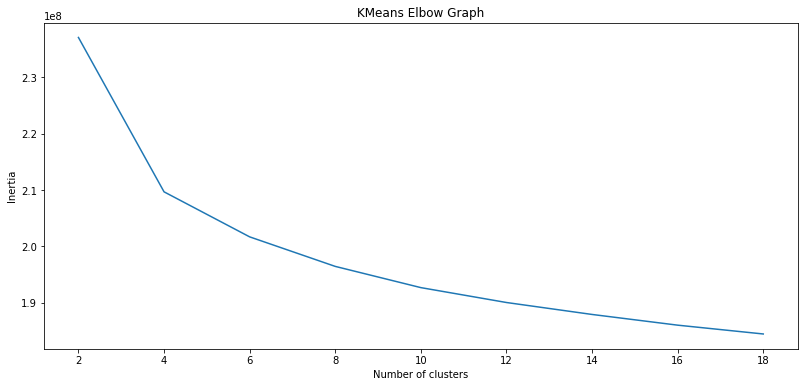

In [40]:
RANDOM_STATE = 403
def centroid_inertias(df, kmax=20):
    '''Iterate several cluster densities to examine the resulting reduction in average
    centroid distance.
    Args:    df (DataFrame): General Population, Customers, or Mailout datasets.
             kmax(Integer): Maximum number of clusters to try.
    Returns: None
    '''
    inertias = []
    for k in range(2, kmax, 2):
        print('k={}, '.format(k), end='')
        clusters = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        clusters.fit(df)
        inertias.append(clusters.inertia_)
    return inertias

inert = centroid_inertias(gp_PCA_df, kmax=20)

f = plt.figure(figsize=(FIG_WIDTH*.75, FIG_HEIGHT*.75))
x_range = [k for k in range(2, 20, 2)]
_ = plt.xticks(x_range)
_ = plt.plot(x_range, inert)
_ = plt.title('KMeans Elbow Graph')
_ = plt.xlabel('Number of clusters')
_ = plt.ylabel('Inertia')
_ = plt.show()

The graph above shows the average cluster centroid distance plotted against the number of clusters attempted. There is no clear elbow, but the rate at which the average centroid distance decreases is much less sharp beyond **`k = 10`**. Further reduction with higher **`k`** is only marginally better. 

The code cell below performs KMeans clustering on the General Population with 10 clusters. This code cell also carries out all the prior transformation steps on the Customer dataset that were performed on the General Population. The actual Clusters are also shown in terms of Principal Components.

In order to make meaningful comparisons, we take into account the different sizes of the datasets (GenPop=791957 vs. Customers=140889). The histograms below show the absolute and relative number of points per cluster in each dataset. Additionally, the bottom two graphs depict the main clusters for each of the datasets sorted by their density of points.

/Users/hec/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KMeans Clusters (10, 175)


PCA_0      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7     PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13    PCA_14    PCA_15    PCA_16    PCA_17    PCA_18    PCA_19    PCA_20    PCA_21    PCA_22    PCA_23    PCA_24    PCA_25    PCA_26    PCA_27    PCA_28    PCA_29    PCA_30    PCA_31    PCA_32    PCA_33    PCA_34    PCA_35    PCA_36    PCA_37    PCA_38    PCA_39    PCA_40    PCA_41    PCA_42    PCA_43    PCA_44    PCA_45    PCA_46    PCA_47    PCA_48    PCA_49    PCA_50    PCA_51    PCA_52    PCA_53    PCA_54    PCA_55    PCA_56    PCA_57    PCA_58    PCA_59    PCA_60    PCA_61    PCA_62    PCA_63    PCA_64    PCA_65    PCA_66    PCA_67    PCA_68    PCA_69    PCA_70    PCA_71    PCA_72    PCA_73    PCA_74    PCA_75    PCA_76    PCA_77    PCA_78    PCA_79    PCA_80    PCA_81    PCA_82    PCA_83    PCA_84    PCA_85    PCA_86    PCA_87    PCA_88    PCA_89    PCA_90    PCA_91    PCA_92    PCA_93    PCA_94    PCA_95    PCA_96    PCA_97    PCA_98    PCA_99   PCA_100   PCA_101   PCA_102   PCA_103   PCA_104   PCA_105   PCA_106   PCA_107   PCA_108   PCA_109   PCA_110   PCA_111   PCA_112   PCA_113   PCA_114   PCA_115   PCA_116   PCA_117   PCA_118   PCA_119   PCA_120   PCA_121   PCA_122   PCA_123   PCA_124   PCA_125   PCA_126   PCA_127   PCA_128   PCA_129   PCA_130   PCA_131   PCA_132   PCA_133   PCA_134   PCA_135   PCA_136   PCA_137   PCA_138   PCA_139   PCA_140   PCA_141   PCA_142   PCA_143   PCA_144   PCA_145   PCA_146   PCA_147   PCA_148   PCA_149   PCA_150   PCA_151   PCA_152   PCA_153   PCA_154   PCA_155   PCA_156   PCA_157   PCA_158   PCA_159   PCA_160   PCA_161   PCA_162   PCA_163   PCA_164   PCA_165   PCA_166   PCA_167   PCA_168   PCA_169   PCA_170   PCA_171   PCA_172   PCA_173   PCA_174
Cluster_0  0.761314   0.899202 -1.762302  6.731541 -1.432476 -1.385054 -0.162884  0.940296 -0.696357  0.425437 -0.208680 -1.212155 -0.190331 -0.255533 -0.036339 -0.040285 -0.220567  0.033316 -0.026262  0.255454 -0.133631 -0.017485  0.055712 -0.077260  0.105731  0.014184 -0.248972  0.055934 -0.164741  0.035052 -0.095444 -0.276681  0.055748 -0.110313  0.066197  0.060096 -0.032768  0.137896  0.119046 -0.000353  0.076758  0.052771  0.044308 -0.044348 -0.137005 -0.102729 -0.065275  0.074722 -0.034704  0.070465  0.099085  0.128130  0.071374 -0.081790 -0.043736  0.086037 -0.005525  0.019574  0.037846  0.033229 -0.126224  0.036644 -0.064282 -0.061129 -0.047816 -0.081632  0.052695  0.020360  0.027942 -0.000135  0.036917 -0.025950 -0.002774  0.051787 -0.086475 -0.129951  0.027276 -0.083307 -0.006782 -0.069090  0.053856  0.039488 -0.022672  0.028445  0.050949  0.018014  0.014309 -0.036208 -0.063808  0.027907 -0.009910 -0.082451 -0.148396 -0.038480 -0.021038  0.048571 -0.030791 -0.005346  0.011197  0.011493 -0.057941  0.033051  0.071060 -0.031865  0.034527 -0.040046 -0.007099  0.021916  0.027193  0.009445 -0.019463  0.029539 -0.035250  0.029894  0.012552 -0.058799  0.042105  0.003451 -0.016457 -0.011545 -0.037967  0.003449  0.032865 -0.026194  0.007104  0.031763  0.029190  0.012371 -0.004485  0.048506  0.010823 -0.047592 -0.030659 -0.044245  0.035057 -0.017798 -0.058780 -0.124083 -0.086164  0.014392 -0.004207 -0.011227  0.052568 -0.019645 -0.015131  0.029916  0.039550  0.033951 -0.000390 -0.006782 -0.000421 -0.004134 -0.011617  0.025222 -0.005133 -0.009174  0.003354 -0.000338  0.011971 -0.012314 -0.037220 -0.035878 -0.013994  0.054985  0.004965 -0.008378  0.007171 -0.018955 -0.016437 -0.001965 -0.036703  0.009122 -0.015358  0.059867 -0.016896
Cluster_1 -3.912278  -1.169940 -3.135693  0.002429 -2.056110  1.481782  0.379634  0.320078  0.558149 -0.950843  0.257938  0.217345  0.274956 -0.159924  0.064218 -0.335345 -0.033631 -0.035221  0.282036 -0.000873 -0.037401  0.103935  0.044907  0.107886  0.011036 -0.018996 -0.101036  0.140173 -0.068736  0.014762 -0.035692 -0.090793 -0.107959  0.008131 -0.105498  0.116222  0.208891 -0.117118 -0.151423  0.032630  0.059595 -0.154758  0.053952 -0.045007 -0.119390  0.054871  0.070481  0.054519 -

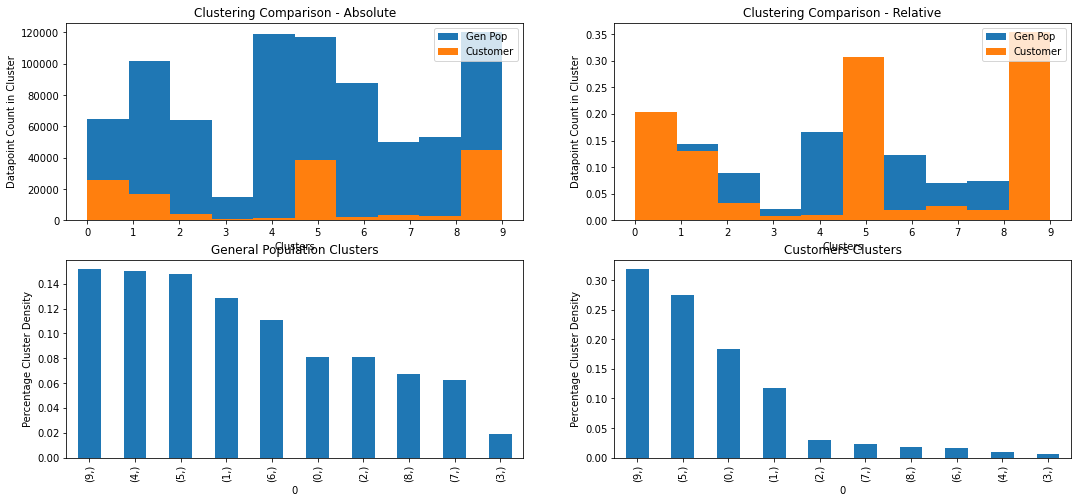

In [41]:
# Perform Clustering of the General Population
NUMBER_OF_CLUSTERS = 10
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=RANDOM_STATE)
clusters = kmeans.fit(gp_PCA_df)
gp_clusters = clusters.predict(gp_PCA_df)

# Repeat all steps with the Customer Dataset
scaled_kunden = scaler.transform(kunden)   # Scale the data
kd_PCA = ipca.transform(scaled_kunden)     # Reduce Dimensionality
kd_clusters = clusters.predict(kd_PCA)     # Clustering

# Show the KMeans Clusters Centroid Locations in PCA component space.
print("KMeans Clusters {}".format(DataFrame(kmeans.cluster_centers_).shape))
KM_PCA = DataFrame(kmeans.cluster_centers_)
KM_PCA.index =  ['Cluster_{}'.format(i) for i in range(len(kmeans.cluster_centers_))]
KM_PCA.columns =  ['PCA_{}'.format(i) for i in range(len(ipca.components_))]
KM_PCA

# Visualize the clustering of both datasets with data point counts (absolute & relative)
# as well as cluster densities
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
ax1 = f.add_subplot(221)
_ = plt.title("Clustering Comparison - Absolute")
_ = plt.hist(gp_clusters, label='Gen Pop', bins=NUMBER_OF_CLUSTERS)
_ = plt.hist(kd_clusters, label='Customer', bins=NUMBER_OF_CLUSTERS)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Clusters')
_ = plt.xticks(range(NUMBER_OF_CLUSTERS))
_ = plt.ylabel('Datapoint Count in Cluster')
ax2 = f.add_subplot(222)
_ = plt.title("Clustering Comparison - Relative")
_ = plt.hist(gp_clusters, label='Gen Pop', bins=10, density=True)
_ = plt.hist(kd_clusters, label='Customer', bins=10, density=True)
_ = plt.legend(loc='upper right')
_ = plt.xlabel('Clusters')
_ = plt.xticks(range(NUMBER_OF_CLUSTERS))
_ = plt.ylabel('Datapoint Count in Cluster')
ax3 = f.add_subplot(223)
_ = plt.title("General Population Clusters")
_ = plt.xlabel('Clusters Sorted')
_ = plt.ylabel('Percentage Cluster Density')
_ = (DataFrame(gp_clusters).value_counts()/gp_clusters.shape[0]).plot(kind='bar')
ax4 = f.add_subplot(224)
_ = plt.title("Customers Clusters")
_ = plt.xlabel('Clusters Sorted')
_ = plt.ylabel('Percentage Cluster Density')
_ = (DataFrame(kd_clusters).value_counts()/kd_clusters.shape[0]).plot(kind='bar')

To understand what distinguishes a customer from the general population, we should look into the difference in the clusters' data point densities across the datasets. Some clusters exhibit overrepresentation with customers, indicating PCA components with features that capture what it means to be a customer. Other clusters are underrepresented in the customer dataset, pointing to PCA components with features uncharacteristic of true customers. The function **`cluster_PCA_features(cluster, cutoff=5)`** in the code cell below, displays the most important features making up the PCA components with the most impact on a given cluster. We'll use this function to disect the clusters and examine the meaning of over and underrepresentation in terms of the original dataset columns.

In [42]:
def cluster_PCA_features(cluster, cutoff=5):
    '''Produce the main features linked with the top PCA Components associated with a Cluster.
    Args:    cluster(Integer): Cluster ID.
             cutoff(Integer): Number of features per PCA Component to retrieve.
    Returns: None
    '''
    centroids = KM_PCA.iloc[cluster]
    main_PCAs = centroids.argsort()[::-1][:cutoff]
    print('KM_PCA[\'Cluster_{}\'] Components :  ------------ Features ------------'.format(cluster))
    for comp in main_PCAs:
        pcalist = []
        print('                         PCA_{:<2}: '.format(comp), end='')
        features = DataFrame(list(zip(genpop.columns.values, DataFrame(ipca_explore.components_).iloc[comp])),\
                        columns=['Feature', 'Weights'])
        features['Absolute']=features['Weights'].apply(lambda x: np.abs(x))
        features = features.sort_values('Absolute', ascending=False).head(cutoff)
        for feature in features['Feature']:
            pcalist.append(feature)
        print(pcalist)

# Show how the clusters affect the General Population vs the Customer datasets,
# displaying the degree of over and under representation by customers in the clusters.
# Also, display the features linked with the main PCA components of each cluster.
gp_percents = 100*round(DataFrame(gp_clusters).value_counts()/gp_clusters.shape[0],4)
kd_percents = 100*round(DataFrame(kd_clusters).value_counts()/kd_clusters.shape[0],4)

# Quick display of the difference in cluster densities across datasets.
# There are three(3) clusters with customer overreresentation, the rest
# are underrepresented.
print("Cluster, Delta")
(kd_percents - gp_percents).sort_values(ascending=False)

# Get the clusters with overrepresentation with Customers (3)
surplus_rep = (kd_percents - gp_percents).sort_values(ascending=False)[:3]

# Get the main clusters underrepresenting the Customers (Examine top 4)
deficit_rep = (kd_percents - gp_percents).sort_values(ascending=False)[::-1][:4]

print('\033[92m' + "")
for i in range(len(surplus_rep)):
    indice = int(str(surplus_rep.index[i])[1:2])
    print("Cluster_{} overrepresents the Customer data by {}%".format( indice, round(surplus_rep.values[i],2) ))
    cluster_PCA_features(indice, 5)
print('\033[91m' + "")
for i in range(len(deficit_rep)):
    indice = int(str(deficit_rep.index[i])[1:2])
    print("Cluster_{} underrepresents the Customer data by {}%".format( indice, round(deficit_rep.values[i],2) ))
    cluster_PCA_features(indice, 5)

Cluster, Delta


/Users/hec/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9    16.67
5    12.75
0    10.27
1    -1.09
3    -1.21
7    -3.91
8    -4.89
2    -5.14
6    -9.40
4   -14.05
dtype: float64


Cluster_9 overrepresents the Customer data by 16.67%
KM_PCA['Cluster_9'] Components :  ------------ Features ------------
                         PCA_0 : ['MOBI_REGIO', 'KBA13_ANTG1', 'PLZ8_ANTG1', 'KBA13_ANTG3', 'PLZ8_ANTG3']
                         PCA_1 : ['KBA05_SEG6', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_ANHANG']
                         PCA_5 : ['KBA13_KW_0_60', 'KBA13_KW_61_120', 'KBA13_KMH_210', 'KBA13_BJ_2000', 'OST_WEST_KZ']
                         PCA_4 : ['FINANZ_ANLEGER', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'CJT_TYP_1', 'RT_KEIN_ANREIZ']
                         PCA_8 : ['KBA13_KMH_140_210', 'KBA13_CCM_1401_2500', 'KBA13_KW_30', 'KBA13_KRSZUL_NEU', 'KBA13_KMH_0_140']
Cluster_5 overrepresents the Customer data by 12.75%
KM_PCA['Cluster_5'] Components :  ------------ Features ------------
                         PCA_0 : ['MOBI_REGIO', 'KBA13_ANTG1', 'PLZ8_ANTG1', 'KBA13_ANTG3', 'PLZ8_ANTG3']
                         PCA_2 : ['CJT_TYP_2', 'PRAEGE

We can make use of our prior function **`compare_distros(feature)`** to deep dive into each of the features that resonate with customers to get a clear understanding of what the clusters are telling us as far as the distinction of customers against the general population. This is the same exercise that we performed in our prior step when we compared the datasets. But this time around, we are letting the data speak through its natural groupings, rather than our optical intuition through visualizations of histograms. Some of the components are both in the overrepresented as well as the underrepresented clusters. The overrepresented cluster components are `PCA_{0, 1, 2, 3, 4, 5, 7, 8, 9, 31}`, and the underrepresented components are `PCA_{2, 3, 4, 6, 7, 9, 10, 11, 13, 15, 19, 23}`. Strictly overrepresented components are `PCA_{0, 1, 8, 31}`, with those underrepresented being `PCA_{6, 10, 11, 13, 15, 19, 23}`.

We'll first look at the features that are overrepresented in the Customers dataset. These are namely from components `PCA_{0, 1, 8, 31}`. The features as explained in the ancillary EXCEL spreadsheet with discernible differences between general population and customers are listed here:
- **<span style='color:green'>MOBI_REGIO:</span>** As for moving patterns, the customers tend to be low in mobility.
- **<span style='color:green'>KBA13_ANTG1, KBA13_ANTG3:</span>** Unexplained features apparently related to the number of car owners in the zip code. This is rather uniform for the customers, as opposed to trending lower for the general population.
- **<span style='color:green'>LP_LEBENSPHASE_GROB:</span>** Customers tend to be single high income earners.
- **<span style='color:green'>LP_LEBENSPHASE_FEIN:</span>** Customers tend to be top earners of advanced or retirement age.
- **<span style='color:green'>EINGEZOGENAM_HH_JAHR:</span>** Customers tend to be characterized by having moved into their residence in the early 90's as opposed to the general population which shows a move from the late 90s onwards.
- **<span style='color:green'>FINANZ_HAUSBAUER:</span>** Customers show financial topology highly focused on the house. This tends to be low for the genral population.


Conversely, the features that are underrepresented in the Customers datase are from components `PCA_{6, 10, 11, 13, 15, 19, 23}`. The features as explained in the ancillary EXCEL spreadsheet with discernible differences between general population and customers are listed here: 
- **<span style='color:red'>ANREDE_KZ, SEMIO_KAEM, SEMIO_VERT, SEMIO_DOM:</span>** Customers tend to be male, feisty, not dreamy and rather dominant.
- **<span style='color:red'>LP_FAMILIE_GROB:</span>** Non-Customers tend to be single.
- **<span style='color:red'>LP_LEBENSPHASE_FEIN:</span>** Customers tend to be top earners of advanced or retirement age.
- **<span style='color:red'>LP_LEBENSPHASE_GROB:</span>** Non-Customers tend to be single low income earners.

Other features which appear in both over- and underrepresented components, and which have noticeable differences between general population and customers are listed here:
- **MOBI_REGIO:** As for moving patterns, the customers tend to be low in mobility.
- **FINANZ_ANLEGER:** Customerss are characterized by having a very high financial typology as investors.
- **FINANZ_SPARER:** Customerss are characterized by having a very high financial typology as savers.
- **PRAEGENDE_JUGENDJAHRE:** Customers tend to be characterized by the '50ies - milk bar / Individualisation (Avantgarde, O+W)' dominating movement in their youth.
- **EINGEZOGENAM_HH_JAHR:** Customers tend to be characterized by having moved into their residence in the early 90's as opposed to the general population which shows a move from the late 90s onwards.
- **FINANZ_HAUSBAUER:** Customers show financial topology highly focused on the house. This tends to be low for the genral population.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

<br/>

To proceed with the supervised learning, and in order to build a prediction model, the first order of business is to take the Mailout Data (Train and Test pieces) through the same preprocessing steps that we utilzed with the General Population, as well as with the Customer datasets. These steps are briefly summarized here:
- **Retrieve Data:** We already took care of this step at the top of the notebook.
- **Handle Missing Row Data:** No rows will be eliminated in order to be able to get a proper submission into `kaggle`
- **Handle Missing Column Data**
- **Encode Non-Numerical Features**
- **Impute Missing Data**
- **Handle Outliers**

After the steps outlined above, we can then attempt several different approaches in order to find the best model to predict how likely it is for an individual to respond positively to a marketing campaign. The code cell below prepares the notebook with the necessary code to run a multiplicity of regressors which we'll rank using the metrics we deem appropriate after exploring the nature of the data.
- Model Selection
- Hyperparameter Tuning

## Handle Missing Row Data

The excessive amount of data missing from rows cannot be handled as was done for the general population and customer datasets. This is because the `kaggle` competition expects the exact number of rows extant in the original file, namely 42,833 rows, to be reported. Instead, we'll rely entirely on the column-wise data imputing methodology to fill in the absurd amount of rather meaningless rows. The fact that we do this for both the training as well as the test pieces makes this procedure justifiable. But in my opinion, such poor quality data records are more likely to hurt, rather than help the true aim of this project.

In [43]:
warnings.filterwarnings('ignore')

## Handle Missing Column Data

In [45]:
print("---------- Mailout Train - Missing Data High Offenders ----------")
mailed.isnull().mean().sort_values(ascending=False).head(10)

print("---------- Mailout Test - Missing Data High Offenders ----------")
totest.isnull().mean().sort_values(ascending=False).head(10)

---------- Mailout Train - Missing Data High Offenders ----------


ALTER_KIND4        0.999046
ALTER_KIND3        0.995950
ALTER_KIND2        0.982403
ALTER_KIND1        0.953727
KK_KUNDENTYP       0.589265
EXTSEL992          0.371212
W_KEIT_KIND_HH     0.225269
HH_DELTA_FLAG      0.225269
KBA05_KRSOBER      0.201294
KBA05_KRSHERST3    0.201294
dtype: float64

---------- Mailout Test - Missing Data High Offenders ----------


ALTER_KIND4       0.999089
ALTER_KIND3       0.995307
ALTER_KIND2       0.982210
ALTER_KIND1       0.953004
KK_KUNDENTYP      0.584479
EXTSEL992         0.369085
HH_DELTA_FLAG     0.224570
W_KEIT_KIND_HH    0.224570
KBA05_HERST4      0.199309
KBA05_FRAU        0.199309
dtype: float64

In [46]:
# Drop columns with excess (>40%) missing data
print("----- Mailout Train Data ------")
drop_mailed = dropoff(mailed, .4)
mailed.drop(drop_mailed, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_mailed))
print("Percent of data still missing: {:>3}%".format(round(100*mailed.isnull().sum().sum()/mailed.size)))


print("----- Mailout Test Data ------")
drop_totest = dropoff(totest, .4)
totest.drop(drop_totest, axis=1, inplace=True)
print("Dropped Columns => {}".format(drop_totest))
print("Percent of data still missing: {:>3}%".format(round(100*totest.isnull().sum().sum()/totest.size)))

----- Mailout Train Data ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP']
Percent of data still missing:  13%
----- Mailout Test Data ------
Dropped Columns => ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KK_KUNDENTYP']
Percent of data still missing:  13%


In [47]:
# Drop columns with no analytical value
mailed.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)

# Save the LNR column for possible kaggle submission
tt_LNR = totest["LNR"]
totest.drop(['LNR', 'EINGEFUEGT_AM'], axis=1, inplace=True)

## Encode Non-Numerical Features

In [48]:
# Establish categorical columns to encode
print("----- Mailout Train Data - Types & Obj cols. ------")
mailed.dtypes.value_counts()
mailed.describe(include=['object'])

# Establish categorical columns to encode
print("----- Mailout Test Data - Types & Obj cols. ------")
totest.dtypes.value_counts()
totest.describe(include=['object'])

----- Mailout Train Data - Types & Obj cols. ------


float64    262
int64       93
object       5
dtype: int64

CAMEO_DEU_2015  CAMEO_DEUG_2015  CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE OST_WEST_KZ
count           35074          35074.0          35074.0                    35378       35185
unique             45             19.0             43.0                       35           2
top                6B              6.0             24.0            D19_UNBEKANNT           W
freq             2452           3884.0           3024.0                    10276       26752

----- Mailout Test Data - Types & Obj cols. ------


float64    262
int64       92
object       5
dtype: int64

CAMEO_DEU_2015  CAMEO_DEUG_2015  CAMEO_INTL_2015 D19_LETZTER_KAUF_BRANCHE OST_WEST_KZ
count           35093          35093.0          35093.0                    35307       35206
unique             45             19.0             43.0                       35           2
top                6B              6.0             24.0            D19_UNBEKANNT           W
freq             2497           3588.0           2796.0                    10115       26773

In [49]:
# Perform encoding for the Mailout Train dataset
print("----- Mailout Train Data - Encoding of non-numerical features ------")
encode_nominal(mailed, 'CAMEO_DEU_2015')
encode_nominal(mailed, 'D19_LETZTER_KAUF_BRANCHE')
encode_nominal(mailed, 'OST_WEST_KZ')
encode_ordinal(mailed, 'CAMEO_DEUG_2015', "X")
encode_ordinal(mailed, 'CAMEO_INTL_2015', "XX")

# Perform encoding for the Mailout Test dataset
print("----- Mailout Test Data - Encoding of non-numerical features ------")
encode_nominal(totest, 'CAMEO_DEU_2015')
encode_nominal(totest, 'D19_LETZTER_KAUF_BRANCHE')
encode_nominal(totest, 'OST_WEST_KZ')
encode_ordinal(totest, 'CAMEO_DEUG_2015', "X")
encode_ordinal(totest, 'CAMEO_INTL_2015', "XX")

----- Mailout Train Data - Encoding of non-numerical features ------
[CAMEO_DEU_2015                ](Unencoded) : ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B' '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E' '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A' '5F' '1B' 'XX']
   (  Encoded) : [21. 19.  8. 31. 15. 20. nan 12. 18.  7. 13. 25.  0. 38. 14. 30. 17.  9. 32. 42. 35. 22. 36. 11. 28. 16.  6. 10. 34.  5. 26.  2. 27. 33.  3. 37. 39. 40. 41. 43. 29.  4. 24. 23.  1. 44.]
Mapping ==>> {0: '1A', 1: '1B', 2: '1C', 3: '1D', 4: '1E', 5: '2A', 6: '2B', 7: '2C', 8: '2D', 9: '3A', 10: '3B', 11: '3C', 12: '3D', 13: '4A', 14: '4B', 15: '4C', 16: '4D', 17: '4E', 18: '5A', 19: '5B', 20: '5C', 21: '5D', 22: '5E', 23: '5F', 24: '6A', 25: '6B', 26: '6C', 27: '6D', 28: '6E', 29: '6F', 30: '7A', 31: '7B', 32: '7C', 33: '7D', 34: '7E', 35: '8A', 36: '8B', 37: '8C', 38: '8D', 39: '9A', 40: '9B', 41: '9C', 42: '9D', 43: '9E', 44: 'XX

## Impute Missing Data

In [50]:
impute(mailed, max_miss=50)
impute(totest, max_miss=50)

AKT_DAT_KL                   Found  9 slots, imputing 16% with [1.0, 9.0, 2.0, 5.0, 3.0, 6.0, 4.0, 7.0, 8.0] and p=[0.89, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
ALTER_HH                     Found 20 slots, imputing 16% with [0.0, 9.0, 10.0, 8.0, 11.0, 12.0, 7.0, 13.0, 15.0, 14.0, 21.0, 16.0, 19.0, 17.0, 20.0, 18.0, 6.0, 5.0, 4.0, 3.0] and p=[0.17, 0.11, 0.1, 0.08, 0.06, 0.06, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.0, 0.0, 0.0]
ALTERSKATEGORIE_FEIN         Found 25 slots, imputing 19% with [9.0, 10.0, 0.0, 8.0, 12.0, 11.0, 13.0, 14.0, 7.0, 15.0, 16.0, 6.0, 17.0, 18.0, 19.0, 20.0, 5.0, 21.0, 4.0, 24.0, 25.0, 3.0, 23.0, 22.0, 2.0] and p=[0.14, 0.13, 0.1, 0.1, 0.09, 0.09, 0.08, 0.06, 0.06, 0.05, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ANZ_HH_TITEL                 Found 15 slots, imputing 19% with [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 8.0, 7.0, 13.0, 17.0, 14.0, 20.0, 12.0] and p=[0.96, 0.03, 0.0, 0.0, 0.0, 0.

KBA05_ANTG4                  Found  3 slots, imputing 20% with [0.0, 2.0, 1.0] and p=[0.85, 0.08, 0.08]
KBA05_AUTOQUOT               Found  6 slots, imputing 20% with [3.0, 4.0, 5.0, 2.0, 1.0, 9.0] and p=[0.34, 0.32, 0.15, 0.12, 0.07, 0.01]
KBA05_BAUMAX                 Found  6 slots, imputing 20% with [0.0, 1.0, 5.0, 3.0, 4.0, 2.0] and p=[0.42, 0.37, 0.1, 0.07, 0.04, 0.01]
KBA05_CCM1                   Found  6 slots, imputing 20% with [3.0, 2.0, 4.0, 1.0, 5.0, 9.0] and p=[0.4, 0.24, 0.19, 0.08, 0.07, 0.01]
KBA05_CCM2                   Found  6 slots, imputing 20% with [3.0, 4.0, 2.0, 1.0, 5.0, 9.0] and p=[0.42, 0.22, 0.21, 0.07, 0.07, 0.01]
KBA05_CCM3                   Found  6 slots, imputing 20% with [3.0, 4.0, 2.0, 5.0, 1.0, 9.0] and p=[0.4, 0.23, 0.2, 0.09, 0.08, 0.01]
KBA05_CCM4                   Found  6 slots, imputing 20% with [1.0, 0.0, 2.0, 3.0, 4.0, 9.0] and p=[0.32, 0.32, 0.18, 0.11, 0.06, 0.01]
KBA05_DIESEL                 Found  6 slots, imputing 20% with [2.0, 3.0, 1.0,

KBA13_ANTG1                  Found  5 slots, imputing 19% with [2.0, 3.0, 1.0, 4.0, 0.0] and p=[0.37, 0.32, 0.21, 0.09, 0.01]
KBA13_ANTG2                  Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 0.0] and p=[0.42, 0.29, 0.19, 0.09, 0.01]
KBA13_ANTG3                  Found  4 slots, imputing 19% with [1.0, 2.0, 0.0, 3.0] and p=[0.31, 0.3, 0.2, 0.19]
KBA13_ANTG4                  Found  3 slots, imputing 19% with [0.0, 1.0, 2.0] and p=[0.54, 0.33, 0.14]
KBA13_AUDI                   Found  5 slots, imputing 19% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.22, 0.18, 0.09, 0.06]
KBA13_AUTOQUOTE              Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.42, 0.22, 0.19, 0.1, 0.07]
KBA13_BAUMAX                 Found  5 slots, imputing 19% with [1.0, 5.0, 2.0, 3.0, 4.0] and p=[0.68, 0.12, 0.08, 0.07, 0.06]
KBA13_BJ_1999                Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.45, 0.24, 0.18, 0.08, 0.05]
KBA13_BJ_2000               

ONLINE_AFFINITAET            Found  6 slots, imputing  1% with [2.0, 4.0, 1.0, 3.0, 5.0, 0.0] and p=[0.34, 0.2, 0.16, 0.15, 0.1, 0.05]
ORTSGR_KLS9                  Found 10 slots, imputing 19% with [5.0, 4.0, 9.0, 3.0, 7.0, 2.0, 8.0, 6.0, 1.0, 0.0] and p=[0.18, 0.15, 0.13, 0.12, 0.1, 0.1, 0.08, 0.08, 0.05, 0.0]
PLZ8_ANTG1                   Found  5 slots, imputing 19% with [2.0, 3.0, 1.0, 4.0, 0.0] and p=[0.34, 0.32, 0.2, 0.14, 0.01]
PLZ8_ANTG2                   Found  5 slots, imputing 19% with [3.0, 2.0, 4.0, 1.0, 0.0] and p=[0.4, 0.3, 0.21, 0.08, 0.01]
PLZ8_ANTG3                   Found  4 slots, imputing 19% with [1.0, 2.0, 0.0, 3.0] and p=[0.33, 0.31, 0.19, 0.17]
PLZ8_ANTG4                   Found  3 slots, imputing 19% with [0.0, 1.0, 2.0] and p=[0.52, 0.35, 0.13]
PLZ8_BAUMAX                  Found  5 slots, imputing 19% with [1.0, 5.0, 2.0, 4.0, 3.0] and p=[0.7, 0.1, 0.08, 0.06, 0.06]
PLZ8_GBZ                     Found  5 slots, imputing 19% with [3.0, 4.0, 5.0, 2.0, 1.0] and p=

D19_TELKO_ONLINE_QUOTE_12    Found  3 slots, imputing 18% with [0.0, 10.0, 5.0] and p=[1.0, 0.0, 0.0]
D19_VERSAND_ONLINE_QUOTE_12  Found 11 slots, imputing 18% with [0.0, 10.0, 5.0, 7.0, 8.0, 3.0, 9.0, 2.0, 1.0, 6.0, 4.0] and p=[0.69, 0.21, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0]
D19_VERSI_ONLINE_QUOTE_12    Found  3 slots, imputing 18% with [0.0, 10.0, 5.0] and p=[1.0, 0.0, 0.0]
EINGEZOGENAM_HH_JAHR         Found 32 slots, imputing 16% with [1994.0, 1997.0, 2004.0, 1998.0, 2001.0, 2000.0, 1999.0, 2002.0, 2007.0, 2008.0, 2003.0, 2005.0, 2006.0, 2015.0, 1996.0, 2009.0, 2012.0, 2011.0, 2014.0, 1995.0, 2013.0, 2010.0, 1993.0, 1992.0, 1991.0, 1990.0, 2018.0, 1989.0, 2016.0, 2017.0, 1988.0, 1987.0] and p=[0.4, 0.14, 0.06, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
EWDICHTE                     Found  6 slots, imputing 18% with [6.0, 2.0, 5.0, 4.0, 1.0, 3.0] and 

KBA05_SEG1                   Found  5 slots, imputing 20% with [1.0, 0.0, 2.0, 3.0, 9.0] and p=[0.37, 0.3, 0.25, 0.07, 0.01]
KBA05_SEG10                  Found  6 slots, imputing 20% with [2.0, 1.0, 3.0, 0.0, 4.0, 9.0] and p=[0.38, 0.21, 0.2, 0.12, 0.08, 0.01]
KBA05_SEG2                   Found  6 slots, imputing 20% with [3.0, 2.0, 4.0, 1.0, 5.0, 9.0] and p=[0.42, 0.21, 0.21, 0.08, 0.06, 0.01]
KBA05_SEG3                   Found  6 slots, imputing 20% with [3.0, 2.0, 4.0, 5.0, 1.0, 9.0] and p=[0.38, 0.24, 0.22, 0.08, 0.07, 0.01]
KBA05_SEG4                   Found  6 slots, imputing 20% with [3.0, 4.0, 2.0, 5.0, 1.0, 9.0] and p=[0.45, 0.2, 0.19, 0.08, 0.07, 0.01]
KBA05_SEG5                   Found  6 slots, imputing 20% with [1.0, 2.0, 0.0, 3.0, 4.0, 9.0] and p=[0.34, 0.25, 0.21, 0.12, 0.06, 0.01]
KBA05_SEG6                   Found  3 slots, imputing 20% with [0.0, 1.0, 9.0] and p=[0.86, 0.13, 0.01]
KBA05_SEG7                   Found  5 slots, imputing 20% with [0.0, 1.0, 2.0, 3.0, 9.0]

KBA13_HALTER_66              Found  5 slots, imputing 18% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.39, 0.22, 0.18, 0.12, 0.08]
KBA13_HERST_ASIEN            Found  5 slots, imputing 18% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.41, 0.22, 0.19, 0.09, 0.09]
KBA13_HERST_AUDI_VW          Found  5 slots, imputing 18% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.2, 0.2, 0.09, 0.08]
KBA13_HERST_BMW_BENZ         Found  5 slots, imputing 18% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.4, 0.24, 0.17, 0.13, 0.06]
KBA13_HERST_EUROPA           Found  5 slots, imputing 18% with [3.0, 4.0, 2.0, 5.0, 1.0] and p=[0.43, 0.21, 0.19, 0.1, 0.07]
KBA13_HERST_FORD_OPEL        Found  5 slots, imputing 18% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.41, 0.23, 0.18, 0.11, 0.08]
KBA13_HERST_SONST            Found  5 slots, imputing 18% with [3.0, 2.0, 4.0, 1.0, 5.0] and p=[0.43, 0.22, 0.2, 0.08, 0.08]
KBA13_HHZ                    Found  5 slots, imputing 18% with [3.0, 4.0, 5.0, 2.0, 1.0] and p=[0.44, 0.26, 0.18, 0.1, 0.02

In [51]:
print("Percent of Mailout Train Data data still missing: {:2}%".format(round(100*mailed.isnull().sum().sum()/mailed.size)))

print("Percent of Mailout Test Data data still missing: {:2}%".format(round(100*totest.isnull().sum().sum()/totest.size)))

Percent of Mailout Train Data data still missing:  1%
Percent of Mailout Test Data data still missing:  1%


EXTSEL992  HH_DELTA_FLAG  KBA13_ANZAHL_PKW  DSL_FLAG  OST_WEST_KZ  ANZ_HAUSHALTE_AKTIV  ANZ_STATISTISCHE_HAUSHALTE  KONSUMZELLE  UNGLEICHENN_FLAG  SOHO_KZ
0       47.0            0.0             390.0       1.0          1.0                 15.0                        13.0          1.0               0.0      0.0
1       56.0            0.0             586.0       1.0          1.0                  1.0                         1.0          0.0               0.0      0.0
2       36.0            NaN             297.0       1.0          0.0                  0.0                         1.0          0.0               0.0      0.0
3       41.0            0.0             373.0       1.0          1.0                  4.0                         4.0          0.0               0.0      0.0
4       55.0            0.0             285.0       1.0          1.0                 53.0                        44.0          0.0               0.0      0.0

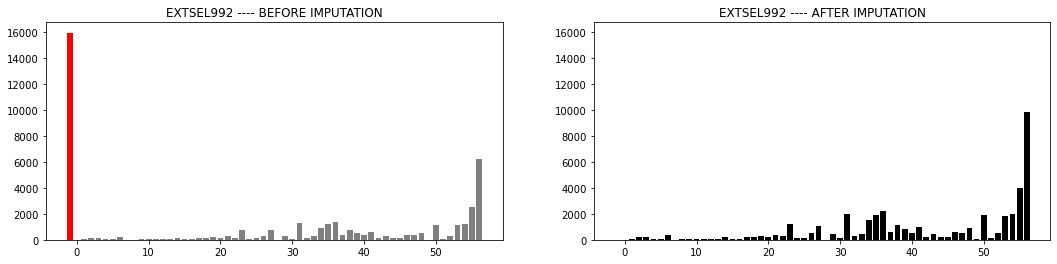

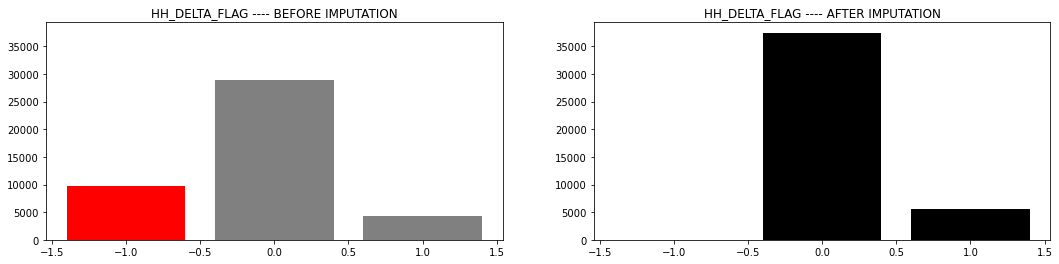

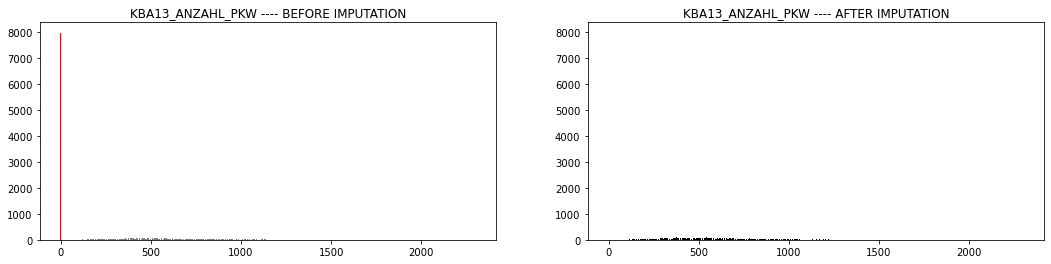

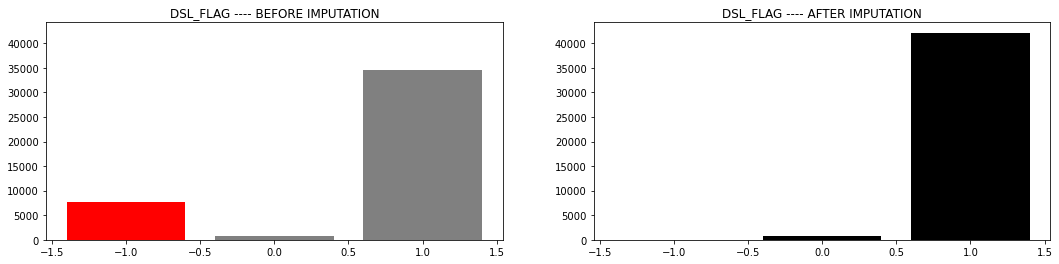

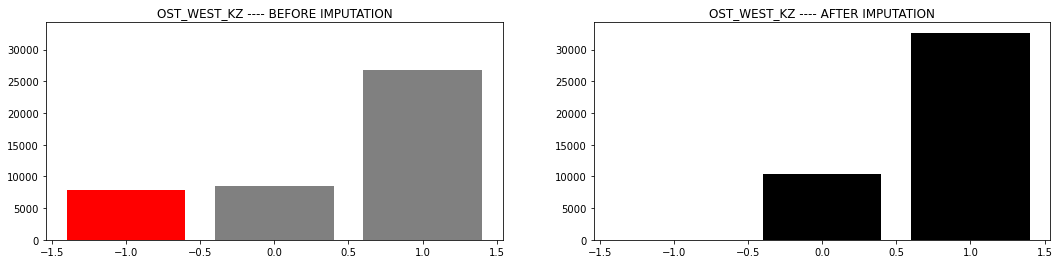

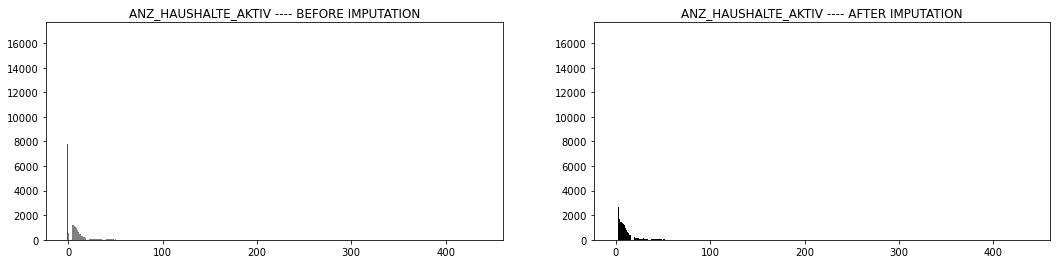

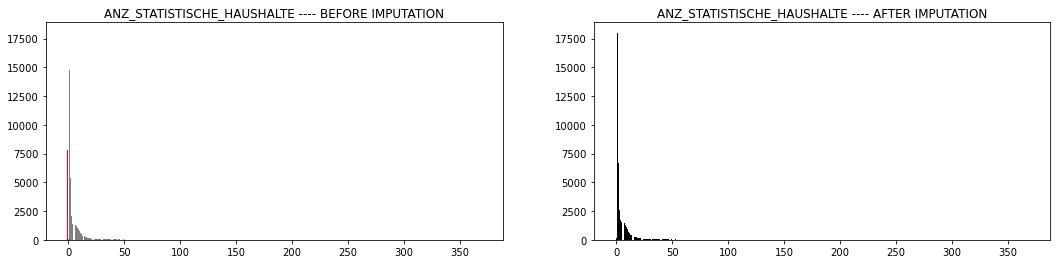

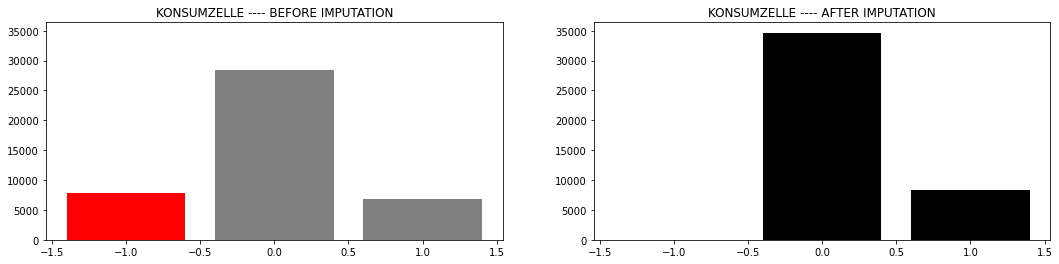

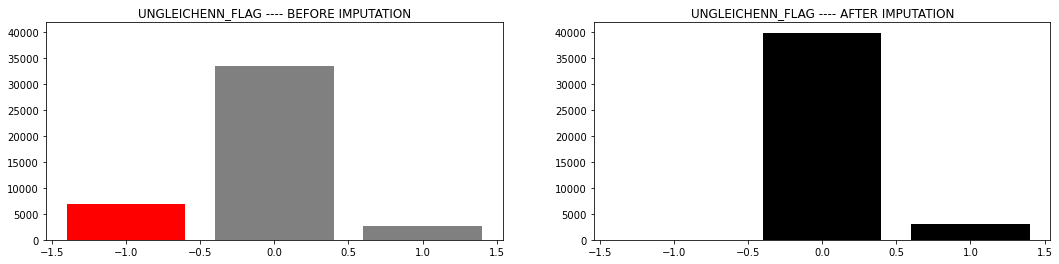

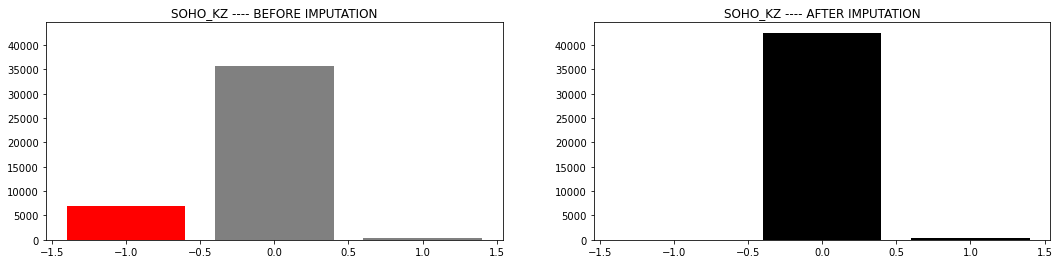

EXTSEL992  HH_DELTA_FLAG  KBA13_ANZAHL_PKW  DSL_FLAG  ANZ_STATISTISCHE_HAUSHALTE  KONSUMZELLE  OST_WEST_KZ  ANZ_HAUSHALTE_AKTIV  UNGLEICHENN_FLAG  SOHO_KZ
0       34.0            0.0             412.0       1.0                         2.0          0.0          1.0                  2.0               0.0      0.0
1       47.0            0.0             935.0       1.0                        21.0          0.0          1.0                 20.0               0.0      0.0
2       35.0            1.0             693.0       1.0                         2.0          1.0          1.0                  2.0               1.0      0.0
3       31.0            NaN             326.0       1.0                         1.0          0.0          0.0                  1.0               0.0      0.0
4       36.0            1.0             134.0       1.0                         1.0          0.0          1.0                  1.0               0.0      0.0

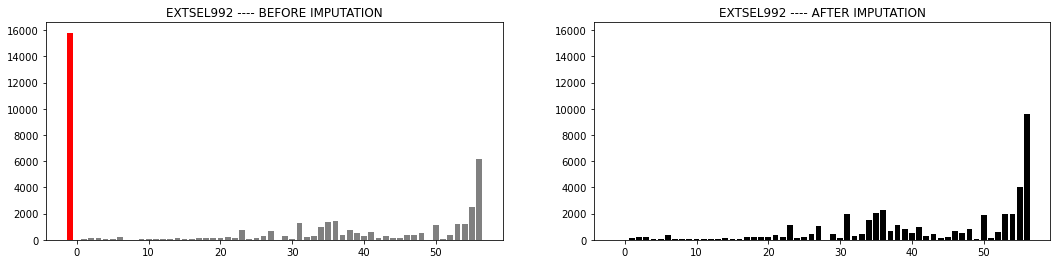

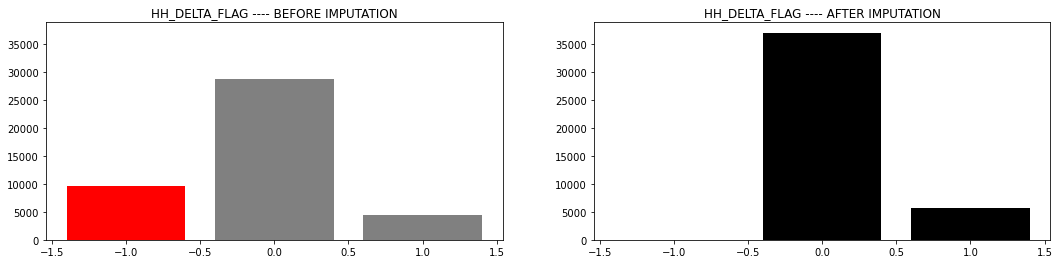

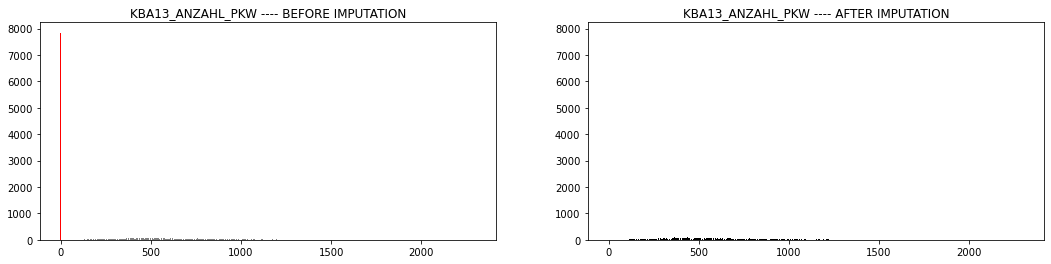

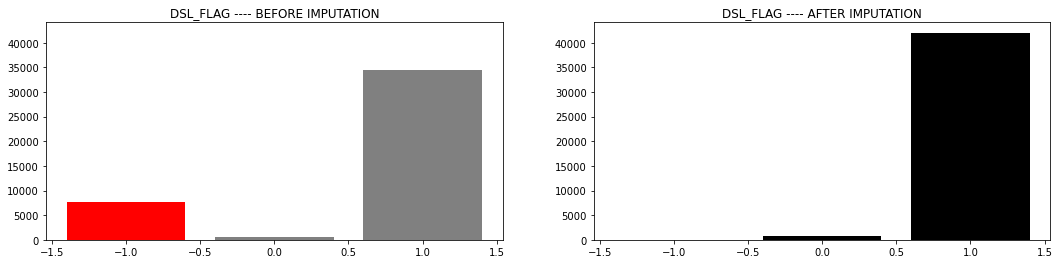

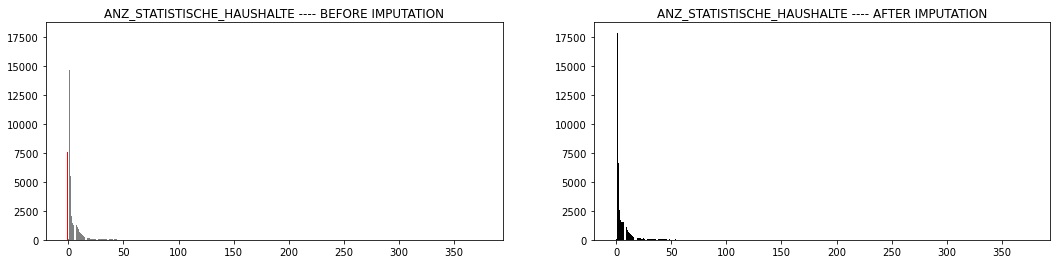

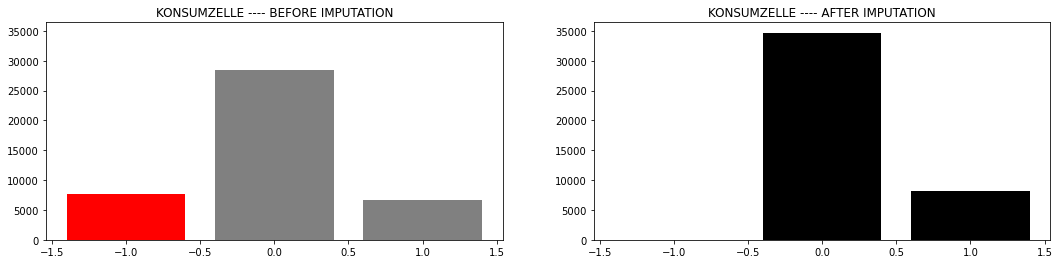

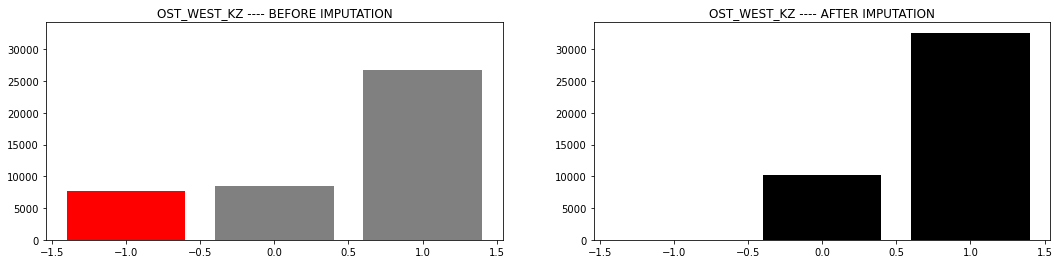

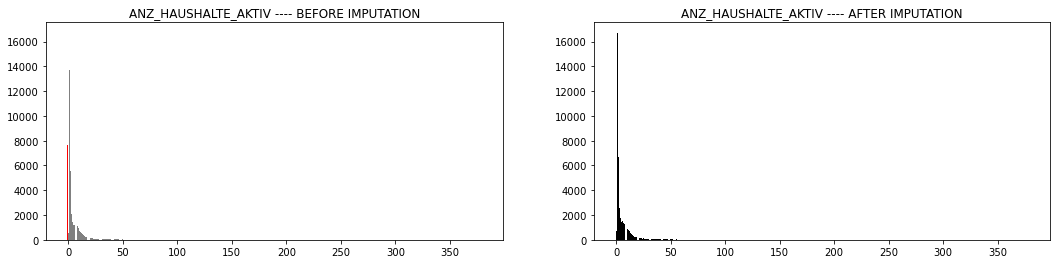

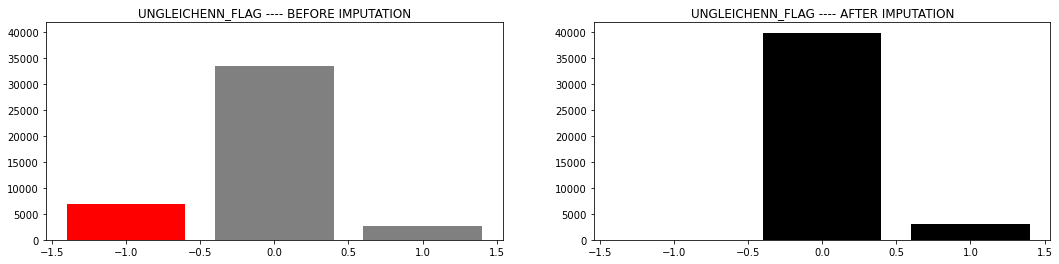

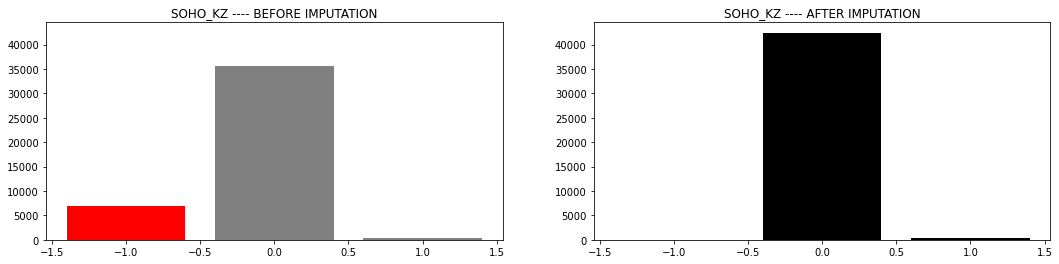

In [52]:
# Examine the rest of the missing data (Mailout Train Data), and the impact our imputing technique would have
mailed_missing = mailed[mailed.isnull().mean().sort_values(ascending=False)[mailed.isnull().mean().sort_values(ascending=False) > 0].index[:]]
mailed_missing.head()
see_impute(mailed_missing)

# Examine the rest of the missing data (Mailout Test Data), and the impact our imputing technique would have
totest_missing = totest[totest.isnull().mean().sort_values(ascending=False)[totest.isnull().mean().sort_values(ascending=False) > 0].index[:]]
totest_missing.head()
see_impute(totest_missing)

In [53]:
impute_feature(mailed['EXTSEL992'])
impute_feature(mailed['HH_DELTA_FLAG'])
impute_feature(mailed['KBA13_ANZAHL_PKW'])
impute_feature(mailed['DSL_FLAG'])
impute_feature(mailed['OST_WEST_KZ'])
impute_feature(mailed['ANZ_HAUSHALTE_AKTIV'])
impute_feature(mailed['ANZ_STATISTISCHE_HAUSHALTE'])
impute_feature(mailed['KONSUMZELLE'])
impute_feature(mailed['UNGLEICHENN_FLAG'])
impute_feature(mailed['SOHO_KZ'])

impute_feature(totest['EXTSEL992'])
impute_feature(totest['HH_DELTA_FLAG'])
impute_feature(totest['KBA13_ANZAHL_PKW'])
impute_feature(totest['DSL_FLAG'])
impute_feature(totest['OST_WEST_KZ'])
impute_feature(totest['ANZ_HAUSHALTE_AKTIV'])
impute_feature(totest['ANZ_STATISTISCHE_HAUSHALTE'])
impute_feature(totest['KONSUMZELLE'])
impute_feature(totest['UNGLEICHENN_FLAG'])
impute_feature(totest['SOHO_KZ'])

In [54]:
print("--- Mailout Train Data other non informative columns ---")
print("Number of bins: {}".format(mailed['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
mailed['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)
print("-----------------------------------------------")
print("Number of bins: {}".format(mailed['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
mailed['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)

print("--- Mailout Test Data other non informative columns ---")
print("Number of bins: {}".format(totest['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
totest['D19_VERSI_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)
print("-----------------------------------------------")
print("Number of bins: {}".format(totest['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True).count()))
totest['D19_TELKO_ONLINE_QUOTE_12'].value_counts(dropna=False, normalize=True)

--- Mailout Train Data other non informative columns ---
Number of bins: 4


0.0     0.998184
10.0    0.001560
5.0     0.000233
3.0     0.000023
Name: D19_VERSI_ONLINE_QUOTE_12, dtype: float64

-----------------------------------------------
Number of bins: 3


0.0     0.998859
10.0    0.001071
5.0     0.000070
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: float64

--- Mailout Test Data other non informative columns ---
Number of bins: 3


0.0     0.998646
10.0    0.001237
5.0     0.000117
Name: D19_VERSI_ONLINE_QUOTE_12, dtype: float64

-----------------------------------------------
Number of bins: 3


0.0     0.998833
10.0    0.001121
5.0     0.000047
Name: D19_TELKO_ONLINE_QUOTE_12, dtype: float64

In [55]:
mailed.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)
totest.drop(['D19_VERSI_ONLINE_QUOTE_12', 'D19_TELKO_ONLINE_QUOTE_12'], axis=1, inplace=True)

In [56]:
# Establish that no data is missing in the datasets
mailed.columns[mailed.isnull().any()]
print('\033[1m' + "Percent of Train data still missing: {:2}%".format(round(100*mailed.isnull().sum().sum()/mailed.size)))

totest.columns[totest.isnull().any()]
print('\033[1m' + "Percent of Test data still missing: {:2}%".format(round(100*totest.isnull().sum().sum()/totest.size)))

Index([], dtype='object')

Percent of Train data still missing:  0%


Index([], dtype='object')

Percent of Test data still missing:  0%


## Handle Outliers

In [57]:
print(" ---- Mailout Train Data - Numerical Features ----")
numericals(mailed)
print("")
print(" ---- Mailout Test Data - Numerical Features ----")
numericals(totest)

 ---- Mailout Train Data - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 175]
ANZ_STATISTISCHE_HAUSHALTE     [ 173]
EXTSEL992                      [  56]
GEBURTSJAHR                    [ 108]
KBA13_ANZAHL_PKW               [1230]

 ---- Mailout Test Data - Numerical Features ----
ANZ_HAUSHALTE_AKTIV            [ 178]
ANZ_STATISTISCHE_HAUSHALTE     [ 173]
EXTSEL992                      [  56]
GEBURTSJAHR                    [ 106]
KBA13_ANZAHL_PKW               [1231]


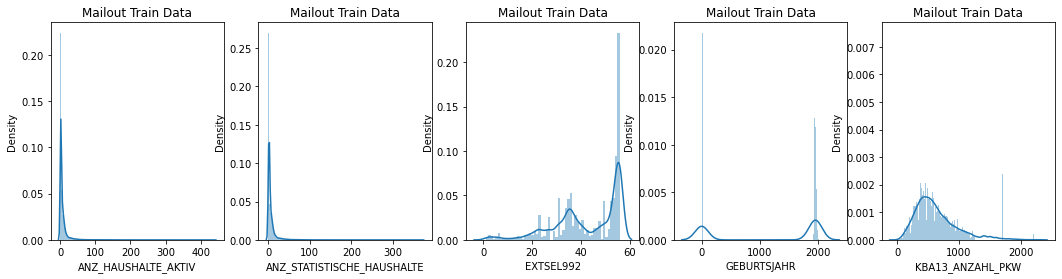

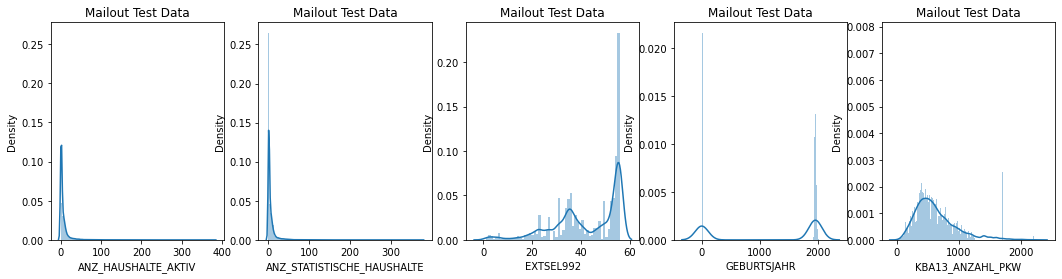

In [58]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
ax1 = f.add_subplot(151)
_ = ax1.set_title("Mailout Train Data")
_ = sns.distplot(mailed['ANZ_HAUSHALTE_AKTIV'], bins=175)
ax2 = f.add_subplot(152)
_ = ax2.set_title("Mailout Train Data")
_ = sns.distplot(mailed['ANZ_STATISTISCHE_HAUSHALTE'], bins=173)
ax3 = f.add_subplot(153)
_ = ax3.set_title("Mailout Train Data")
_ = sns.distplot(mailed['EXTSEL992'], bins=56)
ax4 = f.add_subplot(154)
_ = ax4.set_title("Mailout Train Data")
_ = sns.distplot(mailed['GEBURTSJAHR'], bins=108)
ax5 = f.add_subplot(155)
_ = ax5.set_title("Mailout Train Data")
_ = sns.distplot(mailed['KBA13_ANZAHL_PKW'], bins=1230)
_ = plt.show()


f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
ax1 = f.add_subplot(151)
_ = ax1.set_title("Mailout Test Data")
_ = sns.distplot(totest['ANZ_HAUSHALTE_AKTIV'], bins=178)
ax2 = f.add_subplot(152)
_ = ax2.set_title("Mailout Test Data")
_ = sns.distplot(totest['ANZ_STATISTISCHE_HAUSHALTE'], bins=173)
ax3 = f.add_subplot(153)
_ = ax3.set_title("Mailout Test Data")
_ = sns.distplot(mailed['EXTSEL992'], bins=56)
ax4 = f.add_subplot(154)
_ = ax4.set_title("Mailout Test Data")
_ = sns.distplot(totest['GEBURTSJAHR'], bins=106)
ax5 = f.add_subplot(155)
_ = ax5.set_title("Mailout Test Data")
_ = sns.distplot(totest['KBA13_ANZAHL_PKW'], bins=1231)
_ = plt.show()

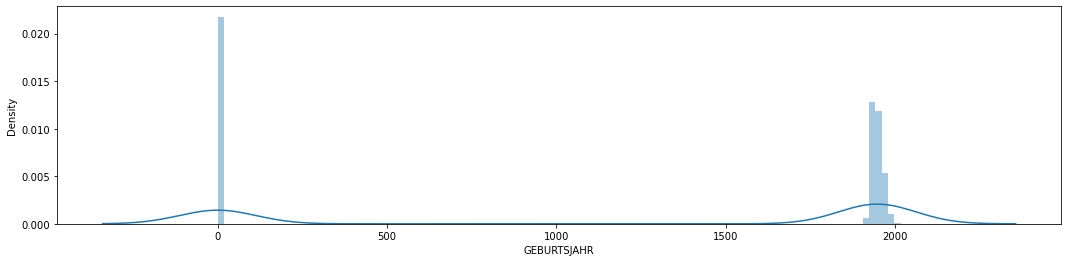

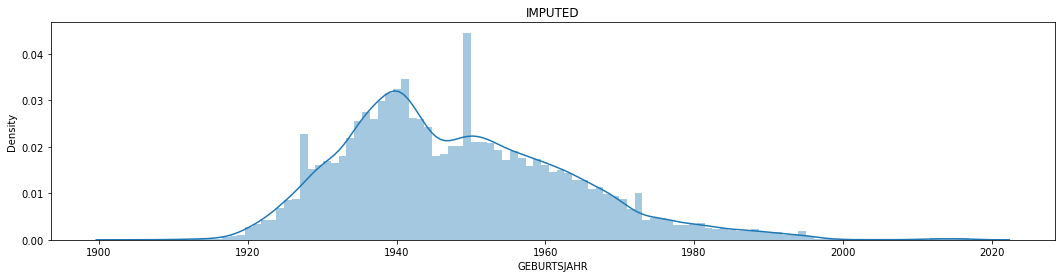

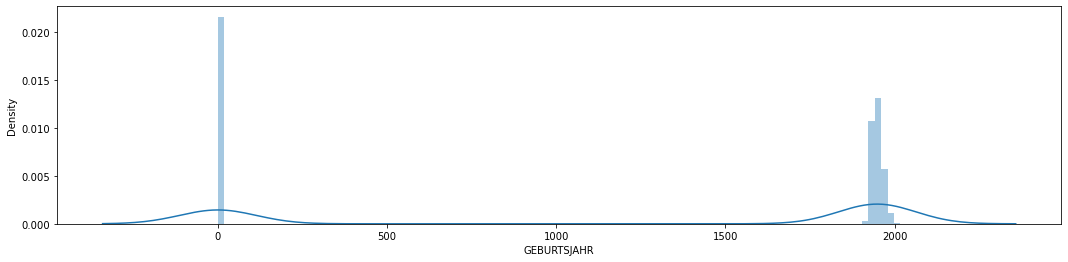

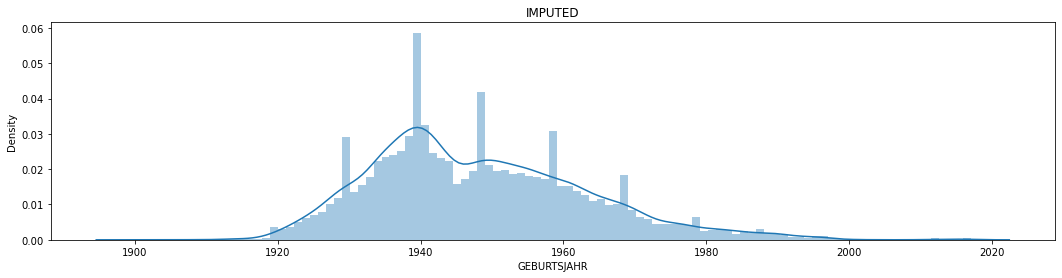

In [59]:
bins = mailed['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
mailed.loc[(mailed['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
impute_feature(mailed['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()


bins = totest['GEBURTSJAHR'].value_counts().sort_index(ascending=False).count()
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['GEBURTSJAHR'], bins=bins)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
totest.loc[(totest['GEBURTSJAHR'] == 0 ), 'GEBURTSJAHR'] = np.nan
impute_feature(totest['GEBURTSJAHR'])
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['GEBURTSJAHR'], bins=bins-1).set_title('IMPUTED')
_ = plt.show()

In [60]:
mailed['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)
totest['KBA13_ANZAHL_PKW'].value_counts().sort_index(ascending=False).head(15)

2300.0     30
2200.0     17
2100.0     27
2000.0     66
1900.0    111
1800.0    164
1700.0    192
1600.0    343
1500.0    481
1400.0    603
1300.0    351
1250.0     20
1249.0      7
1247.0      2
1246.0      7
Name: KBA13_ANZAHL_PKW, dtype: int64

2300.0     17
2200.0     13
2100.0     32
2000.0     78
1900.0     63
1800.0    141
1700.0    205
1600.0    357
1500.0    410
1400.0    622
1300.0    337
1250.0      8
1249.0      7
1247.0      4
1246.0      8
Name: KBA13_ANZAHL_PKW, dtype: int64

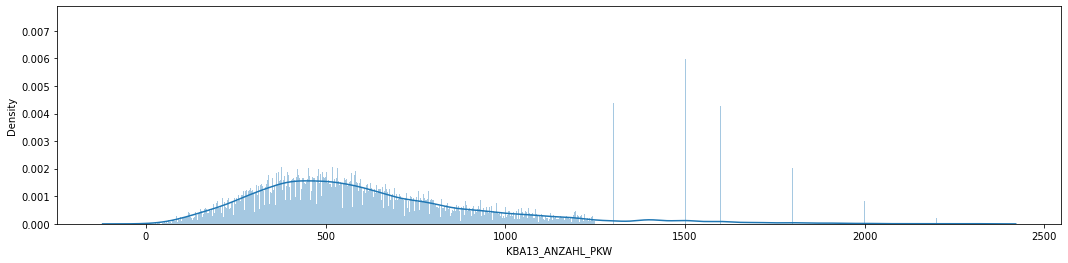

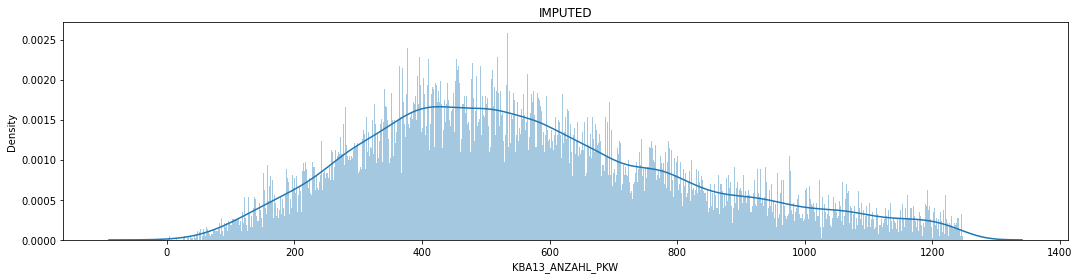

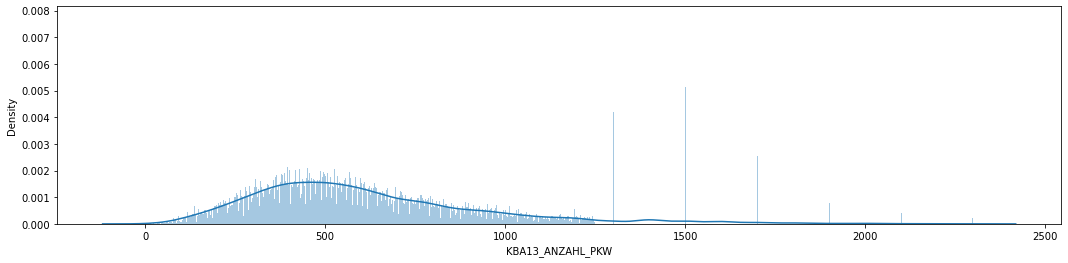

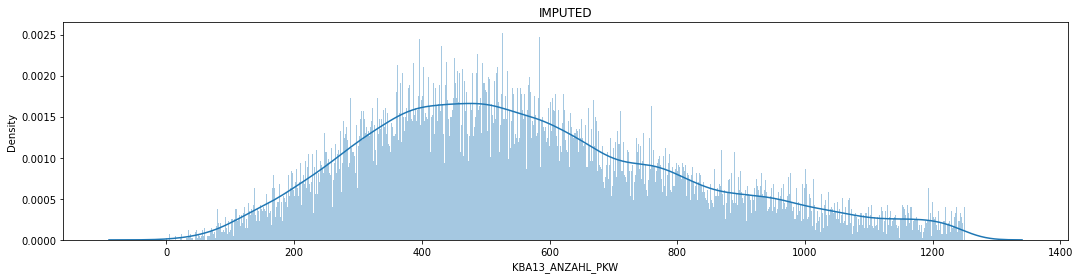

In [61]:
f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['KBA13_ANZAHL_PKW'], bins=1230)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
mailed.loc[(mailed['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
impute_feature(mailed['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(mailed['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()


f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['KBA13_ANZAHL_PKW'], bins=1230)
_ = plt.show()
# Temporarily move the outliers to the "missing" bin for imputing
totest.loc[(totest['KBA13_ANZAHL_PKW'] > 1250 ), 'KBA13_ANZAHL_PKW'] = np.nan
impute_feature(totest['KBA13_ANZAHL_PKW'])

f = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT/2))
_ = sns.distplot(totest['KBA13_ANZAHL_PKW'], bins=1250).set_title('IMPUTED')
_ = plt.show()

In [63]:
# Split Mailout dataset into Train and Test subsets
from sklearn.model_selection import train_test_split
mailout_X = mailed.drop('RESPONSE', axis=1)
mailout_y = mailed['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(mailout_X, mailout_y, stratify=mailout_y, test_size=0.2, random_state=RANDOM_STATE)

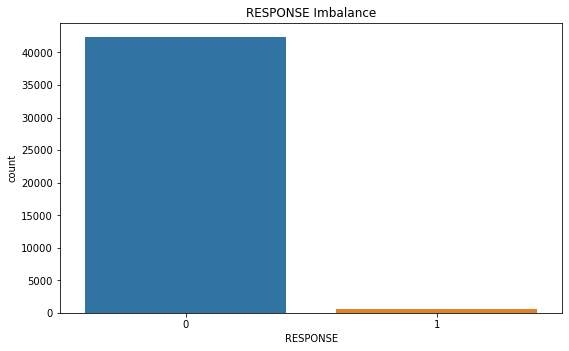

In [64]:
# Observe the imbalanced nature of the response label -- Suggest an appropriate metric.
f = plt.figure(figsize=(FIG_WIDTH/2, 2*FIG_HEIGHT/3))
_ = sns.countplot("RESPONSE", data=mailed).set_title('RESPONSE Imbalance')
_ = plt.show()

## Model Selection

Supervised learning algorithms search through a hypothesis space to find a good predictor for a particular problem. Simple techniques, such as Logistic Regression, and Decision Trees will be used, as well as Ensemble techniques that generate multiple hypotheses using the same base learner like Random Forest, Gradient Boosting and variants like XGBoost. Boosting refers to the general idea of producing a very accurate prediction rule by combining rough and moderately inaccurate rules-of-thumb. Boosting is a sequential process, where each subsequent model emphasizes the training instances that previous models mis-classified. In some cases, boosting yields better accuracy than bagging (“bootstrap aggregating”), but it also tends to over-fit the training data. We'll keep an eye on this during the hyperparameter tuning section.

Our mailout train dataset is imbalanced with the RESPONSE label consisting overwhelmingly of zeros, i.e., non customers. This points us in the direction of ROC AUC as a performance metric for this classification problem. ROC (Receiver Characteristic Operator) is a probability curve, and AUC (Area Under the Curve) tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

The code cells below explore several classifiers to get a taste of how well they perform. The best performing model will then be tuned to arrive at an optimal classification.

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#conda install -c conda-forge xgboost
import xgboost as xgb
from sklearn.metrics import roc_auc_score #, roc_curve, precision_recall_curve, auc,accuracy_score,confusion_matrix

<br/>**Logistic Regression:** This general classifier assumes that the outcome variable is binary, that the relationship between the **logit(p) = log ( p / (1-p) )** of the outcome and each continuous independent variable is linear, that there are no highly influential outliers that could distort the model accuracy, that there is no multicollinearity, that the observations are independent, and that the sample size is sufficiently large. Some of these assumptions are met, e.g., the binary nature of the `RESPONSE`. And some are not, e.g., multicollinearity, at least not without some processing such as principal component analysis. 

In [66]:
logistic_reg = LogisticRegression(random_state=RANDOM_STATE)
_ = logistic_reg.fit(X_train, y_train)
prediction = logistic_reg.predict_proba(X_test)[:,1]
print("Logistic Regression ROC AUC {}%".format( round(100*roc_auc_score(y_test, prediction),2)) )

Logistic Regression AUC-ROC 65.5%


<br/>**Decision Tree:** A flowchart-like tree structure where an internal node represents a feature, a branch represents a decision rule, and each leaf node represents the outcome. It learns to partition on the basis of the attribute value recursively. Decision trees can handle high dimensional data with good accuracy.

In [67]:
decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
_ = decision_tree.fit(X_train, y_train)
prediction = decision_tree.predict_proba(X_test)[:,1]
print("Decision Tree Classifier ROC AUC {}%".format( round(100*roc_auc_score(y_test, prediction),2)) )

Decision Tree Classifier AUC-ROC 50.62%


<br/>**Random Forest :** Builds multiple decision trees and merges them together to get a more accurate and stable prediction. Random forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model. Therefore, in random forest, only a random subset of the features is taken into consideration by the algorithm for splitting a node.

In [68]:
rand_forest = RandomForestClassifier(random_state=RANDOM_STATE)
_ = rand_forest.fit(X_train, y_train)
prediction = rand_forest.predict_proba(X_test)[:,1]
print("Random Forest Classifier ROC AUC {}%".format( round(100*roc_auc_score(y_test, prediction),2)) )

Random Forest Classifier AUC-ROC 64.93%


<br/>**AdaBoost :** The basic concept behind Adaptive boosting is to set the weights of classifiers and training the data sample in each iteration such that it ensures the accurate predictions of unusual observations. Adaboost combines multiple “weak classifiers” into a single “strong classifier”. AdaBoost works by putting more weight on difficult to classify instances and less on those already handled well.

In [69]:
ada_boost = AdaBoostClassifier(random_state=RANDOM_STATE)
_ = ada_boost.fit(X_train, y_train)
prediction = ada_boost.predict_proba(X_test)[:,1]
print("AdaBoost Classifier ROC AUC {}%".format( round(100*roc_auc_score(y_test, prediction),2)) )

AdaBoost Classifier AUC-ROC 72.41%


<br/>**Gradient Boost :** A generalization of the Adaptive Boosting concept that casts boosting as a numerical optimization problem where the objective is to minimize the loss of the model by adding weak learners using a gradient descent like procedure. The loss function used depends on the type of problem being solved. It must be differentiable, but many standard loss functions are supported. For example, regression may use a squared error and classification may use logarithmic loss. A benefit of the gradient boosting framework is that a new boosting algorithm does not have to be derived for each loss function that may want to be used, instead, it is a generic enough framework that any differentiable loss function can be used.

In [70]:
gradient_boost = GradientBoostingClassifier(random_state=RANDOM_STATE)
_ = gradient_boost.fit(X_train, y_train)
prediction = gradient_boost.predict_proba(X_test)[:,1]
print("Gradient Boosting Classifier ROC AUC {}%".format( round(100*roc_auc_score(y_test, prediction),2)) )

Gradient Boosting Classifier AUC-ROC 76.5%


<br/>**Extreme Gradient Boost :** XGBoost (Extreme Gradient Boosting) belongs to the family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library that is comparatively faster than other ensemble classifiers. The core algorithm is parallelizable, so it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.

In [71]:
XG_boost = xgb.XGBClassifier(random_state=RANDOM_STATE)
_ = XG_boost.fit(X_train, y_train)
prediction = XG_boost.predict_proba(X_test)[:,1]
print("XGB Classifier ROC AUC {}%".format( round(100*roc_auc_score(y_test, prediction),2)) )

[14:12:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier AUC-ROC 71.56%


## Hyperparameter Tuning

**GradientBoostingClassifier** has the most promising score; it will be our model selected for hyperparameter tuning. The overall parameters of this ensemble model can be divided into 3 categories: Tree-Specific Parameters, Boosting Parameters, and other miscellaneous parameters for overall functioning. We'll focus on a few of the most impactful tree-specific, and boosting parameters; these are: `learning_rate`, `n_estimators`, `max_depth`, `max_features`, and `subsample`.

In [ ]:
from sklearn.metrics import roc_curve, auc
# Observe behaviour of each parameter in isolation first, to see where the sensitive kinks are.

hyperparams = {
     "learning_rate" : [0.0001, 0.0005, 0.001, 0.005, 0.01],
     "n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
     "max_depth" : [2, 3, 4, 5, 6, 7, 8, 9, 10],
     "max_features" : [50, 100, 150, 200, 250, 300, 350]
}
lr_train_metrics = []
lr_test_metrics = []
ne_train_metrics = []
ne_test_metrics = []
md_train_metrics = []
md_test_metrics = []
mf_train_metrics = []
mf_test_metrics = []
for hyper, values in hyperparams.items():
    print("\n " + hyper + ": ", end=' ')
    for param in values:
        print(param, end=' ')
        if hyper == "learning_rate":
            modelo = GradientBoostingClassifier( learning_rate = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            lr_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            lr_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "n_estimators":
            modelo = GradientBoostingClassifier( n_estimators = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            ne_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            ne_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "max_depth":
            modelo = GradientBoostingClassifier( max_depth = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            md_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            md_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )
        elif hyper == "max_features":
            modelo = GradientBoostingClassifier( max_features = param, random_state=RANDOM_STATE)
            _ = modelo.fit(X_train, y_train)
            mf_train_metrics.append( roc_auc_score(y_train, modelo.predict_proba(X_train)[:,1]) )
            mf_test_metrics.append( roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1]) )

f = plt.figure(figsize=(FIG_WIDTH, 1.5*FIG_HEIGHT))
ax1 = f.add_subplot(221)
_ = ax1.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["learning_rate"], lr_train_metrics)
_ = plt.plot(hyperparams["learning_rate"], lr_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('learning_rate')
ax2 = f.add_subplot(222)
_ = ax2.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["n_estimators"], ne_train_metrics)
_ = plt.plot(hyperparams["n_estimators"], ne_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('n_estimators')
ax3 = f.add_subplot(223)
_ = ax3.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["max_depth"], md_train_metrics)
_ = plt.plot(hyperparams["max_depth"], md_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('max_depth')
ax4 = f.add_subplot(224)
_ = ax4.set_title("Mailout Train vs Test Data")
_ = plt.plot(hyperparams["max_features"], mf_train_metrics)
_ = plt.plot(hyperparams["max_features"], mf_test_metrics, color='red')
_ = plt.ylabel('ROC AUC score')
_ = plt.xlabel('max_features')
_ = plt.show()


 learning_rate:  0.0001 

The graphs above allow us to observe regions where the gap between the train and test (red) results aren't too wide (overfitting) and not crossing (underfitting). It is the values in these regions that we'll then try to tune in the following code cells to obtain an improvement over our benchmark `GradientBoostClassifier`. 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

base_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
_ = base_model.fit(X_train, y_train)
print("GB ROC AUC {}%".format( round(100*roc_auc_score(y_test, base_model.predict_proba(X_test)[:,1]),2)) )

Many strategies exist to tune GBM parameters, but most focus on number of trees (`n_estimators`), tree depth (`max_depth`), and learning rate (`learning_rate`) as the most crucial. We'll tune these three, as well as the number of features to consider for splitting (`max_features`) using 5-fold cross validation and evaluate models based on `roc_auc` scoring.
The code cell below shows us all the parameters that can be tuned.

**Tune Boosting Parameters <span style='color:blue'>learning_rate</span> and <span style='color:blue'>n_estimators</span>**
**learning_rate:** GBM works by starting with an initial estimate which is changed using the output of each tree. The `learning_rate` parameter controls the magnitude of this change in the estimates. Lower values are generally preferred as they make the model robust to the specific characteristics of tree, thus allowing it to generalize well.
**n_estimators:** The number of sequential trees to be modeled. GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using Cross Validation for a particular learning rate. Usually a higher number of trees imoproves the learning; however, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.


**Tune Tree-specific parameters <span style='color:blue'>max_depth</span> and <span style='color:blue'>max_features</span>**
**max_depth:** This indicates how deep the tree can be. The deeper the tree, the more splits it has. Higher depth will allow the model to learn relations very specific to a particular sample (overfitting).
**max_features:** The number of features to consider while searching for a best split. These will be randomly selected.
As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
If None, then max_features=n_features. Choosing `max_features` < `n_features` leads to a reduction of variance and an increase in bias.

In [ ]:
tuning_model = GridSearchCV(estimator = GradientBoostingClassifier(random_state=RANDOM_STATE),\
                       param_grid = {'learning_rate':[0.001, 0.005, 0.01],\
                                     'n_estimators':[20, 30, 40],\
                                     'max_depth':[3, 4, 5],\
                                     'max_features':[275, 300, 325]},\
                       scoring='roc_auc', n_jobs=-1, verbose=2)
_ = tuning_model.fit(X_train,y_train)
tuning_model.cv_results_
tuning_model.best_params_
print("GB ROC AUC {}%".format( round(100*tuning_model.best_score_, 2) ))

In [ ]:
final_model = GradientBoostingClassifier(learning_rate=0.001, n_estimators=275, max_depth=3,\
                                        max_features=275, random_state=RANDOM_STATE)
_ = final_model.fit(X_train, y_train)
feat_imp = pd.Series(final_model.feature_importances_, list(X_train)).sort_values(ascending=False).head(10)
_ = feat_imp.plot(kind='bar', title='Features Importance')
_ = plt.ylabel('Feature Importance Score')
print("GBM ROC AUC {}%".format( round(100*roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1]),2)) )
print(classification_report(y_test, final_model.predict(X_test)))

The plot displays the importance of the top 10 features.

In [241]:
preds_gb_totest = final_model.predict_proba(totest)[:,1]
kaggle_submit = pd.DataFrame(index=tt_LNR, data=preds_gb_totest)
kaggle_submit.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_submit.head(10)

RESPONSE
LNR           
1754  0.036449
1770  0.016243
1465  0.001721
1470  0.001806
1478  0.002264
1782  0.001892
1485  0.003507
1519  0.008242
1835  0.168880
1522  0.002240

In [242]:
kaggle_submit.to_csv("arvato_for_kaggle.csv")

## CONCLUSIONS:

## References:
- Multiple Imputation for Continuous and Categorical Data: Comparing Joint and Conditional Approaches;
Jonathan Kropko, Ben Goodrich, Andrew Gelman & Jennifer Hill (October 4, 2013), page 2. ;
Retrieved from http://www.stat.columbia.edu/~gelman/research/published/MI_manuscript_RR.pdf

- Investigation of Multiple Imputation Methods for Categorical Variables;
Samantha Miranda (May 2020);
Retrieved from https://dc.etsu.edu/cgi/viewcontent.cgi?article=5204&context=etd

- Avoiding bias due to perfect prediction in multiple imputation of incomplete categorical variables;
Computational Statistics & Data Analysis,
Ian R White, Rhian Daniel, and Patrick Royston (October 1, 2010);
Retrieved from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3990447/

- Assumptions of Logistic Regression, Clearly Explained;
Kenneth Leung (October 4, 2021);
Retrieved from https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290

- Decision Tree Classification in Python;
Avinash Naviani (December 28, 2018);
Retrieved from https://www.datacamp.com/community/tutorials/decision-tree-classification-python

- A Complete Guide to the Random Forest Algorithm;
Niklas Donges (July 22, 2021);
Retrieved from https://builtin.com/data-science/random-forest-algorithm

- AdaBoost Classifier in Python;
Avinash Naviani (November 20, 2018);
Retrieved from https://www.datacamp.com/community/tutorials/adaboost-classifier-python

- Understanding AdaBoost
Akash Desarda (January 17, 2019);
Retrieved from https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe

- A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning;
Jason Brownlee (September 9, 2016);
Retrieved from https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

- Using XGBoost in Python;
Manish Pathak (November 8, 2019);
Retrieved from https://www.datacamp.com/community/tutorials/xgboost-in-python

- Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python;
Aarshay Jain (February 21, 2016);
Retrieved from https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/